In [1]:
# setup the const variables

# the path of the data
DATA_PATH = (
    "dataset/Image_Classification/dataset_24581896"
)
import glob
maximum_file = [x for x in glob.glob(f"{DATA_PATH}/**/*.jpg")]
print(len(maximum_file))

BATCH_SIZE = 32
STEP_PER_EPOCH = len(maximum_file) // BATCH_SIZE
EPOCH = 50


3236


In [2]:
def prepare_data(data_path, batch_size):
    """
    make the data ready for the model
    split the data into training, validation and testing
    train_ds: the training data
    val_ds: the validation data
    test_ds: the testing data
    
    train : 64%
    validation : 16%
    test : 20%
    """
    # !pip install split-folders
    import splitfolders
    import tensorflow as tf
    import tensorflow.keras.preprocessing as prep
    import os

    temp_output = "dataset/Image_Classification__temp"

    if os.path.exists(temp_output) == False:
        splitfolders.ratio(
            DATA_PATH,
            output=temp_output,
            seed=24581896,
            ratio=(0.64, 0.16, 0.2),
            group_prefix=None,
        )

    # # create a image generator
    img_gen = prep.image.ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=30,
        width_shift_range=0.05,
        height_shift_range=0.05,    
        zoom_range=0.5  ,
        horizontal_flip=True,
        vertical_flip=True,
    )
    

    # load the data
    train_ds = img_gen.flow_from_directory(
        temp_output + "/train",
        class_mode="categorical",
        target_size=(256, 256),
        seed=24581896,
        batch_size=batch_size,
    )

    val_ds = img_gen.flow_from_directory(
        temp_output + "/val",
        class_mode="categorical",
        target_size=(256, 256),
        seed=24581896,
        batch_size=batch_size,
    )
    
    test_ds = img_gen.flow_from_directory(
        temp_output + "/test",
        class_mode="categorical",
        target_size=(256, 256),
        seed=24581896,
        batch_size=batch_size,
    )

    labels = train_ds.class_indices.keys()
    num_classes = len(labels)
    train_ds.save_to_dir = temp_output + "/train"

    return train_ds, val_ds, test_ds, labels, num_classes

In [3]:
train_ds, val_ds, test_ds, class_names, num_classes = prepare_data(DATA_PATH, BATCH_SIZE)

2024-05-04 08:51:20.758983: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 08:51:20.785727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 08:51:21.207063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Copying files: 3236 files [00:00, 23519.94 files/s]

Found 2061 images belonging to 20 classes.
Found 508 images belonging to 20 classes.
Found 667 images belonging to 20 classes.


In [4]:
type(train_ds)
# train_ds.labels
train_ds.class_indices.keys()

dict_keys(['AMETHYST WOODSTAR', 'BLACK THROATED HUET', 'Bedlington_terrier', 'CAMPO FLICKER', 'DOWNY WOODPECKER', 'ELEGANT TROGON', 'EntleBucher', 'FIERY MINIVET', 'GREATER PRAIRIE CHICKEN', 'Great_Dane', 'KING EIDER', 'KING VULTURE', 'ORNATE HAWK EAGLE', 'Saint_Bernard', 'Shetland_sheepdog', 'Walker_hound', 'black-and-tan_coonhound', 'boxer', 'dingo', 'toy_terrier'])

## step 2. Create a Classifiers mdoel 

1. Customize AlexNet/GoogleNet/ResNet etc. and reduce/increase the layers, Train, and Test for image classification.

In [5]:
import tensorflow
import tensorflow.keras
from tensorflow.keras import models, layers, applications as apps, callbacks
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from datetime import datetime
import seaborn

# from models.inception_v4 import inception_v4

# resnet implement


def view_train_chart(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

def create_model__resnetv2(num_classes):
    # init
    model = models.Sequential(
        [
            layers.Input((256, 256, 3)),
            apps.ResNet152V2(
                include_top=False,
                weights="imagenet",
                pooling="avg",
            ),
            layers.Flatten(),
            layers.Dense(4096, activation="relu"),
            layers.Dense(1000, activation="relu"),
            layers.Dense(num_classes, activation="softmax", name="predictions"),
        ]
    )

    return model


# google net (inception_v4)
def create_model__inception_v3(num_classes):
    model = models.Sequential(
        [
            layers.Input((256, 256, 3)),
            apps.InceptionV3(
                include_top=False,
                weights="imagenet",
                pooling="avg",
            ),
            layers.Flatten(),
            layers.Dense(4096, activation="relu"),
            layers.Dense(1000, activation="relu"),
            layers.Dense(num_classes, activation="softmax", name="predictions"),
        ]
    )
    # include_top = (True,)
    # weights = ("imagenet",)
    # input_tensor = (None,)
    # input_shape = (None,)
    # pooling = (None,)
    # classes = (1000,)
    # classifier_activation = "softmax"
    return model


def train_model(model,model_name, train_ds, val_ds):
    # init

    now_time = f"{datetime.now():%Y-%m-%d_%H-%M-%S}"

    log_file_name = f"./logs/training__{model_name}__{now_time}.csv"

    open(log_file_name, 'a').close()

    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["acc"],
    )

    ckp_weights_dir = f"./ckp_weights/img_clsr/{model_name}__{now_time}/"
    os.makedirs(ckp_weights_dir, exist_ok=True)

    checkpoint = callbacks.ModelCheckpoint(
        ckp_weights_dir + "{epoch:02d}-{val_loss:.2f}.weights.h5",
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
    )

    cv_logging = callbacks.CSVLogger(log_file_name, separator=",", append=True)
    history = model.fit(
        train_ds,
        steps_per_epoch=STEP_PER_EPOCH,  # 2000 images = batch_size * steps
        epochs=EPOCH,
        validation_data=val_ds,
        validation_steps=STEP_PER_EPOCH//4,  # 1000 images = batch_size * steps
        callbacks=[checkpoint, cv_logging],
    )

    return model, history


def plot_roc_curve(y_true, y_pred):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot( 
        fpr, tpr, color="darkorange", lw=2, 
        label="ROC curve (area = %0.2f)" % roc_auc
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm, annot=True, fmt="d", 
        xticklabels=class_names, yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()


def test_model(model, test_ds):
    # test the model
    loss, acc = model.evaluate(test_ds)
    print(f"Test loss: {loss}, acc: {acc}")

    y_pred = model.predict(test_ds)
    class_names = list(test_ds.class_indices.keys())
    plot_roc_curve(test_ds.labels, y_pred)
    plot_confusion_matrix(test_ds.labels, y_pred.argmax(axis=1), class_names)
    return loss, acc

2024-05-01 13:50:29.313484: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 13:50:29.327736: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50


/home/ghost/anaconda3/envs/uts-dl/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



  1/101 ━━━━━━━━━━━━━━━━━━━━ 1:13:39 44s/step - acc: 0.1250 - loss: 2.9746


  2/101 ━━━━━━━━━━━━━━━━━━━━ 13:55 8s/step - acc: 0.1250 - loss: 3.4488   


  3/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 8s/step - acc: 0.1285 - loss: 3.6968


  4/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 8s/step - acc: 0.1296 - loss: 3.7333


  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:23 8s/step - acc: 0.1274 - loss: 3.7197


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:13 8s/step - acc: 0.1244 - loss: 3.6966


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 8s/step - acc: 0.1251 - loss: 3.6626


  8/101 ━━━━━━━━━━━━━━━━━━━━ 12:56 8s/step - acc: 0.1251 - loss: 3.6332


  9/101 ━━━━━━━━━━━━━━━━━━━━ 12:49 8s/step - acc: 0.1259 - loss: 3.6034


 10/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 8s/step - acc: 0.1258 - loss: 3.5734


 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 8s/step - acc: 0.1262 - loss: 3.5448


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 8s/step - acc: 0.1266 - loss: 3.5188


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 8s/step - acc: 0.1266 - loss: 3.4951


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 8s/step - acc: 0.1260 - loss: 3.4736


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 8s/step - acc: 0.1254 - loss: 3.4540


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 8s/step - acc: 0.1246 - loss: 3.4358


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 8s/step - acc: 0.1239 - loss: 3.4197


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 8s/step - acc: 0.1230 - loss: 3.4055


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 8s/step - acc: 0.1222 - loss: 3.3922


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 8s/step - acc: 0.1214 - loss: 3.3802


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 8s/step - acc: 0.1206 - loss: 3.3691


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 8s/step - acc: 0.1201 - loss: 3.3585


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 8s/step - acc: 0.1196 - loss: 3.3487


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 8s/step - acc: 0.1191 - loss: 3.3394


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:45 8s/step - acc: 0.1186 - loss: 3.3306


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 8s/step - acc: 0.1182 - loss: 3.3222


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.1177 - loss: 3.3141


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.1174 - loss: 3.3063


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.1170 - loss: 3.2989


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.1168 - loss: 3.2917


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.1167 - loss: 3.2846 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.1167 - loss: 3.2780


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.1166 - loss: 3.2718


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.1166 - loss: 3.2657


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.1166 - loss: 3.2601


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - acc: 0.1165 - loss: 3.2547


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:06 9s/step - acc: 0.1165 - loss: 3.2496


 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:58 9s/step - acc: 0.1165 - loss: 3.2448


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.1166 - loss: 3.2401


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:41 9s/step - acc: 0.1165 - loss: 3.2356


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:33 9s/step - acc: 0.1164 - loss: 3.2313


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.1164 - loss: 3.2270


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.1163 - loss: 3.2229


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.1162 - loss: 3.2189


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.1162 - loss: 3.2151


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.1161 - loss: 3.2113


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.1161 - loss: 3.2076


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.1160 - loss: 3.2040


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.1159 - loss: 3.2005


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.1159 - loss: 3.1971


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.1158 - loss: 3.1939


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.1158 - loss: 3.1907


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.1157 - loss: 3.1877


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.1156 - loss: 3.1848


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.1156 - loss: 3.1820


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.1155 - loss: 3.1792


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.1155 - loss: 3.1765


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:09 9s/step - acc: 0.1154 - loss: 3.1738


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.1154 - loss: 3.1713


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:52 9s/step - acc: 0.1153 - loss: 3.1688


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.1153 - loss: 3.1664


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.1152 - loss: 3.1641


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.1152 - loss: 3.1617


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.1151 - loss: 3.1594


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.1151 - loss: 3.1572


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:01 9s/step - acc: 0.1150 - loss: 3.1550


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:49 9s/step - acc: 0.1150 - loss: 3.1529


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:40 9s/step - acc: 0.1149 - loss: 3.1508


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:32 9s/step - acc: 0.1148 - loss: 3.1488


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:23 9s/step - acc: 0.1147 - loss: 3.1469


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:15 9s/step - acc: 0.1146 - loss: 3.1449


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:07 9s/step - acc: 0.1145 - loss: 3.1431


 73/101 ━━━━━━━━━━━━━━━━━━━━ 3:58 9s/step - acc: 0.1145 - loss: 3.1412


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:50 9s/step - acc: 0.1144 - loss: 3.1394


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:41 9s/step - acc: 0.1143 - loss: 3.1376


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 9s/step - acc: 0.1142 - loss: 3.1358


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 9s/step - acc: 0.1141 - loss: 3.1341


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 9s/step - acc: 0.1140 - loss: 3.1324


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 9s/step - acc: 0.1139 - loss: 3.1308


 80/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 9s/step - acc: 0.1138 - loss: 3.1291


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 9s/step - acc: 0.1138 - loss: 3.1275


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 9s/step - acc: 0.1137 - loss: 3.1258

2024-05-01 14:02:48.037043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/ghost/anaconda3/envs/uts-dl/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2024-05-01 14:03:33.300358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 783s 7s/step - acc: 0.1127 - loss: 3.0942 - val_acc: 0.0547 - val_loss: 2703.4697


Epoch 2/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:18 10s/step - acc: 0.1562 - loss: 2.7476


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.1328 - loss: 2.8147 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.1233 - loss: 2.8346


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.1237 - loss: 2.8397


  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.1252 - loss: 2.8386


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.1269 - loss: 2.8346


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.1305 - loss: 2.8288


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.1317 - loss: 2.8293


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.1318 - loss: 2.8310


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.1311 - loss: 2.8337


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.1313 - loss: 2.8354


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.1314 - loss: 2.8370


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.1309 - loss: 2.8403


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.1307 - loss: 2.8427


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.1304 - loss: 2.8460


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.1303 - loss: 2.8485


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.1299 - loss: 2.8508


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 9s/step - acc: 0.1294 - loss: 2.8528


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 9s/step - acc: 0.1291 - loss: 2.8547


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 9s/step - acc: 0.1288 - loss: 2.8563


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:41 9s/step - acc: 0.1284 - loss: 2.8577


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 9s/step - acc: 0.1282 - loss: 2.8587


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:23 9s/step - acc: 0.1280 - loss: 2.8592


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:14 9s/step - acc: 0.1277 - loss: 2.8596


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 9s/step - acc: 0.1273 - loss: 2.8600


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:56 9s/step - acc: 0.1270 - loss: 2.8601


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:48 9s/step - acc: 0.1268 - loss: 2.8599


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:39 9s/step - acc: 0.1266 - loss: 2.8597


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:30 9s/step - acc: 0.1264 - loss: 2.8594


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:22 9s/step - acc: 0.1262 - loss: 2.8593


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.1261 - loss: 2.8592


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.1260 - loss: 2.8591


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.1258 - loss: 2.8591 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.1256 - loss: 2.8590


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.1255 - loss: 2.8589


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.1253 - loss: 2.8588


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.1250 - loss: 2.8588


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.1248 - loss: 2.8589


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.1245 - loss: 2.8590


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.1243 - loss: 2.8592


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.1241 - loss: 2.8594


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.1238 - loss: 2.8597


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.1236 - loss: 2.8600


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.1234 - loss: 2.8602


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.1232 - loss: 2.8604


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.1230 - loss: 2.8606


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.1228 - loss: 2.8607


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.1225 - loss: 2.8608


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.1223 - loss: 2.8608


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.1221 - loss: 2.8609


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.1219 - loss: 2.8609


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.1217 - loss: 2.8610


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.1215 - loss: 2.8610


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.1213 - loss: 2.8611


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.1210 - loss: 2.8611


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.1208 - loss: 2.8610


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.1206 - loss: 2.8610


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.1204 - loss: 2.8610


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.1202 - loss: 2.8610


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.1200 - loss: 2.8609


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.1198 - loss: 2.8609


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.1196 - loss: 2.8609


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.1194 - loss: 2.8609


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.1193 - loss: 2.8609


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.1191 - loss: 2.8609


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 9s/step - acc: 0.1190 - loss: 2.8609


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:53 9s/step - acc: 0.1188 - loss: 2.8609


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.1187 - loss: 2.8609


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:36 9s/step - acc: 0.1186 - loss: 2.8609


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.1185 - loss: 2.8609


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 9s/step - acc: 0.1183 - loss: 2.8608


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:10 9s/step - acc: 0.1182 - loss: 2.8608


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.1181 - loss: 2.8608


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:53 9s/step - acc: 0.1180 - loss: 2.8607


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.1179 - loss: 2.8607


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.1178 - loss: 2.8606


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 9s/step - acc: 0.1177 - loss: 2.8605


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.1177 - loss: 2.8604


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.1176 - loss: 2.8603


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 9s/step - acc: 0.1175 - loss: 2.8601


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.1175 - loss: 2.8600


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.1174 - loss: 2.8598

2024-05-01 14:15:26.473173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-01 14:16:09.465973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 756s 7s/step - acc: 0.1166 - loss: 2.8510 - val_acc: 0.0469 - val_loss: 401.4771


Epoch 3/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:14 10s/step - acc: 0.0938 - loss: 3.0054


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.0859 - loss: 2.9863 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.0885 - loss: 2.9893


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.0879 - loss: 2.9877


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.0878 - loss: 2.9821


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.0879 - loss: 2.9764


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.0881 - loss: 2.9710


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.0874 - loss: 2.9687


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.0865 - loss: 2.9673


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.0869 - loss: 2.9649


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.0876 - loss: 2.9628


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.0883 - loss: 2.9611


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.0887 - loss: 2.9595


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.0889 - loss: 2.9593


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.0892 - loss: 2.9588


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.0894 - loss: 2.9583


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 9s/step - acc: 0.0899 - loss: 2.9576


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 9s/step - acc: 0.0901 - loss: 2.9567


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 9s/step - acc: 0.0904 - loss: 2.9557


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 9s/step - acc: 0.0908 - loss: 2.9549


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:41 9s/step - acc: 0.0911 - loss: 2.9540


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 9s/step - acc: 0.0914 - loss: 2.9533


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:23 9s/step - acc: 0.0917 - loss: 2.9526


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:14 9s/step - acc: 0.0920 - loss: 2.9523


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.0922 - loss: 2.9520


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.0923 - loss: 2.9516


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 9s/step - acc: 0.0924 - loss: 2.9512


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:56 9s/step - acc: 0.0926 - loss: 2.9508


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.0929 - loss: 2.9502


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 9s/step - acc: 0.0931 - loss: 2.9499


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 9s/step - acc: 0.0933 - loss: 2.9495


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.0935 - loss: 2.9490


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:08 9s/step - acc: 0.0936 - loss: 2.9486


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:59 9s/step - acc: 0.0938 - loss: 2.9481 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:50 9s/step - acc: 0.0939 - loss: 2.9476


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.0940 - loss: 2.9470


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.0942 - loss: 2.9463


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.0943 - loss: 2.9456


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.0946 - loss: 2.9448


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.0949 - loss: 2.9439


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.0951 - loss: 2.9432


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.0954 - loss: 2.9426


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.0956 - loss: 2.9421


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.0959 - loss: 2.9415


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.0960 - loss: 2.9411


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.0962 - loss: 2.9407


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.0963 - loss: 2.9402


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:42 9s/step - acc: 0.0964 - loss: 2.9397


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.0966 - loss: 2.9392


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:25 9s/step - acc: 0.0967 - loss: 2.9387


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:16 9s/step - acc: 0.0969 - loss: 2.9382


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:07 9s/step - acc: 0.0971 - loss: 2.9376


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:59 9s/step - acc: 0.0973 - loss: 2.9370


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:50 9s/step - acc: 0.0975 - loss: 2.9363


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:41 9s/step - acc: 0.0977 - loss: 2.9356


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.0979 - loss: 2.9348


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.0981 - loss: 2.9341


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.0983 - loss: 2.9334


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.0985 - loss: 2.9327


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.0987 - loss: 2.9320


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.0989 - loss: 2.9313


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.0991 - loss: 2.9306


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.0993 - loss: 2.9298


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.0995 - loss: 2.9291


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:14 9s/step - acc: 0.0997 - loss: 2.9284


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:05 9s/step - acc: 0.0998 - loss: 2.9277


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:57 9s/step - acc: 0.1000 - loss: 2.9270


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:48 9s/step - acc: 0.1002 - loss: 2.9263


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:39 9s/step - acc: 0.1004 - loss: 2.9257


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:30 9s/step - acc: 0.1005 - loss: 2.9249


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:22 9s/step - acc: 0.1007 - loss: 2.9242


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:13 9s/step - acc: 0.1010 - loss: 2.9234


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:04 9s/step - acc: 0.1012 - loss: 2.9226


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:55 9s/step - acc: 0.1014 - loss: 2.9218


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:47 9s/step - acc: 0.1016 - loss: 2.9209


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 9s/step - acc: 0.1018 - loss: 2.9200


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 9s/step - acc: 0.1021 - loss: 2.9191


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 9s/step - acc: 0.1023 - loss: 2.9183


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 9s/step - acc: 0.1025 - loss: 2.9175


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 9s/step - acc: 0.1027 - loss: 2.9167


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 9s/step - acc: 0.1030 - loss: 2.9159


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 9s/step - acc: 0.1032 - loss: 2.9150

2024-05-01 14:28:08.830188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 762s 8s/step - acc: 0.1069 - loss: 2.8961 - val_acc: 0.0547 - val_loss: 2671.3857


Epoch 4/50


2024-05-01 14:28:52.060594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:24 10s/step - acc: 0.1250 - loss: 2.7947


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.1406 - loss: 2.9012 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.1632 - loss: 2.8996


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.1790 - loss: 2.8846


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.1895 - loss: 2.8738


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.1961 - loss: 2.8579


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.1981 - loss: 2.8441


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.1977 - loss: 2.8346


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:30 9s/step - acc: 0.1966 - loss: 2.8239


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:22 9s/step - acc: 0.1950 - loss: 2.8151


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - acc: 0.1938 - loss: 2.8070


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - acc: 0.1924 - loss: 2.8005


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:55 9s/step - acc: 0.1910 - loss: 2.7963


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:46 9s/step - acc: 0.1894 - loss: 2.7919


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:37 9s/step - acc: 0.1876 - loss: 2.7888


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.1859 - loss: 2.7859


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.1846 - loss: 2.7826


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.1835 - loss: 2.7790


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.1827 - loss: 2.7754


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.1819 - loss: 2.7722


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.1813 - loss: 2.7688


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.1806 - loss: 2.7660


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.1800 - loss: 2.7636


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.1795 - loss: 2.7615


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.1790 - loss: 2.7596


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.1786 - loss: 2.7578


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.1782 - loss: 2.7563


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - acc: 0.1779 - loss: 2.7549


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.1774 - loss: 2.7537


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.1771 - loss: 2.7528


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.1767 - loss: 2.7518


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.1763 - loss: 2.7508


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - acc: 0.1759 - loss: 2.7499 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.1754 - loss: 2.7490


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.1750 - loss: 2.7482


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.1745 - loss: 2.7474


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.1741 - loss: 2.7467


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:14 9s/step - acc: 0.1737 - loss: 2.7459


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:05 9s/step - acc: 0.1733 - loss: 2.7451


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.1728 - loss: 2.7443


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.1724 - loss: 2.7437


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.1720 - loss: 2.7432


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:30 9s/step - acc: 0.1716 - loss: 2.7426


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:21 9s/step - acc: 0.1712 - loss: 2.7420


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.1709 - loss: 2.7414


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.1706 - loss: 2.7407


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.1702 - loss: 2.7400


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.1699 - loss: 2.7394


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.1695 - loss: 2.7387


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.1692 - loss: 2.7380


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.1690 - loss: 2.7372


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.1688 - loss: 2.7365


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.1686 - loss: 2.7356


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.1685 - loss: 2.7348


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.1683 - loss: 2.7339


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.1682 - loss: 2.7331


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.1680 - loss: 2.7323


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.1679 - loss: 2.7317


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:09 9s/step - acc: 0.1677 - loss: 2.7312


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:00 9s/step - acc: 0.1676 - loss: 2.7306


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:51 9s/step - acc: 0.1674 - loss: 2.7300


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:43 9s/step - acc: 0.1672 - loss: 2.7294


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:34 9s/step - acc: 0.1671 - loss: 2.7290


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:25 9s/step - acc: 0.1669 - loss: 2.7285


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:16 9s/step - acc: 0.1666 - loss: 2.7281


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:07 9s/step - acc: 0.1664 - loss: 2.7278


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:59 9s/step - acc: 0.1662 - loss: 2.7275


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:50 9s/step - acc: 0.1660 - loss: 2.7271


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:41 9s/step - acc: 0.1658 - loss: 2.7268


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:32 9s/step - acc: 0.1656 - loss: 2.7264


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:23 9s/step - acc: 0.1653 - loss: 2.7261


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:15 9s/step - acc: 0.1651 - loss: 2.7258


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:06 9s/step - acc: 0.1649 - loss: 2.7255


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.1647 - loss: 2.7252


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.1645 - loss: 2.7250


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.1644 - loss: 2.7247


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.1642 - loss: 2.7244


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.1640 - loss: 2.7242


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.1639 - loss: 2.7239


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.1637 - loss: 2.7236


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.1636 - loss: 2.7233


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.1635 - loss: 2.7230

2024-05-01 14:40:46.976986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-01 14:41:30.072335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 759s 7s/step - acc: 0.1613 - loss: 2.7124 - val_acc: 0.0828 - val_loss: 5.2108


Epoch 5/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:00 10s/step - acc: 0.1875 - loss: 2.7666


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:25 9s/step - acc: 0.1641 - loss: 2.7057 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.1580 - loss: 2.6605


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.1536 - loss: 2.6531


  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.1554 - loss: 2.6372


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.1556 - loss: 2.6279


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.1557 - loss: 2.6222


  8/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 8s/step - acc: 0.1554 - loss: 2.6202


  9/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 8s/step - acc: 0.1552 - loss: 2.6210


 10/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 8s/step - acc: 0.1554 - loss: 2.6217


 11/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 8s/step - acc: 0.1553 - loss: 2.6253


 12/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 8s/step - acc: 0.1546 - loss: 2.6296


 13/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 8s/step - acc: 0.1538 - loss: 2.6320


 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 8s/step - acc: 0.1528 - loss: 2.6344


 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 8s/step - acc: 0.1522 - loss: 2.6357


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 8s/step - acc: 0.1516 - loss: 2.6373


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 8s/step - acc: 0.1510 - loss: 2.6382


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 8s/step - acc: 0.1502 - loss: 2.6388


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 8s/step - acc: 0.1496 - loss: 2.6390


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 8s/step - acc: 0.1491 - loss: 2.6397


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 8s/step - acc: 0.1488 - loss: 2.6397


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:03 8s/step - acc: 0.1485 - loss: 2.6400


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:56 8s/step - acc: 0.1482 - loss: 2.6402


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 8s/step - acc: 0.1480 - loss: 2.6401


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 8s/step - acc: 0.1479 - loss: 2.6401


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 8s/step - acc: 0.1479 - loss: 2.6397


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 8s/step - acc: 0.1480 - loss: 2.6390


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 8s/step - acc: 0.1481 - loss: 2.6386


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.1482 - loss: 2.6382


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.1482 - loss: 2.6381


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.1481 - loss: 2.6380 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.1481 - loss: 2.6380


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.1480 - loss: 2.6383


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:33 9s/step - acc: 0.1480 - loss: 2.6384


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.1481 - loss: 2.6386


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.1481 - loss: 2.6388


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.1482 - loss: 2.6391


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.1482 - loss: 2.6394


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.1483 - loss: 2.6397


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.1484 - loss: 2.6399


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.1485 - loss: 2.6403


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.1487 - loss: 2.6407


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.1488 - loss: 2.6411


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.1490 - loss: 2.6414


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.1492 - loss: 2.6418


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.1494 - loss: 2.6421


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.1497 - loss: 2.6423


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.1499 - loss: 2.6425


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.1502 - loss: 2.6425


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.1504 - loss: 2.6425


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.1507 - loss: 2.6425


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.1509 - loss: 2.6424


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.1512 - loss: 2.6423


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.1514 - loss: 2.6421


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.1517 - loss: 2.6420


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.1519 - loss: 2.6418


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.1521 - loss: 2.6417


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.1524 - loss: 2.6414


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.1526 - loss: 2.6412


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - acc: 0.1528 - loss: 2.6411


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.1530 - loss: 2.6408


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.1533 - loss: 2.6407


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.1535 - loss: 2.6405


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.1537 - loss: 2.6403


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:12 9s/step - acc: 0.1539 - loss: 2.6401


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.1542 - loss: 2.6399


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:55 9s/step - acc: 0.1544 - loss: 2.6396


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.1546 - loss: 2.6394


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.1547 - loss: 2.6392


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:29 9s/step - acc: 0.1549 - loss: 2.6392


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.1551 - loss: 2.6390


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.1552 - loss: 2.6390


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 9s/step - acc: 0.1553 - loss: 2.6389


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.1555 - loss: 2.6388


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.1556 - loss: 2.6387


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.1557 - loss: 2.6386


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.1558 - loss: 2.6385


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.1559 - loss: 2.6384


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.1560 - loss: 2.6383


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.1561 - loss: 2.6382


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.1563 - loss: 2.6380


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.1564 - loss: 2.6379

2024-05-01 14:53:25.161871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 758s 7s/step - acc: 0.1578 - loss: 2.6299 - val_acc: 0.0578 - val_loss: 786.7296


Epoch 6/50


2024-05-01 14:54:08.513793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:17 10s/step - acc: 0.1562 - loss: 2.4451


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:24 9s/step - acc: 0.1562 - loss: 2.5262 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:23 9s/step - acc: 0.1562 - loss: 2.5435


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.1543 - loss: 2.5541


  5/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 7s/step - acc: 0.1522 - loss: 2.5814


  6/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 7s/step - acc: 0.1523 - loss: 2.5954


  7/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 7s/step - acc: 0.1531 - loss: 2.6021


  8/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 8s/step - acc: 0.1548 - loss: 2.6069


  9/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 8s/step - acc: 0.1551 - loss: 2.6124


 10/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 8s/step - acc: 0.1554 - loss: 2.6174


 11/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 8s/step - acc: 0.1553 - loss: 2.6205


 12/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 8s/step - acc: 0.1545 - loss: 2.6235


 13/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 8s/step - acc: 0.1543 - loss: 2.6239


 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 8s/step - acc: 0.1550 - loss: 2.6225


 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 8s/step - acc: 0.1556 - loss: 2.6212


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:41 8s/step - acc: 0.1560 - loss: 2.6196


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 8s/step - acc: 0.1558 - loss: 2.6190


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 8s/step - acc: 0.1558 - loss: 2.6178


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:23 8s/step - acc: 0.1558 - loss: 2.6165


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 8s/step - acc: 0.1559 - loss: 2.6153


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 8s/step - acc: 0.1561 - loss: 2.6137


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:03 8s/step - acc: 0.1562 - loss: 2.6121


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:56 8s/step - acc: 0.1567 - loss: 2.6099


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 8s/step - acc: 0.1573 - loss: 2.6078


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 8s/step - acc: 0.1576 - loss: 2.6064


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 8s/step - acc: 0.1579 - loss: 2.6048


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 8s/step - acc: 0.1583 - loss: 2.6026


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 8s/step - acc: 0.1588 - loss: 2.6005


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:11 8s/step - acc: 0.1592 - loss: 2.5983


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.1595 - loss: 2.5964


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.1598 - loss: 2.5948 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.1600 - loss: 2.5934


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.1602 - loss: 2.5922


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.1604 - loss: 2.5908


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:24 9s/step - acc: 0.1607 - loss: 2.5895


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - acc: 0.1610 - loss: 2.5884


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.1612 - loss: 2.5874


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.1614 - loss: 2.5865


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.1617 - loss: 2.5856


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.1618 - loss: 2.5848


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.1622 - loss: 2.5838


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.1625 - loss: 2.5828


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.1629 - loss: 2.5816


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.1634 - loss: 2.5805


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.1638 - loss: 2.5794


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.1642 - loss: 2.5785


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.1647 - loss: 2.5775


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.1651 - loss: 2.5766


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.1655 - loss: 2.5757


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.1658 - loss: 2.5750


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.1661 - loss: 2.5742


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.1664 - loss: 2.5736


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.1667 - loss: 2.5730


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.1670 - loss: 2.5724


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.1673 - loss: 2.5718


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.1675 - loss: 2.5712


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.1678 - loss: 2.5707


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.1680 - loss: 2.5703


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.1682 - loss: 2.5698


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.1684 - loss: 2.5693


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.1686 - loss: 2.5689


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.1688 - loss: 2.5685


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.1689 - loss: 2.5681


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.1691 - loss: 2.5677


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.1693 - loss: 2.5672


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.1695 - loss: 2.5668


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.1696 - loss: 2.5663


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.1698 - loss: 2.5659


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.1700 - loss: 2.5654


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.1702 - loss: 2.5650


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.1703 - loss: 2.5647


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.1705 - loss: 2.5643


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.1707 - loss: 2.5640


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.1709 - loss: 2.5637


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.1710 - loss: 2.5634


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.1712 - loss: 2.5631


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.1713 - loss: 2.5628


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.1714 - loss: 2.5625


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.1716 - loss: 2.5622


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.1717 - loss: 2.5619


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.1718 - loss: 2.5617


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.1719 - loss: 2.5614

2024-05-01 15:06:02.494263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-01 15:06:46.005055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 758s 7s/step - acc: 0.1737 - loss: 2.5520 - val_acc: 0.0828 - val_loss: 3.1168


Epoch 7/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:01 10s/step - acc: 0.0938 - loss: 2.7891


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:24 9s/step - acc: 0.1172 - loss: 2.6917 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.1163 - loss: 2.6707


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:14 9s/step - acc: 0.1204 - loss: 2.6588


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.1214 - loss: 2.6516


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.1220 - loss: 2.6428


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.1205 - loss: 2.6354


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:40 9s/step - acc: 0.1206 - loss: 2.6270


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.1218 - loss: 2.6185


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:22 9s/step - acc: 0.1243 - loss: 2.6085


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:13 9s/step - acc: 0.1262 - loss: 2.5998


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 8s/step - acc: 0.1276 - loss: 2.5938


 13/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 8s/step - acc: 0.1297 - loss: 2.5872


 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 8s/step - acc: 0.1322 - loss: 2.5807


 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 8s/step - acc: 0.1343 - loss: 2.5757


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 8s/step - acc: 0.1365 - loss: 2.5708


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 8s/step - acc: 0.1384 - loss: 2.5669


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 8s/step - acc: 0.1398 - loss: 2.5640


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 8s/step - acc: 0.1412 - loss: 2.5607


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 8s/step - acc: 0.1425 - loss: 2.5575


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:13 8s/step - acc: 0.1436 - loss: 2.5552


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 8s/step - acc: 0.1446 - loss: 2.5537


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 8s/step - acc: 0.1456 - loss: 2.5523


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 8s/step - acc: 0.1464 - loss: 2.5510


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 8s/step - acc: 0.1472 - loss: 2.5498


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 8s/step - acc: 0.1479 - loss: 2.5488


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.1486 - loss: 2.5480


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.1492 - loss: 2.5475


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.1496 - loss: 2.5473


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.1500 - loss: 2.5471


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - acc: 0.1504 - loss: 2.5470 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:50 9s/step - acc: 0.1508 - loss: 2.5469


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.1512 - loss: 2.5466


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:33 9s/step - acc: 0.1516 - loss: 2.5463


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.1520 - loss: 2.5459


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.1525 - loss: 2.5453


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.1529 - loss: 2.5449


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:01 9s/step - acc: 0.1534 - loss: 2.5445


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.1540 - loss: 2.5443


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.1544 - loss: 2.5440


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.1549 - loss: 2.5437


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.1553 - loss: 2.5436


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.1556 - loss: 2.5437


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.1560 - loss: 2.5435


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.1564 - loss: 2.5432


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.1568 - loss: 2.5430


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.1572 - loss: 2.5427


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.1576 - loss: 2.5424


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.1580 - loss: 2.5421


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.1584 - loss: 2.5417


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.1588 - loss: 2.5416


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.1591 - loss: 2.5415


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:55 9s/step - acc: 0.1594 - loss: 2.5414


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.1597 - loss: 2.5414


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:38 9s/step - acc: 0.1599 - loss: 2.5414


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.1602 - loss: 2.5413


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:21 9s/step - acc: 0.1605 - loss: 2.5412


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.1607 - loss: 2.5411


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.1610 - loss: 2.5409


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - acc: 0.1613 - loss: 2.5406


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.1615 - loss: 2.5404


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:38 9s/step - acc: 0.1618 - loss: 2.5401


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.1620 - loss: 2.5399


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.1623 - loss: 2.5396


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:12 9s/step - acc: 0.1625 - loss: 2.5394


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.1628 - loss: 2.5391


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.1631 - loss: 2.5387


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.1633 - loss: 2.5384


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.1635 - loss: 2.5381


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:29 9s/step - acc: 0.1637 - loss: 2.5377


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.1640 - loss: 2.5374


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.1642 - loss: 2.5372


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 9s/step - acc: 0.1644 - loss: 2.5369


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.1646 - loss: 2.5368


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.1647 - loss: 2.5366


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.1649 - loss: 2.5364


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.1650 - loss: 2.5363


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.1652 - loss: 2.5361


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.1654 - loss: 2.5360


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.1655 - loss: 2.5358


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 9s/step - acc: 0.1657 - loss: 2.5357


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.1658 - loss: 2.5355

2024-05-01 15:18:41.960882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 759s 7s/step - acc: 0.1682 - loss: 2.5278 - val_acc: 0.0922 - val_loss: 12.5397


Epoch 8/50


2024-05-01 15:19:25.252670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:29 10s/step - acc: 0.1875 - loss: 2.6165


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.1797 - loss: 2.5961 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:15 9s/step - acc: 0.1649 - loss: 2.6206


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:05 9s/step - acc: 0.1608 - loss: 2.6261


  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.1549 - loss: 2.6308


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.1525 - loss: 2.6283


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.1492 - loss: 2.6309


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.1486 - loss: 2.6305


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.1483 - loss: 2.6305


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.1476 - loss: 2.6302


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.1473 - loss: 2.6281


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.1468 - loss: 2.6259


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.1471 - loss: 2.6229


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.1476 - loss: 2.6201


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.1480 - loss: 2.6173


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.1486 - loss: 2.6148


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 9s/step - acc: 0.1492 - loss: 2.6127


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.1502 - loss: 2.6110


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.1510 - loss: 2.6092


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 9s/step - acc: 0.1517 - loss: 2.6066


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 9s/step - acc: 0.1525 - loss: 2.6037


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.1535 - loss: 2.6008


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - acc: 0.1544 - loss: 2.5978


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.1553 - loss: 2.5949


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 9s/step - acc: 0.1562 - loss: 2.5919


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - acc: 0.1572 - loss: 2.5885


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.1582 - loss: 2.5853


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 9s/step - acc: 0.1591 - loss: 2.5818


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - acc: 0.1599 - loss: 2.5787


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.1607 - loss: 2.5757


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.1613 - loss: 2.5728


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.1620 - loss: 2.5701


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.1627 - loss: 2.5675 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.1634 - loss: 2.5654


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.1640 - loss: 2.5634


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.1647 - loss: 2.5615


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.1653 - loss: 2.5595


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.1660 - loss: 2.5577


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.1666 - loss: 2.5559


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.1672 - loss: 2.5541


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.1678 - loss: 2.5523


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.1684 - loss: 2.5507


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.1689 - loss: 2.5495


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.1694 - loss: 2.5484


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.1699 - loss: 2.5473


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.1704 - loss: 2.5463


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.1708 - loss: 2.5452


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.1714 - loss: 2.5440


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.1719 - loss: 2.5429


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.1724 - loss: 2.5420


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.1728 - loss: 2.5411


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.1731 - loss: 2.5403


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.1735 - loss: 2.5396


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.1738 - loss: 2.5389


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.1741 - loss: 2.5381


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.1744 - loss: 2.5375


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.1746 - loss: 2.5369


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.1749 - loss: 2.5362


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.1752 - loss: 2.5356


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.1755 - loss: 2.5349


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.1758 - loss: 2.5343


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.1761 - loss: 2.5336


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.1764 - loss: 2.5328


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.1766 - loss: 2.5321


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.1769 - loss: 2.5313


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.1771 - loss: 2.5305


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.1774 - loss: 2.5297


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.1776 - loss: 2.5290


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.1779 - loss: 2.5282


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.1782 - loss: 2.5273


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.1785 - loss: 2.5265


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.1787 - loss: 2.5255


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 9s/step - acc: 0.1790 - loss: 2.5246


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.1792 - loss: 2.5238


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.1795 - loss: 2.5229


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.1798 - loss: 2.5220


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.1800 - loss: 2.5211


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.1803 - loss: 2.5203


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.1805 - loss: 2.5196


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.1808 - loss: 2.5188


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.1810 - loss: 2.5180


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.1812 - loss: 2.5173

2024-05-01 15:31:19.832516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 758s 7s/step - acc: 0.1846 - loss: 2.5010 - val_acc: 0.1281 - val_loss: 3.2947


Epoch 9/50


2024-05-01 15:32:03.317783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:09 10s/step - acc: 0.1562 - loss: 2.6085


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:21 9s/step - acc: 0.1406 - loss: 2.5897 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:14 9s/step - acc: 0.1389 - loss: 2.5663


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.1413 - loss: 2.5454


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.1418 - loss: 2.5346


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:57 9s/step - acc: 0.1451 - loss: 2.5263


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.1486 - loss: 2.5146


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:40 9s/step - acc: 0.1525 - loss: 2.5049


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:30 9s/step - acc: 0.1552 - loss: 2.4993


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:21 9s/step - acc: 0.1572 - loss: 2.4933


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:12 9s/step - acc: 0.1589 - loss: 2.4867


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:04 9s/step - acc: 0.1600 - loss: 2.4815


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 9s/step - acc: 0.1615 - loss: 2.4762


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.1637 - loss: 2.4708


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.1653 - loss: 2.4689


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.1669 - loss: 2.4666


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.1684 - loss: 2.4638


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.1696 - loss: 2.4617


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.1710 - loss: 2.4589


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.1720 - loss: 2.4565


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.1732 - loss: 2.4548


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.1744 - loss: 2.4528


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.1757 - loss: 2.4505


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.1768 - loss: 2.4481


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.1778 - loss: 2.4460


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.1787 - loss: 2.4444


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 9s/step - acc: 0.1793 - loss: 2.4433


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - acc: 0.1800 - loss: 2.4421


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.1806 - loss: 2.4410


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.1810 - loss: 2.4404


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.1815 - loss: 2.4398


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.1820 - loss: 2.4391


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.1825 - loss: 2.4384 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.1830 - loss: 2.4380


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.1836 - loss: 2.4374


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.1840 - loss: 2.4369


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.1845 - loss: 2.4366


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:14 9s/step - acc: 0.1849 - loss: 2.4363


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:05 9s/step - acc: 0.1852 - loss: 2.4362


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.1856 - loss: 2.4362


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.1859 - loss: 2.4362


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.1862 - loss: 2.4362


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.1866 - loss: 2.4361


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:21 9s/step - acc: 0.1869 - loss: 2.4361


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.1872 - loss: 2.4363


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.1874 - loss: 2.4365


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.1876 - loss: 2.4368


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.1878 - loss: 2.4373


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.1879 - loss: 2.4377


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.1881 - loss: 2.4380


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.1883 - loss: 2.4382


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.1885 - loss: 2.4383


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.1888 - loss: 2.4383


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.1890 - loss: 2.4382


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.1892 - loss: 2.4382


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.1894 - loss: 2.4382


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.1896 - loss: 2.4382


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.1898 - loss: 2.4382


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.1901 - loss: 2.4381


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - acc: 0.1903 - loss: 2.4381


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.1904 - loss: 2.4381


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.1906 - loss: 2.4380


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.1907 - loss: 2.4380


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.1908 - loss: 2.4380


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:12 9s/step - acc: 0.1909 - loss: 2.4379


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.1910 - loss: 2.4380


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.1911 - loss: 2.4380


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.1911 - loss: 2.4381


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.1912 - loss: 2.4382


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.1912 - loss: 2.4383


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.1913 - loss: 2.4385


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.1914 - loss: 2.4386


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.1915 - loss: 2.4387


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.1916 - loss: 2.4387


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.1917 - loss: 2.4388


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.1918 - loss: 2.4388


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.1918 - loss: 2.4389


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.1919 - loss: 2.4389


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.1920 - loss: 2.4389


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.1921 - loss: 2.4389


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.1921 - loss: 2.4388


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.1922 - loss: 2.4388

2024-05-01 15:43:57.205803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.1933 - loss: 2.4336 - val_acc: 0.0828 - val_loss: 66.8808


Epoch 10/50


2024-05-01 15:44:40.373434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:05 10s/step - acc: 0.2188 - loss: 2.1132


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:30 9s/step - acc: 0.2266 - loss: 2.2579 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.2170 - loss: 2.3108


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.2096 - loss: 2.3348


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.2065 - loss: 2.3397


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.2033 - loss: 2.3464


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.2004 - loss: 2.3513


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.2007 - loss: 2.3521


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.2035 - loss: 2.3510


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.2050 - loss: 2.3530


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.2058 - loss: 2.3536


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.2058 - loss: 2.3548


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.2062 - loss: 2.3555


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.2060 - loss: 2.3576


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.2060 - loss: 2.3588


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.2061 - loss: 2.3602


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.2062 - loss: 2.3614


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.2061 - loss: 2.3627


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.2062 - loss: 2.3642


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 9s/step - acc: 0.2065 - loss: 2.3649


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.2068 - loss: 2.3651


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 8s/step - acc: 0.2070 - loss: 2.3666


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 8s/step - acc: 0.2071 - loss: 2.3685


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 8s/step - acc: 0.2070 - loss: 2.3701


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 8s/step - acc: 0.2069 - loss: 2.3718


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 8s/step - acc: 0.2069 - loss: 2.3734


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.2068 - loss: 2.3748


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.2068 - loss: 2.3762


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.2068 - loss: 2.3776


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.2067 - loss: 2.3787


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.2066 - loss: 2.3799 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.2064 - loss: 2.3813


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.2062 - loss: 2.3825


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:33 9s/step - acc: 0.2060 - loss: 2.3834


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.2057 - loss: 2.3844


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.2053 - loss: 2.3855


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.2051 - loss: 2.3863


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.2049 - loss: 2.3870


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.2047 - loss: 2.3876


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.2045 - loss: 2.3881


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.2043 - loss: 2.3887


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.2041 - loss: 2.3890


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.2040 - loss: 2.3894


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.2038 - loss: 2.3900


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.2036 - loss: 2.3907


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.2034 - loss: 2.3915


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.2032 - loss: 2.3924


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.2029 - loss: 2.3931


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.2027 - loss: 2.3938


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.2025 - loss: 2.3944


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.2023 - loss: 2.3948


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.2021 - loss: 2.3953


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.2020 - loss: 2.3958


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.2018 - loss: 2.3963


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.2016 - loss: 2.3968


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.2015 - loss: 2.3971


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.2014 - loss: 2.3975


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.2013 - loss: 2.3978


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.2012 - loss: 2.3982


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.2012 - loss: 2.3985


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.2011 - loss: 2.3989


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.2010 - loss: 2.3992


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.2010 - loss: 2.3996


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.2009 - loss: 2.3999


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.2008 - loss: 2.4003


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.2008 - loss: 2.4006


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.2007 - loss: 2.4009


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.2007 - loss: 2.4012


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.2007 - loss: 2.4015


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.2006 - loss: 2.4017


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.2006 - loss: 2.4019


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.2006 - loss: 2.4021


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.2006 - loss: 2.4023


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.2005 - loss: 2.4025


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.2005 - loss: 2.4028


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.2005 - loss: 2.4031


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.2005 - loss: 2.4033


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.2004 - loss: 2.4036


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.2005 - loss: 2.4039


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.2005 - loss: 2.4043


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.2005 - loss: 2.4046


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.2005 - loss: 2.4049

2024-05-01 15:56:33.877349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-01 15:57:16.866251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.2008 - loss: 2.4037 - val_acc: 0.1562 - val_loss: 2.7222


Epoch 11/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:00 10s/step - acc: 0.2812 - loss: 2.2641


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.2891 - loss: 2.2038 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.2934 - loss: 2.1964


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.2962 - loss: 2.2009


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.3007 - loss: 2.2049


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.3010 - loss: 2.2208


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.3007 - loss: 2.2320


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.3002 - loss: 2.2441


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.2993 - loss: 2.2528


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.2978 - loss: 2.2609


 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 8s/step - acc: 0.2965 - loss: 2.2650


 12/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 8s/step - acc: 0.2950 - loss: 2.2686


 13/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 8s/step - acc: 0.2939 - loss: 2.2711


 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 8s/step - acc: 0.2925 - loss: 2.2738


 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 8s/step - acc: 0.2911 - loss: 2.2761


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 8s/step - acc: 0.2897 - loss: 2.2791


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 8s/step - acc: 0.2881 - loss: 2.2832


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:30 8s/step - acc: 0.2865 - loss: 2.2865


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 8s/step - acc: 0.2851 - loss: 2.2896


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 8s/step - acc: 0.2835 - loss: 2.2929


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 8s/step - acc: 0.2819 - loss: 2.2965


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:04 8s/step - acc: 0.2805 - loss: 2.2992


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:56 8s/step - acc: 0.2791 - loss: 2.3019


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 8s/step - acc: 0.2779 - loss: 2.3044


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 8s/step - acc: 0.2766 - loss: 2.3071


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 8s/step - acc: 0.2753 - loss: 2.3101


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 8s/step - acc: 0.2740 - loss: 2.3125


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 8s/step - acc: 0.2729 - loss: 2.3144


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:11 8s/step - acc: 0.2717 - loss: 2.3167


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.2707 - loss: 2.3187


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.2697 - loss: 2.3203 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.2688 - loss: 2.3217


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.2678 - loss: 2.3232


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.2669 - loss: 2.3245


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.2661 - loss: 2.3257


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - acc: 0.2653 - loss: 2.3267


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.2645 - loss: 2.3279


 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.2637 - loss: 2.3296


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.2630 - loss: 2.3312


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.2623 - loss: 2.3327


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.2615 - loss: 2.3343


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.2609 - loss: 2.3357


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.2602 - loss: 2.3371


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.2594 - loss: 2.3385


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.2588 - loss: 2.3397


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.2581 - loss: 2.3408


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.2574 - loss: 2.3419


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.2568 - loss: 2.3430


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.2561 - loss: 2.3441


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.2555 - loss: 2.3451


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.2549 - loss: 2.3460


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.2543 - loss: 2.3467


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.2538 - loss: 2.3472


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.2533 - loss: 2.3478


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.2528 - loss: 2.3483


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.2523 - loss: 2.3489


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.2518 - loss: 2.3496


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.2513 - loss: 2.3503


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.2507 - loss: 2.3510


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.2502 - loss: 2.3516


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.2497 - loss: 2.3521


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.2492 - loss: 2.3525


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.2488 - loss: 2.3529


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.2484 - loss: 2.3532


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.2480 - loss: 2.3535


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 9s/step - acc: 0.2475 - loss: 2.3537


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.2471 - loss: 2.3541


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.2467 - loss: 2.3544


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.2463 - loss: 2.3546


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.2459 - loss: 2.3549


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 9s/step - acc: 0.2455 - loss: 2.3551


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.2452 - loss: 2.3552


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.2448 - loss: 2.3553


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.2445 - loss: 2.3554


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.2442 - loss: 2.3556


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.2439 - loss: 2.3557


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.2436 - loss: 2.3559


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.2432 - loss: 2.3561


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.2429 - loss: 2.3563


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.2426 - loss: 2.3565


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.2424 - loss: 2.3566


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.2421 - loss: 2.3568

2024-05-01 16:09:11.085286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.2375 - loss: 2.3541 - val_acc: 0.1656 - val_loss: 13.7708


Epoch 12/50


2024-05-01 16:09:54.090496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:11 10s/step - acc: 0.2500 - loss: 2.1718


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:31 9s/step - acc: 0.2109 - loss: 2.1855 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.2031 - loss: 2.1935


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.2012 - loss: 2.2064


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.2034 - loss: 2.2159


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.2008 - loss: 2.2317


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.2002 - loss: 2.2384


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.1991 - loss: 2.2467


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.1970 - loss: 2.2571


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.1948 - loss: 2.2688


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.1931 - loss: 2.2779


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.1918 - loss: 2.2847


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.1909 - loss: 2.2911


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.1900 - loss: 2.2974


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - acc: 0.1897 - loss: 2.3033


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.1893 - loss: 2.3084


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.1886 - loss: 2.3128


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.1883 - loss: 2.3161


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.1879 - loss: 2.3193


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.1878 - loss: 2.3223


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.1877 - loss: 2.3252


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.1877 - loss: 2.3273


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.1879 - loss: 2.3288


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.1881 - loss: 2.3304


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.1884 - loss: 2.3317


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.1886 - loss: 2.3335


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.1889 - loss: 2.3347


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.1894 - loss: 2.3358


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.1899 - loss: 2.3369


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:25 9s/step - acc: 0.1904 - loss: 2.3377


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:16 9s/step - acc: 0.1909 - loss: 2.3386


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:07 9s/step - acc: 0.1915 - loss: 2.3393


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - acc: 0.1920 - loss: 2.3401 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.1925 - loss: 2.3406


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.1932 - loss: 2.3408


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.1938 - loss: 2.3408


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.1944 - loss: 2.3410


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.1950 - loss: 2.3412


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.1954 - loss: 2.3416


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.1960 - loss: 2.3417


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.1966 - loss: 2.3417


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.1971 - loss: 2.3416


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.1977 - loss: 2.3414


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.1981 - loss: 2.3412


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.1986 - loss: 2.3408


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.1991 - loss: 2.3405


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.1995 - loss: 2.3401


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.2000 - loss: 2.3397


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.2005 - loss: 2.3392


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.2009 - loss: 2.3388


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.2013 - loss: 2.3384


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.2018 - loss: 2.3386


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.2022 - loss: 2.3388


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.2027 - loss: 2.3389


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.2031 - loss: 2.3390


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.2035 - loss: 2.3391


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.2039 - loss: 2.3393


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.2043 - loss: 2.3395


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.2046 - loss: 2.3396


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.2050 - loss: 2.3398


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.2053 - loss: 2.3398


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.2057 - loss: 2.3399


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.2060 - loss: 2.3400


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.2063 - loss: 2.3402


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.2066 - loss: 2.3403


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.2069 - loss: 2.3403


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.2072 - loss: 2.3404


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.2075 - loss: 2.3404


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.2078 - loss: 2.3405


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.2080 - loss: 2.3406


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.2083 - loss: 2.3407


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.2085 - loss: 2.3409


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.2087 - loss: 2.3411


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.2089 - loss: 2.3413


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.2092 - loss: 2.3414


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.2094 - loss: 2.3416


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.2097 - loss: 2.3417


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.2099 - loss: 2.3417


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.2101 - loss: 2.3418


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.2103 - loss: 2.3419


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.2105 - loss: 2.3420


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.2107 - loss: 2.3421

2024-05-01 16:21:47.754487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.2137 - loss: 2.3382 - val_acc: 0.1125 - val_loss: 3.2404


Epoch 13/50


2024-05-01 16:22:31.063908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:11 10s/step - acc: 0.1875 - loss: 2.3366


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:30 9s/step - acc: 0.2188 - loss: 2.2828 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.2257 - loss: 2.2779


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.2220 - loss: 2.2905


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.2201 - loss: 2.3031


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.2207 - loss: 2.3057


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.2211 - loss: 2.3065


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.2208 - loss: 2.3086


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.2210 - loss: 2.3110


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.2211 - loss: 2.3162


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.2229 - loss: 2.3172


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.2239 - loss: 2.3177


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.2244 - loss: 2.3183


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.2251 - loss: 2.3175


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.2258 - loss: 2.3177


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.2262 - loss: 2.3183


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 9s/step - acc: 0.2267 - loss: 2.3177


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.2274 - loss: 2.3171


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 9s/step - acc: 0.2277 - loss: 2.3164


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 9s/step - acc: 0.2276 - loss: 2.3173


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 9s/step - acc: 0.2274 - loss: 2.3180


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.2273 - loss: 2.3185


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - acc: 0.2274 - loss: 2.3189


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.2275 - loss: 2.3196


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 9s/step - acc: 0.2275 - loss: 2.3200


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - acc: 0.2274 - loss: 2.3202


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.2272 - loss: 2.3207


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.2269 - loss: 2.3211


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:31 9s/step - acc: 0.2266 - loss: 2.3217


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.2263 - loss: 2.3223


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.2261 - loss: 2.3228


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.2259 - loss: 2.3232


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.2258 - loss: 2.3234 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.2257 - loss: 2.3235


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.2256 - loss: 2.3236


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.2255 - loss: 2.3237


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.2253 - loss: 2.3240


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.2251 - loss: 2.3244


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.2249 - loss: 2.3246


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.2247 - loss: 2.3248


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.2246 - loss: 2.3248


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.2246 - loss: 2.3247


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.2245 - loss: 2.3245


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.2245 - loss: 2.3246


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.2244 - loss: 2.3244


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.2244 - loss: 2.3243


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.2244 - loss: 2.3242


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.2245 - loss: 2.3240


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.2244 - loss: 2.3241


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.2245 - loss: 2.3240


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.2245 - loss: 2.3240


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.2245 - loss: 2.3243


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.2245 - loss: 2.3245


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.2244 - loss: 2.3247


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.2244 - loss: 2.3247


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.2244 - loss: 2.3247


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.2244 - loss: 2.3250


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.2245 - loss: 2.3251


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.2245 - loss: 2.3251


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.2245 - loss: 2.3252


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.2246 - loss: 2.3253


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.2246 - loss: 2.3253


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.2246 - loss: 2.3253


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.2247 - loss: 2.3254


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.2248 - loss: 2.3254


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.2249 - loss: 2.3254


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.2250 - loss: 2.3254


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.2252 - loss: 2.3253


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.2253 - loss: 2.3252


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.2255 - loss: 2.3252


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.2257 - loss: 2.3251


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.2258 - loss: 2.3250


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.2260 - loss: 2.3248


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.2262 - loss: 2.3246


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.2263 - loss: 2.3245


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.2265 - loss: 2.3243


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.2266 - loss: 2.3242


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.2267 - loss: 2.3241


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.2268 - loss: 2.3240


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.2270 - loss: 2.3239


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.2271 - loss: 2.3238


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.2272 - loss: 2.3237

2024-05-01 16:34:24.700351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.2286 - loss: 2.3171 - val_acc: 0.0812 - val_loss: 12.7357


Epoch 14/50


2024-05-01 16:35:07.927793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:12 10s/step - acc: 0.3125 - loss: 1.9896


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.2891 - loss: 2.0864 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.2899 - loss: 2.0805


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.2917 - loss: 2.0820


  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.2958 - loss: 2.0763


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.2986 - loss: 2.0733


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.3012 - loss: 2.0727


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.3036 - loss: 2.0745


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.3065 - loss: 2.0733


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.3074 - loss: 2.0759


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.3074 - loss: 2.0790


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.3074 - loss: 2.0823


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:49 9s/step - acc: 0.3070 - loss: 2.0851


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.3061 - loss: 2.0892


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.3053 - loss: 2.0931


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.3043 - loss: 2.0972


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.3031 - loss: 2.1018


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.3019 - loss: 2.1052


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 9s/step - acc: 0.3005 - loss: 2.1087


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 9s/step - acc: 0.2992 - loss: 2.1115


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 9s/step - acc: 0.2979 - loss: 2.1147


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:30 9s/step - acc: 0.2966 - loss: 2.1172


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 9s/step - acc: 0.2951 - loss: 2.1196


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:13 9s/step - acc: 0.2938 - loss: 2.1219


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:04 9s/step - acc: 0.2924 - loss: 2.1240


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:55 9s/step - acc: 0.2910 - loss: 2.1260


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:47 9s/step - acc: 0.2897 - loss: 2.1278


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.2884 - loss: 2.1299


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.2872 - loss: 2.1318


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.2860 - loss: 2.1335


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.2849 - loss: 2.1349


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 9s/step - acc: 0.2838 - loss: 2.1367


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.2829 - loss: 2.1383 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.2821 - loss: 2.1398


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.2812 - loss: 2.1414


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.2804 - loss: 2.1430


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.2797 - loss: 2.1446


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.2790 - loss: 2.1461


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.2783 - loss: 2.1476


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.2777 - loss: 2.1492


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.2770 - loss: 2.1506


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.2763 - loss: 2.1523


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.2757 - loss: 2.1542


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.2751 - loss: 2.1560


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.2745 - loss: 2.1576


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.2740 - loss: 2.1592


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.2734 - loss: 2.1607


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.2729 - loss: 2.1622


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.2724 - loss: 2.1635


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.2720 - loss: 2.1648


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.2715 - loss: 2.1660


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.2711 - loss: 2.1672


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.2707 - loss: 2.1682


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.2704 - loss: 2.1692


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.2700 - loss: 2.1702


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.2696 - loss: 2.1712


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.2693 - loss: 2.1720


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.2690 - loss: 2.1728


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.2687 - loss: 2.1736


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.2684 - loss: 2.1746


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.2681 - loss: 2.1755


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.2678 - loss: 2.1763


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:33 9s/step - acc: 0.2676 - loss: 2.1770


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:24 9s/step - acc: 0.2673 - loss: 2.1778


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:15 9s/step - acc: 0.2671 - loss: 2.1784


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 9s/step - acc: 0.2669 - loss: 2.1789


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:53 9s/step - acc: 0.2667 - loss: 2.1794


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.2665 - loss: 2.1799


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:36 9s/step - acc: 0.2663 - loss: 2.1804


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.2662 - loss: 2.1809


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 9s/step - acc: 0.2660 - loss: 2.1813


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.2658 - loss: 2.1817


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.2657 - loss: 2.1821


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:53 9s/step - acc: 0.2655 - loss: 2.1825


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.2653 - loss: 2.1829


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.2651 - loss: 2.1833


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 9s/step - acc: 0.2650 - loss: 2.1838


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.2648 - loss: 2.1841


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.2647 - loss: 2.1845


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.2646 - loss: 2.1849


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.2645 - loss: 2.1852


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.2644 - loss: 2.1855

2024-05-01 16:47:00.622162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 756s 7s/step - acc: 0.2628 - loss: 2.1850 - val_acc: 0.0609 - val_loss: 18.4230


Epoch 15/50


2024-05-01 16:47:43.602392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:05 10s/step - acc: 0.4062 - loss: 1.9503


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.4141 - loss: 1.9797 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:15 9s/step - acc: 0.4010 - loss: 1.9930


  4/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 6s/step - acc: 0.3908 - loss: 2.0529 


  5/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 7s/step - acc: 0.3778 - loss: 2.0878


  6/101 ━━━━━━━━━━━━━━━━━━━━ 11:23 7s/step - acc: 0.3687 - loss: 2.1105


  7/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 7s/step - acc: 0.3619 - loss: 2.1264


  8/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 8s/step - acc: 0.3573 - loss: 2.1342


  9/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 8s/step - acc: 0.3530 - loss: 2.1406


 10/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 8s/step - acc: 0.3499 - loss: 2.1455


 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 8s/step - acc: 0.3467 - loss: 2.1499


 12/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 8s/step - acc: 0.3448 - loss: 2.1515


 13/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 8s/step - acc: 0.3426 - loss: 2.1527


 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 8s/step - acc: 0.3408 - loss: 2.1531


 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 8s/step - acc: 0.3390 - loss: 2.1536


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 8s/step - acc: 0.3372 - loss: 2.1547


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 8s/step - acc: 0.3350 - loss: 2.1561


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:30 8s/step - acc: 0.3329 - loss: 2.1573


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 8s/step - acc: 0.3312 - loss: 2.1583


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 8s/step - acc: 0.3296 - loss: 2.1592


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 8s/step - acc: 0.3278 - loss: 2.1603


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:04 8s/step - acc: 0.3264 - loss: 2.1608


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:56 8s/step - acc: 0.3251 - loss: 2.1612


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 8s/step - acc: 0.3237 - loss: 2.1624


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 8s/step - acc: 0.3225 - loss: 2.1633


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 8s/step - acc: 0.3212 - loss: 2.1641


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 8s/step - acc: 0.3198 - loss: 2.1648


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 8s/step - acc: 0.3184 - loss: 2.1653


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.3171 - loss: 2.1660


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.3158 - loss: 2.1669


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.3145 - loss: 2.1680 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.3133 - loss: 2.1694


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.3121 - loss: 2.1706


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.3110 - loss: 2.1718


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:24 9s/step - acc: 0.3099 - loss: 2.1730


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.3090 - loss: 2.1740


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.3081 - loss: 2.1750


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.3073 - loss: 2.1760


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.3064 - loss: 2.1767


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.3056 - loss: 2.1775


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.3049 - loss: 2.1781


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.3041 - loss: 2.1786


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.3034 - loss: 2.1791


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.3027 - loss: 2.1795


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.3022 - loss: 2.1798


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3016 - loss: 2.1801


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3011 - loss: 2.1804


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.3005 - loss: 2.1808


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.3001 - loss: 2.1811


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.2996 - loss: 2.1812


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.2992 - loss: 2.1814


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.2988 - loss: 2.1816


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.2984 - loss: 2.1818


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.2980 - loss: 2.1820


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.2976 - loss: 2.1821


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.2972 - loss: 2.1823


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.2968 - loss: 2.1824


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.2965 - loss: 2.1825


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.2961 - loss: 2.1826


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.2957 - loss: 2.1828


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.2954 - loss: 2.1829


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.2951 - loss: 2.1831


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.2948 - loss: 2.1833


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.2945 - loss: 2.1834


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.2943 - loss: 2.1835


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.2941 - loss: 2.1835


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.2938 - loss: 2.1835


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.2936 - loss: 2.1835


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.2934 - loss: 2.1834


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.2933 - loss: 2.1833


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.2931 - loss: 2.1832


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.2929 - loss: 2.1832


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 9s/step - acc: 0.2927 - loss: 2.1831


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.2925 - loss: 2.1830


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.2924 - loss: 2.1829


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.2922 - loss: 2.1829


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.2921 - loss: 2.1828


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.2919 - loss: 2.1827


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.2918 - loss: 2.1827


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.2916 - loss: 2.1827


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.2915 - loss: 2.1826


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.2913 - loss: 2.1826

2024-05-01 16:59:37.758149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.2887 - loss: 2.1776 - val_acc: 0.1625 - val_loss: 3.8072


Epoch 16/50


2024-05-01 17:00:20.910553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:20 10s/step - acc: 0.3125 - loss: 2.1100


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.2969 - loss: 2.0812 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.2743 - loss: 2.0922


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.2780 - loss: 2.0809


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.2774 - loss: 2.0820


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.2780 - loss: 2.0821


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.2779 - loss: 2.0884


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.2773 - loss: 2.0924


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.2770 - loss: 2.0953


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.2765 - loss: 2.0950


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.2769 - loss: 2.0966


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.2773 - loss: 2.0990


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.2779 - loss: 2.1006


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.2791 - loss: 2.1013


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.2797 - loss: 2.1028


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.2797 - loss: 2.1045


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 9s/step - acc: 0.2793 - loss: 2.1056


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 9s/step - acc: 0.2787 - loss: 2.1068


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 9s/step - acc: 0.2783 - loss: 2.1072


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 9s/step - acc: 0.2780 - loss: 2.1071


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:41 9s/step - acc: 0.2776 - loss: 2.1070


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.2771 - loss: 2.1072


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.2765 - loss: 2.1075


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.2761 - loss: 2.1076


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 9s/step - acc: 0.2758 - loss: 2.1076


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - acc: 0.2756 - loss: 2.1077


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.2753 - loss: 2.1080


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.2748 - loss: 2.1087


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:31 9s/step - acc: 0.2744 - loss: 2.1095


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.2741 - loss: 2.1100


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.2739 - loss: 2.1102


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.2738 - loss: 2.1104


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.2736 - loss: 2.1106 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.2737 - loss: 2.1108


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.2737 - loss: 2.1109


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.2738 - loss: 2.1110


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.2739 - loss: 2.1111


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.2741 - loss: 2.1111


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.2744 - loss: 2.1108


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.2746 - loss: 2.1106


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.2747 - loss: 2.1105


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.2750 - loss: 2.1104


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.2752 - loss: 2.1102


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.2754 - loss: 2.1103


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.2755 - loss: 2.1102


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.2757 - loss: 2.1101


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.2758 - loss: 2.1101


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.2759 - loss: 2.1102


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.2760 - loss: 2.1104


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.2761 - loss: 2.1105


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.2762 - loss: 2.1106


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.2763 - loss: 2.1107


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.2764 - loss: 2.1108


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.2764 - loss: 2.1111


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.2765 - loss: 2.1113


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.2766 - loss: 2.1113


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.2768 - loss: 2.1113


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.2769 - loss: 2.1113


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.2771 - loss: 2.1113


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.2772 - loss: 2.1113


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.2774 - loss: 2.1113


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.2774 - loss: 2.1115


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.2775 - loss: 2.1118


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.2776 - loss: 2.1119


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.2777 - loss: 2.1122


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.2777 - loss: 2.1125


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.2778 - loss: 2.1127


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.2779 - loss: 2.1129


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.2780 - loss: 2.1131


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.2781 - loss: 2.1133


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 9s/step - acc: 0.2782 - loss: 2.1135


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.2783 - loss: 2.1136


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.2784 - loss: 2.1137


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.2785 - loss: 2.1138


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.2787 - loss: 2.1139


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.2788 - loss: 2.1139


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.2789 - loss: 2.1139


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.2790 - loss: 2.1139


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.2792 - loss: 2.1139


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.2793 - loss: 2.1139


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.2794 - loss: 2.1140


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.2795 - loss: 2.1140

2024-05-01 17:12:14.217384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 756s 7s/step - acc: 0.2812 - loss: 2.1097 - val_acc: 0.1500 - val_loss: 7.3536


Epoch 17/50


2024-05-01 17:12:57.253925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:28 10s/step - acc: 0.1875 - loss: 2.3730


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:41 9s/step - acc: 0.1719 - loss: 2.3667 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.1979 - loss: 2.3106


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:12 9s/step - acc: 0.2148 - loss: 2.2571


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:04 9s/step - acc: 0.2256 - loss: 2.2309


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.2349 - loss: 2.2121


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.2415 - loss: 2.1996


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.2489 - loss: 2.1922


  9/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 8s/step - acc: 0.2546 - loss: 2.1862


 10/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 8s/step - acc: 0.2589 - loss: 2.1802


 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 8s/step - acc: 0.2621 - loss: 2.1758


 12/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 8s/step - acc: 0.2648 - loss: 2.1727


 13/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 8s/step - acc: 0.2676 - loss: 2.1681


 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 8s/step - acc: 0.2698 - loss: 2.1635


 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 8s/step - acc: 0.2715 - loss: 2.1593


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 8s/step - acc: 0.2730 - loss: 2.1562


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 8s/step - acc: 0.2740 - loss: 2.1542


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 8s/step - acc: 0.2751 - loss: 2.1515


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 8s/step - acc: 0.2757 - loss: 2.1491


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 8s/step - acc: 0.2767 - loss: 2.1464


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 8s/step - acc: 0.2773 - loss: 2.1451


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 8s/step - acc: 0.2778 - loss: 2.1440


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 8s/step - acc: 0.2783 - loss: 2.1425


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 8s/step - acc: 0.2785 - loss: 2.1417


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 8s/step - acc: 0.2789 - loss: 2.1407


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 8s/step - acc: 0.2795 - loss: 2.1394


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - acc: 0.2802 - loss: 2.1379


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.2809 - loss: 2.1361


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.2817 - loss: 2.1345


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.2824 - loss: 2.1330


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.2830 - loss: 2.1315 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.2837 - loss: 2.1299


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.2843 - loss: 2.1281


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:33 9s/step - acc: 0.2848 - loss: 2.1269


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.2853 - loss: 2.1257


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.2857 - loss: 2.1244


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.2862 - loss: 2.1232


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.2866 - loss: 2.1220


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.2870 - loss: 2.1207


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.2873 - loss: 2.1195


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.2876 - loss: 2.1183


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.2878 - loss: 2.1173


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.2880 - loss: 2.1164


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.2882 - loss: 2.1156


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.2884 - loss: 2.1151


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.2886 - loss: 2.1145


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.2887 - loss: 2.1139


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.2889 - loss: 2.1133


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.2891 - loss: 2.1127


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.2892 - loss: 2.1124


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.2893 - loss: 2.1120


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.2894 - loss: 2.1117


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.2896 - loss: 2.1113


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.2897 - loss: 2.1109


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.2899 - loss: 2.1105


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.2900 - loss: 2.1100


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.2902 - loss: 2.1096


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.2903 - loss: 2.1092


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.2904 - loss: 2.1088


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.2906 - loss: 2.1085


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.2907 - loss: 2.1082


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.2908 - loss: 2.1081


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.2908 - loss: 2.1080


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.2909 - loss: 2.1079


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.2909 - loss: 2.1079


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.2910 - loss: 2.1079


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.2910 - loss: 2.1081


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.2910 - loss: 2.1082


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.2910 - loss: 2.1083


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.2910 - loss: 2.1084


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.2911 - loss: 2.1085


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.2911 - loss: 2.1087


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.2912 - loss: 2.1087


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.2913 - loss: 2.1088


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.2913 - loss: 2.1088


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.2914 - loss: 2.1089


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.2915 - loss: 2.1090


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.2916 - loss: 2.1091


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.2917 - loss: 2.1092


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.2918 - loss: 2.1092


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.2919 - loss: 2.1092


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.2920 - loss: 2.1093

2024-05-01 17:24:51.320912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-01 17:25:34.962170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 758s 7s/step - acc: 0.2936 - loss: 2.1048 - val_acc: 0.2125 - val_loss: 2.5441


Epoch 18/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:16 10s/step - acc: 0.4062 - loss: 1.8460


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.3906 - loss: 1.8655 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.3819 - loss: 1.9129


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.3763 - loss: 1.9273


  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.3723 - loss: 1.9385


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.3701 - loss: 1.9488


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.3670 - loss: 1.9624


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.3656 - loss: 1.9692


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.3628 - loss: 1.9729


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.3596 - loss: 1.9777


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.3566 - loss: 1.9844


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.3534 - loss: 1.9917


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.3495 - loss: 2.0009


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.3468 - loss: 2.0075


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.3448 - loss: 2.0128


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.3431 - loss: 2.0177


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.3415 - loss: 2.0224


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 9s/step - acc: 0.3400 - loss: 2.0268


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 9s/step - acc: 0.3386 - loss: 2.0304


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 9s/step - acc: 0.3375 - loss: 2.0338


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 9s/step - acc: 0.3363 - loss: 2.0377


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - acc: 0.3354 - loss: 2.0414


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:23 9s/step - acc: 0.3344 - loss: 2.0446


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:14 9s/step - acc: 0.3333 - loss: 2.0482


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 9s/step - acc: 0.3322 - loss: 2.0522


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 9s/step - acc: 0.3310 - loss: 2.0560


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:48 9s/step - acc: 0.3300 - loss: 2.0596


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.3290 - loss: 2.0630


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:31 9s/step - acc: 0.3281 - loss: 2.0660


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:22 9s/step - acc: 0.3270 - loss: 2.0690


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.3258 - loss: 2.0723


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.3247 - loss: 2.0755


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.3237 - loss: 2.0785 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.3227 - loss: 2.0810


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.3219 - loss: 2.0834


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.3209 - loss: 2.0859


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.3201 - loss: 2.0881


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.3193 - loss: 2.0902


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.3187 - loss: 2.0920


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.3180 - loss: 2.0938


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.3175 - loss: 2.0954


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.3170 - loss: 2.0967


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.3166 - loss: 2.0980


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.3162 - loss: 2.0989


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.3158 - loss: 2.1000


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.3155 - loss: 2.1008


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3152 - loss: 2.1016


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3150 - loss: 2.1023


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.3148 - loss: 2.1029


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.3145 - loss: 2.1034


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.3143 - loss: 2.1039


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.3142 - loss: 2.1043


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.3140 - loss: 2.1046


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.3139 - loss: 2.1049


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.3139 - loss: 2.1051


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.3137 - loss: 2.1054


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.3136 - loss: 2.1056


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.3135 - loss: 2.1058


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.3133 - loss: 2.1060


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.3132 - loss: 2.1062


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.3131 - loss: 2.1063


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.3130 - loss: 2.1064


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:33 9s/step - acc: 0.3130 - loss: 2.1064


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:24 9s/step - acc: 0.3129 - loss: 2.1064


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:15 9s/step - acc: 0.3129 - loss: 2.1064


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:06 9s/step - acc: 0.3128 - loss: 2.1064


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:58 9s/step - acc: 0.3128 - loss: 2.1063


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:49 9s/step - acc: 0.3128 - loss: 2.1063


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:40 9s/step - acc: 0.3127 - loss: 2.1062


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:31 9s/step - acc: 0.3127 - loss: 2.1061


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:23 9s/step - acc: 0.3127 - loss: 2.1060


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:14 9s/step - acc: 0.3127 - loss: 2.1059


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:05 9s/step - acc: 0.3126 - loss: 2.1058


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:53 9s/step - acc: 0.3126 - loss: 2.1056


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.3126 - loss: 2.1053


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.3126 - loss: 2.1051


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.3125 - loss: 2.1049


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.3125 - loss: 2.1047


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.3124 - loss: 2.1046


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.3123 - loss: 2.1044


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.3122 - loss: 2.1043


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.3122 - loss: 2.1042

2024-05-01 17:37:28.414696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-01 17:38:11.444812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 756s 7s/step - acc: 0.3110 - loss: 2.0976 - val_acc: 0.2578 - val_loss: 2.3337


Epoch 19/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:12 10s/step - acc: 0.2812 - loss: 2.0827


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:23 9s/step - acc: 0.2812 - loss: 2.0555 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.2917 - loss: 2.0356


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:06 9s/step - acc: 0.2988 - loss: 2.0220


  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:57 9s/step - acc: 0.2978 - loss: 2.0282


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.2985 - loss: 2.0334


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:40 9s/step - acc: 0.3012 - loss: 2.0349


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.3026 - loss: 2.0357


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:23 9s/step - acc: 0.3052 - loss: 2.0310


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:15 9s/step - acc: 0.3069 - loss: 2.0277


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:06 9s/step - acc: 0.3097 - loss: 2.0230


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.3121 - loss: 2.0199


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:49 9s/step - acc: 0.3136 - loss: 2.0214


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.3142 - loss: 2.0252


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.3146 - loss: 2.0289


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.3154 - loss: 2.0309


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 9s/step - acc: 0.3159 - loss: 2.0334


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.3165 - loss: 2.0367


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 9s/step - acc: 0.3171 - loss: 2.0392


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 9s/step - acc: 0.3178 - loss: 2.0412


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:41 9s/step - acc: 0.3184 - loss: 2.0439


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.3185 - loss: 2.0472


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - acc: 0.3185 - loss: 2.0501


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.3187 - loss: 2.0527


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 9s/step - acc: 0.3185 - loss: 2.0555


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 9s/step - acc: 0.3182 - loss: 2.0583


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.3179 - loss: 2.0610


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.3176 - loss: 2.0634


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - acc: 0.3170 - loss: 2.0663


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.3162 - loss: 2.0693


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.3154 - loss: 2.0723


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.3146 - loss: 2.0749


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.3140 - loss: 2.0773 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.3133 - loss: 2.0796


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.3126 - loss: 2.0819


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.3121 - loss: 2.0839


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.3115 - loss: 2.0859


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.3110 - loss: 2.0877


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.3105 - loss: 2.0894


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.3100 - loss: 2.0911


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.3095 - loss: 2.0927


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.3092 - loss: 2.0940


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.3088 - loss: 2.0951


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.3085 - loss: 2.0961


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.3082 - loss: 2.0971


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3080 - loss: 2.0979


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3077 - loss: 2.0988


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.3075 - loss: 2.0996


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.3073 - loss: 2.1003


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.3072 - loss: 2.1009


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.3071 - loss: 2.1014


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.3069 - loss: 2.1018


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.3069 - loss: 2.1022


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.3068 - loss: 2.1026


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.3067 - loss: 2.1029


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.3066 - loss: 2.1032


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.3065 - loss: 2.1035


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.3064 - loss: 2.1039


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.3063 - loss: 2.1042


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.3062 - loss: 2.1045


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.3061 - loss: 2.1048


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.3060 - loss: 2.1050


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.3060 - loss: 2.1053


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.3059 - loss: 2.1054


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.3059 - loss: 2.1055


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 9s/step - acc: 0.3059 - loss: 2.1057


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.3059 - loss: 2.1060


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.3058 - loss: 2.1062


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.3058 - loss: 2.1064


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.3058 - loss: 2.1066


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 9s/step - acc: 0.3058 - loss: 2.1068


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.3058 - loss: 2.1069


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.3058 - loss: 2.1071


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.3058 - loss: 2.1073


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.3057 - loss: 2.1075


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.3058 - loss: 2.1077


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.3058 - loss: 2.1078


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.3058 - loss: 2.1080


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.3057 - loss: 2.1083


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.3057 - loss: 2.1085


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.3057 - loss: 2.1086


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.3057 - loss: 2.1088

2024-05-01 17:50:05.290207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 756s 7s/step - acc: 0.3057 - loss: 2.1063 - val_acc: 0.1562 - val_loss: 8.7673


Epoch 20/50


2024-05-01 17:50:48.282045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:16 10s/step - acc: 0.3438 - loss: 1.9354


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:24 9s/step - acc: 0.3281 - loss: 2.0221 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.3194 - loss: 2.0398


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:06 9s/step - acc: 0.3118 - loss: 2.0685


  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:57 9s/step - acc: 0.3145 - loss: 2.0726


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:50 9s/step - acc: 0.3150 - loss: 2.0692


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.3159 - loss: 2.0672


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.3121 - loss: 2.0760


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.3102 - loss: 2.0796


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.3082 - loss: 2.0851


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.3081 - loss: 2.0860


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.3074 - loss: 2.0865


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.3061 - loss: 2.0883


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.3047 - loss: 2.0908


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.3042 - loss: 2.0920


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.3039 - loss: 2.0931


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.3029 - loss: 2.0952


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 9s/step - acc: 0.3021 - loss: 2.0969


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.3014 - loss: 2.0983


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 9s/step - acc: 0.3009 - loss: 2.0994


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 9s/step - acc: 0.3005 - loss: 2.0999


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - acc: 0.3003 - loss: 2.0999


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 9s/step - acc: 0.2998 - loss: 2.1008


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:13 9s/step - acc: 0.2994 - loss: 2.1012


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 9s/step - acc: 0.2989 - loss: 2.1015


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:56 9s/step - acc: 0.2985 - loss: 2.1017


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:47 9s/step - acc: 0.2981 - loss: 2.1018


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.2977 - loss: 2.1020


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:30 9s/step - acc: 0.2973 - loss: 2.1024


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.2969 - loss: 2.1028


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.2967 - loss: 2.1029


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 9s/step - acc: 0.2968 - loss: 2.1027


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.2969 - loss: 2.1024 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.2968 - loss: 2.1024


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.2969 - loss: 2.1022


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.2970 - loss: 2.1018


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.2972 - loss: 2.1012


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.2974 - loss: 2.1007


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.2976 - loss: 2.1004


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.2977 - loss: 2.1003


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.2979 - loss: 2.1001


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.2981 - loss: 2.0999


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.2983 - loss: 2.0996


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.2985 - loss: 2.0993


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.2988 - loss: 2.0988


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.2991 - loss: 2.0983


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.2993 - loss: 2.0977


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.2996 - loss: 2.0972


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.2998 - loss: 2.0967


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.3001 - loss: 2.0961


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.3004 - loss: 2.0957


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.3006 - loss: 2.0953


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.3008 - loss: 2.0950


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.3010 - loss: 2.0947


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.3013 - loss: 2.0944


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.3015 - loss: 2.0940


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.3017 - loss: 2.0937


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.3019 - loss: 2.0933


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.3022 - loss: 2.0928


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.3024 - loss: 2.0923


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.3026 - loss: 2.0921


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.3029 - loss: 2.0919


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.3031 - loss: 2.0917


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.3033 - loss: 2.0915


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.3035 - loss: 2.0914


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 9s/step - acc: 0.3037 - loss: 2.0912


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.3039 - loss: 2.0911


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.3041 - loss: 2.0909


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:36 9s/step - acc: 0.3043 - loss: 2.0906


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.3046 - loss: 2.0903


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 9s/step - acc: 0.3048 - loss: 2.0899


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.3050 - loss: 2.0895


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.3053 - loss: 2.0891


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:53 9s/step - acc: 0.3055 - loss: 2.0887


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.3058 - loss: 2.0881


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.3061 - loss: 2.0877


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.3064 - loss: 2.0872


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.3067 - loss: 2.0868


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.3069 - loss: 2.0864


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.3072 - loss: 2.0860


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.3075 - loss: 2.0855


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.3078 - loss: 2.0851

2024-05-01 18:02:41.345082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-01 18:03:24.841309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.3119 - loss: 2.0737 - val_acc: 0.2703 - val_loss: 2.2708


Epoch 21/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:29 10s/step - acc: 0.2812 - loss: 1.8532


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:44 9s/step - acc: 0.3359 - loss: 1.8138 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:23 9s/step - acc: 0.3559 - loss: 1.7999


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:12 9s/step - acc: 0.3490 - loss: 1.8268


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.3529 - loss: 1.8404


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:50 9s/step - acc: 0.3470 - loss: 1.8712


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.3428 - loss: 1.8976


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.3414 - loss: 1.9138


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.3401 - loss: 1.9252


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.3386 - loss: 1.9365


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.3360 - loss: 1.9504


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.3345 - loss: 1.9619


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.3328 - loss: 1.9715


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.3316 - loss: 1.9785


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.3304 - loss: 1.9838


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.3295 - loss: 1.9878


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.3289 - loss: 1.9912


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 9s/step - acc: 0.3282 - loss: 1.9947


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 9s/step - acc: 0.3274 - loss: 1.9976


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 9s/step - acc: 0.3264 - loss: 2.0015


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 9s/step - acc: 0.3255 - loss: 2.0048


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - acc: 0.3249 - loss: 2.0073


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 9s/step - acc: 0.3243 - loss: 2.0095


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:13 9s/step - acc: 0.3239 - loss: 2.0113


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:04 9s/step - acc: 0.3237 - loss: 2.0126


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:56 9s/step - acc: 0.3235 - loss: 2.0138


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:47 9s/step - acc: 0.3234 - loss: 2.0151


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.3234 - loss: 2.0160


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:30 9s/step - acc: 0.3234 - loss: 2.0166


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.3236 - loss: 2.0173


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.3236 - loss: 2.0181


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.3237 - loss: 2.0187


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.3239 - loss: 2.0188 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.3239 - loss: 2.0190


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:37 9s/step - acc: 0.3240 - loss: 2.0193


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.3242 - loss: 2.0192


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.3243 - loss: 2.0190


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.3244 - loss: 2.0191


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.3244 - loss: 2.0195


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.3243 - loss: 2.0205


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.3242 - loss: 2.0214


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.3241 - loss: 2.0221


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.3240 - loss: 2.0229


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.3238 - loss: 2.0234


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.3237 - loss: 2.0237


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.3236 - loss: 2.0240


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3235 - loss: 2.0243


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.3235 - loss: 2.0244


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.3235 - loss: 2.0247


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.3235 - loss: 2.0249


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.3234 - loss: 2.0252


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.3235 - loss: 2.0254


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.3235 - loss: 2.0257


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.3235 - loss: 2.0259


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.3235 - loss: 2.0262


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.3236 - loss: 2.0263


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.3236 - loss: 2.0266


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.3236 - loss: 2.0268


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.3237 - loss: 2.0269


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.3238 - loss: 2.0271


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.3238 - loss: 2.0272


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.3240 - loss: 2.0272


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.3241 - loss: 2.0272


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.3242 - loss: 2.0272


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.3243 - loss: 2.0272


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 9s/step - acc: 0.3245 - loss: 2.0271


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.3246 - loss: 2.0271


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.3248 - loss: 2.0269


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.3250 - loss: 2.0268


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.3251 - loss: 2.0267


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.3253 - loss: 2.0266


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.3254 - loss: 2.0265


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.3255 - loss: 2.0264


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.3256 - loss: 2.0264


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.3258 - loss: 2.0262


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.3259 - loss: 2.0262


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.3259 - loss: 2.0261


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.3260 - loss: 2.0260


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.3261 - loss: 2.0260


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.3262 - loss: 2.0259


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.3263 - loss: 2.0258


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.3264 - loss: 2.0257

2024-05-01 18:15:18.890995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-01 18:16:01.949078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.3278 - loss: 2.0194 - val_acc: 0.3031 - val_loss: 2.0760


Epoch 22/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 16:53 10s/step - acc: 0.3750 - loss: 1.9975


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:21 9s/step - acc: 0.3750 - loss: 2.0198 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.3715 - loss: 2.0129


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:05 9s/step - acc: 0.3704 - loss: 1.9918


  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.3689 - loss: 1.9839


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:48 9s/step - acc: 0.3673 - loss: 1.9751


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.3639 - loss: 1.9788


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.3609 - loss: 1.9805


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.3586 - loss: 1.9783


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.3568 - loss: 1.9767


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.3546 - loss: 1.9752


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.3533 - loss: 1.9727


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.3518 - loss: 1.9725


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.3509 - loss: 1.9730


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.3507 - loss: 1.9725


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.3506 - loss: 1.9712


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.3505 - loss: 1.9697


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.3510 - loss: 1.9675


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.3514 - loss: 1.9655


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 9s/step - acc: 0.3515 - loss: 1.9642


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 9s/step - acc: 0.3516 - loss: 1.9624


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.3517 - loss: 1.9610


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - acc: 0.3521 - loss: 1.9594


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 8s/step - acc: 0.3524 - loss: 1.9590


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 8s/step - acc: 0.3530 - loss: 1.9580


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 8s/step - acc: 0.3534 - loss: 1.9576


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 8s/step - acc: 0.3537 - loss: 1.9572


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 8s/step - acc: 0.3538 - loss: 1.9572


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:11 8s/step - acc: 0.3540 - loss: 1.9570


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 9s/step - acc: 0.3542 - loss: 1.9567


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.3544 - loss: 1.9566 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.3545 - loss: 1.9569


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.3545 - loss: 1.9572


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.3544 - loss: 1.9579


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.3542 - loss: 1.9586


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - acc: 0.3542 - loss: 1.9590


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.3542 - loss: 1.9595


 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.3542 - loss: 1.9600


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.3542 - loss: 1.9603


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.3542 - loss: 1.9606


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.3541 - loss: 1.9609


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.3540 - loss: 1.9613


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.3540 - loss: 1.9615


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.3540 - loss: 1.9615


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.3541 - loss: 1.9613


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3541 - loss: 1.9612


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3541 - loss: 1.9614


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.3541 - loss: 1.9617


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.3540 - loss: 1.9620


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.3540 - loss: 1.9623


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.3539 - loss: 1.9626


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.3537 - loss: 1.9631


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.3536 - loss: 1.9635


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.3534 - loss: 1.9638


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.3533 - loss: 1.9643


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.3532 - loss: 1.9646


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.3531 - loss: 1.9649


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.3531 - loss: 1.9651


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.3530 - loss: 1.9654


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.3528 - loss: 1.9657


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.3527 - loss: 1.9660


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.3525 - loss: 1.9663


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.3524 - loss: 1.9665


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.3523 - loss: 1.9667


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.3522 - loss: 1.9669


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.3521 - loss: 1.9671


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.3520 - loss: 1.9673


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.3520 - loss: 1.9675


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.3519 - loss: 1.9677


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.3518 - loss: 1.9678


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.3517 - loss: 1.9680


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.3516 - loss: 1.9681


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.3515 - loss: 1.9683


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.3514 - loss: 1.9684


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.3514 - loss: 1.9684


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.3514 - loss: 1.9683


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.3513 - loss: 1.9683


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.3513 - loss: 1.9682


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.3512 - loss: 1.9682


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.3512 - loss: 1.9682


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.3511 - loss: 1.9682


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.3510 - loss: 1.9683

2024-05-01 18:27:56.243032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.3498 - loss: 1.9647 - val_acc: 0.1797 - val_loss: 3.0755


Epoch 23/50


2024-05-01 18:28:39.389555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:13 10s/step - acc: 0.3438 - loss: 1.7066


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.3516 - loss: 1.7881 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.3455 - loss: 1.8254


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:04 9s/step - acc: 0.3451 - loss: 1.8287


  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:56 9s/step - acc: 0.3473 - loss: 1.8308


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:47 9s/step - acc: 0.3493 - loss: 1.8329


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:39 9s/step - acc: 0.3498 - loss: 1.8407


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:31 9s/step - acc: 0.3495 - loss: 1.8497


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.3497 - loss: 1.8549


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.3497 - loss: 1.8630


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.3507 - loss: 1.8660


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.3512 - loss: 1.8684


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.3517 - loss: 1.8712


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.3523 - loss: 1.8728


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.3534 - loss: 1.8726


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.3544 - loss: 1.8733


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.3555 - loss: 1.8736


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.3566 - loss: 1.8735


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.3573 - loss: 1.8752


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 9s/step - acc: 0.3577 - loss: 1.8768


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 9s/step - acc: 0.3581 - loss: 1.8785


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.3584 - loss: 1.8802


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.3586 - loss: 1.8817


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.3588 - loss: 1.8832


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:07 9s/step - acc: 0.3592 - loss: 1.8842


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.3597 - loss: 1.8850


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 9s/step - acc: 0.3600 - loss: 1.8858


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 9s/step - acc: 0.3603 - loss: 1.8867


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - acc: 0.3606 - loss: 1.8874


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.3610 - loss: 1.8879


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.3612 - loss: 1.8884


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.3615 - loss: 1.8887


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.3618 - loss: 1.8890 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.3621 - loss: 1.8895


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.3625 - loss: 1.8897


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.3629 - loss: 1.8901


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.3631 - loss: 1.8908


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.3634 - loss: 1.8913


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.3636 - loss: 1.8919


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.3638 - loss: 1.8927


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.3640 - loss: 1.8932


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.3642 - loss: 1.8948


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.3644 - loss: 1.8963


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.3645 - loss: 1.8978


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.3646 - loss: 1.8991


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3647 - loss: 1.9005


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3647 - loss: 1.9018


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.3647 - loss: 1.9031


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.3647 - loss: 1.9043


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.3646 - loss: 1.9054


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.3645 - loss: 1.9065


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.3645 - loss: 1.9076


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.3644 - loss: 1.9088


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.3643 - loss: 1.9100


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.3642 - loss: 1.9110


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.3642 - loss: 1.9119


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.3641 - loss: 1.9129


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.3640 - loss: 1.9138


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.3639 - loss: 1.9146


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.3638 - loss: 1.9154


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.3637 - loss: 1.9161


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.3636 - loss: 1.9169


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.3635 - loss: 1.9175


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.3634 - loss: 1.9182


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.3634 - loss: 1.9188


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.3633 - loss: 1.9194


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.3632 - loss: 1.9200


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.3631 - loss: 1.9207


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.3630 - loss: 1.9214


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.3629 - loss: 1.9220


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.3628 - loss: 1.9226


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.3628 - loss: 1.9231


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.3627 - loss: 1.9235


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.3627 - loss: 1.9240


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.3626 - loss: 1.9243


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.3626 - loss: 1.9247


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.3626 - loss: 1.9249


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.3626 - loss: 1.9252


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.3625 - loss: 1.9254


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.3625 - loss: 1.9257


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.3625 - loss: 1.9259


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.3625 - loss: 1.9261

2024-05-01 18:40:33.240759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.3622 - loss: 1.9250 - val_acc: 0.3031 - val_loss: 2.1866


Epoch 24/50


2024-05-01 18:41:16.597456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:15 10s/step - acc: 0.4688 - loss: 1.6136


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.4297 - loss: 1.7025 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.4045 - loss: 1.7778


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.3991 - loss: 1.8003


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.3930 - loss: 1.8183


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.3935 - loss: 1.8246


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.3921 - loss: 1.8335


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.3905 - loss: 1.8381


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.3888 - loss: 1.8409


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.3858 - loss: 1.8457


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.3830 - loss: 1.8496


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.3811 - loss: 1.8524


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.3797 - loss: 1.8557


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.3789 - loss: 1.8566


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.3783 - loss: 1.8572


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.3776 - loss: 1.8577


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.3765 - loss: 1.8588


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.3756 - loss: 1.8602


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 9s/step - acc: 0.3751 - loss: 1.8609


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 9s/step - acc: 0.3744 - loss: 1.8613


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:41 9s/step - acc: 0.3737 - loss: 1.8615


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.3731 - loss: 1.8615


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - acc: 0.3726 - loss: 1.8608


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.3722 - loss: 1.8600


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 9s/step - acc: 0.3718 - loss: 1.8593


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - acc: 0.3717 - loss: 1.8584


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.3716 - loss: 1.8579


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.3714 - loss: 1.8577


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:31 9s/step - acc: 0.3713 - loss: 1.8573


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.3711 - loss: 1.8569


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.3710 - loss: 1.8565


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.3709 - loss: 1.8560


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.3709 - loss: 1.8554 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.3709 - loss: 1.8549


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.3709 - loss: 1.8543


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.3708 - loss: 1.8542


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.3707 - loss: 1.8541


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.3707 - loss: 1.8539


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.3707 - loss: 1.8538


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.3706 - loss: 1.8538


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.3705 - loss: 1.8538


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.3705 - loss: 1.8538


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.3704 - loss: 1.8538


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.3703 - loss: 1.8540


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.3702 - loss: 1.8541


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.3702 - loss: 1.8543


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3701 - loss: 1.8544


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.3699 - loss: 1.8545


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.3699 - loss: 1.8544


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.3698 - loss: 1.8543


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.3698 - loss: 1.8541


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.3698 - loss: 1.8539


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.3698 - loss: 1.8537


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.3698 - loss: 1.8536


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.3698 - loss: 1.8536


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.3698 - loss: 1.8534


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.3698 - loss: 1.8532


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.3698 - loss: 1.8530


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.3698 - loss: 1.8527


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.3698 - loss: 1.8525


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.3698 - loss: 1.8522


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:42 9s/step - acc: 0.3699 - loss: 1.8519


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.3700 - loss: 1.8519


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.3700 - loss: 1.8519


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.3701 - loss: 1.8520


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.3701 - loss: 1.8521


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.3701 - loss: 1.8523


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.3700 - loss: 1.8525


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.3700 - loss: 1.8527


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.3700 - loss: 1.8529


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.3699 - loss: 1.8532


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.3698 - loss: 1.8534


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.3698 - loss: 1.8537


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.3698 - loss: 1.8539


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.3697 - loss: 1.8541


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.3696 - loss: 1.8543


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.3695 - loss: 1.8546


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.3694 - loss: 1.8548


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.3693 - loss: 1.8551


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.3692 - loss: 1.8554


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.3692 - loss: 1.8557


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.3691 - loss: 1.8560

2024-05-01 18:53:10.469938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.3676 - loss: 1.8562 - val_acc: 0.2188 - val_loss: 2.9994


Epoch 25/50


2024-05-01 18:53:53.966147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:12 10s/step - acc: 0.3750 - loss: 1.9830


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.4062 - loss: 1.9199 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.4167 - loss: 1.8894


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.4277 - loss: 1.8561


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.4372 - loss: 1.8267


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.4407 - loss: 1.8199


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.4409 - loss: 1.8134


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.4419 - loss: 1.8055


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.4407 - loss: 1.8013


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:15 9s/step - acc: 0.4382 - loss: 1.8011


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.4366 - loss: 1.8012


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.4353 - loss: 1.8006


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.4335 - loss: 1.8032


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.4318 - loss: 1.8048


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - acc: 0.4301 - loss: 1.8064


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.4283 - loss: 1.8081


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.4269 - loss: 1.8093


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.4259 - loss: 1.8102


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 9s/step - acc: 0.4247 - loss: 1.8119


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 9s/step - acc: 0.4236 - loss: 1.8131


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 9s/step - acc: 0.4225 - loss: 1.8142


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.4215 - loss: 1.8157


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - acc: 0.4204 - loss: 1.8171


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.4195 - loss: 1.8184


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 9s/step - acc: 0.4187 - loss: 1.8194


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 9s/step - acc: 0.4181 - loss: 1.8204


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.4176 - loss: 1.8214


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.4169 - loss: 1.8225


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:31 9s/step - acc: 0.4162 - loss: 1.8235


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.4156 - loss: 1.8244


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.4152 - loss: 1.8250


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.4147 - loss: 1.8256


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.4143 - loss: 1.8259 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4139 - loss: 1.8260


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:24 9s/step - acc: 0.4135 - loss: 1.8268


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.4131 - loss: 1.8273


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.4126 - loss: 1.8281


 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.4121 - loss: 1.8289


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.4116 - loss: 1.8299


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.4111 - loss: 1.8312


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.4106 - loss: 1.8325


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.4101 - loss: 1.8336


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.4097 - loss: 1.8347


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.4092 - loss: 1.8357


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.4089 - loss: 1.8364


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.4086 - loss: 1.8372


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.4083 - loss: 1.8379


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4080 - loss: 1.8387


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4077 - loss: 1.8396


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4074 - loss: 1.8404


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4071 - loss: 1.8413


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.4067 - loss: 1.8422


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.4063 - loss: 1.8431


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.4059 - loss: 1.8439


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.4055 - loss: 1.8448


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.4052 - loss: 1.8456


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.4049 - loss: 1.8463


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.4046 - loss: 1.8470


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.4043 - loss: 1.8476


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.4040 - loss: 1.8481


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.4037 - loss: 1.8487


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4033 - loss: 1.8494


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.4030 - loss: 1.8499


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.4027 - loss: 1.8504


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.4024 - loss: 1.8509


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.4020 - loss: 1.8514


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.4017 - loss: 1.8519


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.4014 - loss: 1.8523


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.4011 - loss: 1.8527


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.4008 - loss: 1.8531


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 9s/step - acc: 0.4005 - loss: 1.8535


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.4002 - loss: 1.8539


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.4000 - loss: 1.8542


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.3998 - loss: 1.8546


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.3996 - loss: 1.8549


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.3994 - loss: 1.8552


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.3992 - loss: 1.8554


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.3990 - loss: 1.8557


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.3988 - loss: 1.8559


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.3986 - loss: 1.8562


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.3984 - loss: 1.8565


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.3982 - loss: 1.8567

2024-05-01 19:05:47.200823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.3949 - loss: 1.8564 - val_acc: 0.3250 - val_loss: 2.3259


Epoch 26/50


2024-05-01 19:06:30.674679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:13 10s/step - acc: 0.3750 - loss: 1.7882


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:35 9s/step - acc: 0.3984 - loss: 1.7967 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.4080 - loss: 1.7765


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.4095 - loss: 1.7743


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.4051 - loss: 1.7853


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.4027 - loss: 1.7881


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.4026 - loss: 1.7902


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.4045 - loss: 1.7895


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.4047 - loss: 1.7910


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.4048 - loss: 1.7926


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.4045 - loss: 1.7951


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.4040 - loss: 1.7981


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.4038 - loss: 1.7988


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.4031 - loss: 1.8007


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.4024 - loss: 1.8030


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.4015 - loss: 1.8043


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.4003 - loss: 1.8062


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 9s/step - acc: 0.3991 - loss: 1.8086


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 9s/step - acc: 0.3981 - loss: 1.8106


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 9s/step - acc: 0.3971 - loss: 1.8129


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:41 9s/step - acc: 0.3963 - loss: 1.8145


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 9s/step - acc: 0.3955 - loss: 1.8155


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - acc: 0.3948 - loss: 1.8162


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.3939 - loss: 1.8171


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 9s/step - acc: 0.3930 - loss: 1.8180


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 9s/step - acc: 0.3922 - loss: 1.8187


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:48 9s/step - acc: 0.3919 - loss: 1.8188


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:39 9s/step - acc: 0.3915 - loss: 1.8188


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:31 9s/step - acc: 0.3910 - loss: 1.8190


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:22 9s/step - acc: 0.3906 - loss: 1.8191


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.3904 - loss: 1.8189


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.3901 - loss: 1.8187


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.3898 - loss: 1.8185 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.3897 - loss: 1.8179


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.3896 - loss: 1.8174


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.3894 - loss: 1.8170


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.3893 - loss: 1.8167


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.3892 - loss: 1.8165


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.3892 - loss: 1.8162


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.3890 - loss: 1.8161


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.3889 - loss: 1.8159


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.3888 - loss: 1.8156


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.3888 - loss: 1.8153


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.3887 - loss: 1.8150


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.3886 - loss: 1.8146


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.3885 - loss: 1.8142


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3885 - loss: 1.8143


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.3883 - loss: 1.8143


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.3883 - loss: 1.8144


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.3882 - loss: 1.8144


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.3882 - loss: 1.8145


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.3881 - loss: 1.8144


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.3881 - loss: 1.8145


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.3880 - loss: 1.8145


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.3880 - loss: 1.8143


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.3880 - loss: 1.8142


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.3880 - loss: 1.8142


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.3879 - loss: 1.8142


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.3879 - loss: 1.8141


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.3879 - loss: 1.8141


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.3879 - loss: 1.8140


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.3878 - loss: 1.8141


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.3877 - loss: 1.8141


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.3877 - loss: 1.8143


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.3875 - loss: 1.8144


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 9s/step - acc: 0.3874 - loss: 1.8146


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.3873 - loss: 1.8147


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.3873 - loss: 1.8148


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.3872 - loss: 1.8150


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.3871 - loss: 1.8151


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.3870 - loss: 1.8153


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.3870 - loss: 1.8154


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.3869 - loss: 1.8155


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.3869 - loss: 1.8155


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.3868 - loss: 1.8156


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.3867 - loss: 1.8157


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.3866 - loss: 1.8158


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.3865 - loss: 1.8159


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.3864 - loss: 1.8161


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.3863 - loss: 1.8161


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.3863 - loss: 1.8161


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.3862 - loss: 1.8161

2024-05-01 19:18:24.253615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.3856 - loss: 1.8115 - val_acc: 0.2375 - val_loss: 4.0809


Epoch 27/50


2024-05-01 19:19:07.465745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:30 11s/step - acc: 0.3125 - loss: 1.7424


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:29 9s/step - acc: 0.3125 - loss: 1.8936 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.3229 - loss: 1.9131


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.3301 - loss: 1.9087


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.3291 - loss: 1.9172


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.3324 - loss: 1.9246


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.3327 - loss: 1.9306


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.3336 - loss: 1.9300


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.3363 - loss: 1.9242


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:15 9s/step - acc: 0.3395 - loss: 1.9178


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:06 9s/step - acc: 0.3428 - loss: 1.9124


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.3450 - loss: 1.9094


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:49 9s/step - acc: 0.3469 - loss: 1.9062


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.3486 - loss: 1.9030


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.3498 - loss: 1.9012


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.3509 - loss: 1.8993


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.3516 - loss: 1.8981


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 9s/step - acc: 0.3526 - loss: 1.8958


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.3538 - loss: 1.8935


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 9s/step - acc: 0.3549 - loss: 1.8919


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 9s/step - acc: 0.3561 - loss: 1.8902


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - acc: 0.3574 - loss: 1.8880


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 9s/step - acc: 0.3585 - loss: 1.8860


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:14 9s/step - acc: 0.3593 - loss: 1.8847


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 9s/step - acc: 0.3600 - loss: 1.8831


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 9s/step - acc: 0.3606 - loss: 1.8815


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:48 9s/step - acc: 0.3612 - loss: 1.8798


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:39 9s/step - acc: 0.3617 - loss: 1.8779


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:31 9s/step - acc: 0.3621 - loss: 1.8763


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:22 9s/step - acc: 0.3624 - loss: 1.8749


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.3626 - loss: 1.8733


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.3629 - loss: 1.8718


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.3631 - loss: 1.8708 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.3633 - loss: 1.8697


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.3636 - loss: 1.8685


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.3640 - loss: 1.8671


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.3643 - loss: 1.8657


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.3648 - loss: 1.8643


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.3652 - loss: 1.8629


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.3657 - loss: 1.8614


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.3662 - loss: 1.8601


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.3666 - loss: 1.8587


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.3671 - loss: 1.8574


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.3676 - loss: 1.8561


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.3681 - loss: 1.8546


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.3686 - loss: 1.8531


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3692 - loss: 1.8515


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3698 - loss: 1.8499


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.3704 - loss: 1.8482


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.3709 - loss: 1.8470


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.3714 - loss: 1.8458


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.3719 - loss: 1.8446


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.3724 - loss: 1.8436


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.3728 - loss: 1.8426


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.3731 - loss: 1.8417


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.3735 - loss: 1.8409


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.3738 - loss: 1.8400


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.3740 - loss: 1.8392


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.3744 - loss: 1.8383


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.3747 - loss: 1.8373


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.3751 - loss: 1.8365


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:42 9s/step - acc: 0.3754 - loss: 1.8357


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:33 9s/step - acc: 0.3758 - loss: 1.8348


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:24 9s/step - acc: 0.3762 - loss: 1.8339


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:16 9s/step - acc: 0.3765 - loss: 1.8331


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:07 9s/step - acc: 0.3768 - loss: 1.8322


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:58 9s/step - acc: 0.3772 - loss: 1.8315


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:49 9s/step - acc: 0.3775 - loss: 1.8307


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:40 9s/step - acc: 0.3778 - loss: 1.8299


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:32 9s/step - acc: 0.3781 - loss: 1.8291


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:23 9s/step - acc: 0.3785 - loss: 1.8283


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:14 9s/step - acc: 0.3788 - loss: 1.8275


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:05 9s/step - acc: 0.3791 - loss: 1.8268


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:56 9s/step - acc: 0.3795 - loss: 1.8261


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:48 9s/step - acc: 0.3798 - loss: 1.8254


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 9s/step - acc: 0.3800 - loss: 1.8247


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 9s/step - acc: 0.3803 - loss: 1.8241


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 9s/step - acc: 0.3805 - loss: 1.8235


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 9s/step - acc: 0.3808 - loss: 1.8230


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.3810 - loss: 1.8224


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.3813 - loss: 1.8218


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.3816 - loss: 1.8212

2024-05-01 19:31:00.671303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 756s 7s/step - acc: 0.3857 - loss: 1.8078 - val_acc: 0.1656 - val_loss: 5.3200


Epoch 28/50


2024-05-01 19:31:43.917331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:49 11s/step - acc: 0.4375 - loss: 1.6255


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:39 9s/step - acc: 0.4141 - loss: 1.6762 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.3976 - loss: 1.7624


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.3900 - loss: 1.8118


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.3845 - loss: 1.8411


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.3820 - loss: 1.8557


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.3804 - loss: 1.8609


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.3792 - loss: 1.8628


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.3788 - loss: 1.8606


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.3778 - loss: 1.8605


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.3767 - loss: 1.8580


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.3759 - loss: 1.8539


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.3757 - loss: 1.8502


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.3750 - loss: 1.8468


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - acc: 0.3751 - loss: 1.8422


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.3749 - loss: 1.8384


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.3745 - loss: 1.8351


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.3746 - loss: 1.8313


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.3743 - loss: 1.8284


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.3744 - loss: 1.8254


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.3745 - loss: 1.8222


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.3744 - loss: 1.8201


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.3745 - loss: 1.8175


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.3744 - loss: 1.8158


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.3746 - loss: 1.8138


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - acc: 0.3747 - loss: 1.8119


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 9s/step - acc: 0.3751 - loss: 1.8096


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 9s/step - acc: 0.3753 - loss: 1.8075


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - acc: 0.3755 - loss: 1.8055


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.3757 - loss: 1.8036


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.3758 - loss: 1.8020


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.3759 - loss: 1.8011


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.3760 - loss: 1.8000 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.3761 - loss: 1.7994


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.3762 - loss: 1.7986


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.3763 - loss: 1.7978


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.3764 - loss: 1.7969


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.3766 - loss: 1.7961


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.3767 - loss: 1.7956


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.3768 - loss: 1.7951


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.3770 - loss: 1.7944


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.3772 - loss: 1.7938


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.3774 - loss: 1.7931


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.3777 - loss: 1.7923


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.3779 - loss: 1.7916


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.3782 - loss: 1.7908


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3784 - loss: 1.7901


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.3787 - loss: 1.7894


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.3790 - loss: 1.7888


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.3793 - loss: 1.7882


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.3796 - loss: 1.7876


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.3799 - loss: 1.7869


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.3803 - loss: 1.7862


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.3805 - loss: 1.7854


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.3808 - loss: 1.7848


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.3810 - loss: 1.7844


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.3813 - loss: 1.7840


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.3815 - loss: 1.7838


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.3817 - loss: 1.7834


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.3819 - loss: 1.7831


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.3820 - loss: 1.7829


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.3822 - loss: 1.7826


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.3823 - loss: 1.7825


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.3825 - loss: 1.7823


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.3826 - loss: 1.7822


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.3828 - loss: 1.7821


 67/101 ━━━━━━━━━━━━━━━━━━━━ 5:09 9s/step - acc: 0.3829 - loss: 1.7819


 68/101 ━━━━━━━━━━━━━━━━━━━━ 5:00 9s/step - acc: 0.3830 - loss: 1.7819


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:50 9s/step - acc: 0.3831 - loss: 1.7819


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:41 9s/step - acc: 0.3832 - loss: 1.7820


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:32 9s/step - acc: 0.3833 - loss: 1.7820


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:23 9s/step - acc: 0.3834 - loss: 1.7820


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:13 9s/step - acc: 0.3835 - loss: 1.7820


 74/101 ━━━━━━━━━━━━━━━━━━━━ 4:04 9s/step - acc: 0.3836 - loss: 1.7819


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:55 9s/step - acc: 0.3837 - loss: 1.7819


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:46 9s/step - acc: 0.3838 - loss: 1.7819


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.3838 - loss: 1.7819


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 9s/step - acc: 0.3839 - loss: 1.7820


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 9s/step - acc: 0.3840 - loss: 1.7820


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 9s/step - acc: 0.3841 - loss: 1.7820


 81/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 9s/step - acc: 0.3842 - loss: 1.7820


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 9s/step - acc: 0.3843 - loss: 1.7820

2024-05-01 19:44:05.829871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 785s 8s/step - acc: 0.3859 - loss: 1.7779 - val_acc: 0.1969 - val_loss: 2.8290


Epoch 29/50


2024-05-01 19:44:48.900624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:20 10s/step - acc: 0.5938 - loss: 1.6124


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.5469 - loss: 1.6389 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.5035 - loss: 1.6669


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.4792 - loss: 1.6895


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.4708 - loss: 1.6924


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.4670 - loss: 1.6877


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.4628 - loss: 1.6880


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.4631 - loss: 1.6856


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.4625 - loss: 1.6851


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.4616 - loss: 1.6831


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.4591 - loss: 1.6840


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.4580 - loss: 1.6831


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.4568 - loss: 1.6815


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.4564 - loss: 1.6792


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.4559 - loss: 1.6771


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.4555 - loss: 1.6751


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.4553 - loss: 1.6725


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.4554 - loss: 1.6697


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.4552 - loss: 1.6672


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 9s/step - acc: 0.4550 - loss: 1.6646


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.4548 - loss: 1.6621


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.4545 - loss: 1.6602


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.4540 - loss: 1.6593


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.4535 - loss: 1.6586


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:07 9s/step - acc: 0.4530 - loss: 1.6580


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - acc: 0.4525 - loss: 1.6574


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.4519 - loss: 1.6574


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.4516 - loss: 1.6572


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - acc: 0.4511 - loss: 1.6575


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.4507 - loss: 1.6578


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.4504 - loss: 1.6587


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.4500 - loss: 1.6596


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.4497 - loss: 1.6604 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4493 - loss: 1.6614


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.4490 - loss: 1.6624


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.4487 - loss: 1.6635


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.4484 - loss: 1.6643


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.4481 - loss: 1.6652


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.4477 - loss: 1.6660


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.4473 - loss: 1.6667


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.4470 - loss: 1.6673


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.4468 - loss: 1.6677


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.4466 - loss: 1.6681


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.4464 - loss: 1.6683


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.4462 - loss: 1.6685


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.4460 - loss: 1.6688


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4458 - loss: 1.6691


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4456 - loss: 1.6694


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4454 - loss: 1.6696


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4451 - loss: 1.6700


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4449 - loss: 1.6704


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4445 - loss: 1.6709


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.4442 - loss: 1.6717


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.4438 - loss: 1.6725


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.4434 - loss: 1.6733


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.4431 - loss: 1.6739


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.4428 - loss: 1.6746


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.4426 - loss: 1.6751


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.4423 - loss: 1.6756


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.4421 - loss: 1.6760


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:51 9s/step - acc: 0.4419 - loss: 1.6764


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:42 9s/step - acc: 0.4416 - loss: 1.6769


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:33 9s/step - acc: 0.4413 - loss: 1.6773


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:24 9s/step - acc: 0.4411 - loss: 1.6778


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:15 9s/step - acc: 0.4409 - loss: 1.6781


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:07 9s/step - acc: 0.4407 - loss: 1.6784


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:58 9s/step - acc: 0.4405 - loss: 1.6787


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:49 9s/step - acc: 0.4404 - loss: 1.6790


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:40 9s/step - acc: 0.4402 - loss: 1.6793


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:31 9s/step - acc: 0.4401 - loss: 1.6795


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:23 9s/step - acc: 0.4400 - loss: 1.6797


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:14 9s/step - acc: 0.4399 - loss: 1.6799


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.4398 - loss: 1.6804


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.4396 - loss: 1.6809


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.4395 - loss: 1.6814


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.4393 - loss: 1.6819


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.4392 - loss: 1.6824


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.4390 - loss: 1.6829


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.4389 - loss: 1.6834


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.4388 - loss: 1.6839


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.4386 - loss: 1.6844


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.4385 - loss: 1.6850

2024-05-01 19:56:42.340576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.4364 - loss: 1.6892 - val_acc: 0.1750 - val_loss: 5.4371


Epoch 30/50


2024-05-01 19:57:25.978851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 16:54 10s/step - acc: 0.4688 - loss: 1.4965


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.4453 - loss: 1.5954 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.4184 - loss: 1.6506


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.4076 - loss: 1.6847


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.4060 - loss: 1.7006


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.4078 - loss: 1.7066


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.4114 - loss: 1.7070


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.4147 - loss: 1.7070


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.4157 - loss: 1.7112


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.4166 - loss: 1.7136


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.4180 - loss: 1.7164


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.4200 - loss: 1.7166


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.4212 - loss: 1.7180


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.4224 - loss: 1.7198


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.4224 - loss: 1.7218


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.4226 - loss: 1.7231


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 9s/step - acc: 0.4227 - loss: 1.7250


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 9s/step - acc: 0.4225 - loss: 1.7263


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 9s/step - acc: 0.4223 - loss: 1.7267


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 9s/step - acc: 0.4229 - loss: 1.7256


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 8s/step - acc: 0.4233 - loss: 1.7254


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 8s/step - acc: 0.4239 - loss: 1.7254


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:56 8s/step - acc: 0.4240 - loss: 1.7267


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:48 8s/step - acc: 0.4241 - loss: 1.7274


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 8s/step - acc: 0.4239 - loss: 1.7289


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 8s/step - acc: 0.4236 - loss: 1.7310


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 8s/step - acc: 0.4231 - loss: 1.7336


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 8s/step - acc: 0.4225 - loss: 1.7359


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:10 8s/step - acc: 0.4221 - loss: 1.7380


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 8s/step - acc: 0.4217 - loss: 1.7400


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.4213 - loss: 1.7419 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.4210 - loss: 1.7435


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.4208 - loss: 1.7448


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.4206 - loss: 1.7459


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.4204 - loss: 1.7470


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - acc: 0.4201 - loss: 1.7483


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.4198 - loss: 1.7494


 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.4194 - loss: 1.7504


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.4190 - loss: 1.7515


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.4185 - loss: 1.7526


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.4183 - loss: 1.7534


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.4181 - loss: 1.7541


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.4178 - loss: 1.7548


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.4176 - loss: 1.7554


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.4174 - loss: 1.7559


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.4172 - loss: 1.7564


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4169 - loss: 1.7569


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4167 - loss: 1.7575


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.4166 - loss: 1.7580


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4165 - loss: 1.7583


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.4165 - loss: 1.7585


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.4165 - loss: 1.7587


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.4165 - loss: 1.7589


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.4165 - loss: 1.7591


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.4164 - loss: 1.7592


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.4165 - loss: 1.7593


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.4166 - loss: 1.7592


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.4166 - loss: 1.7592


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.4167 - loss: 1.7592


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.4167 - loss: 1.7592


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.4167 - loss: 1.7593


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4167 - loss: 1.7594


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.4168 - loss: 1.7594


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.4169 - loss: 1.7594


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.4169 - loss: 1.7593


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.4170 - loss: 1.7591


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.4171 - loss: 1.7589


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.4172 - loss: 1.7587


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.4173 - loss: 1.7584


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.4174 - loss: 1.7582


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.4175 - loss: 1.7579


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.4175 - loss: 1.7577


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.4176 - loss: 1.7574


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.4176 - loss: 1.7572


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.4176 - loss: 1.7570


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.4177 - loss: 1.7568


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.4177 - loss: 1.7566


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.4177 - loss: 1.7563


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.4177 - loss: 1.7561


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.4176 - loss: 1.7558


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.4176 - loss: 1.7556


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.4176 - loss: 1.7554

2024-05-01 20:09:19.475256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.4173 - loss: 1.7483 - val_acc: 0.1734 - val_loss: 24.7505


Epoch 31/50


2024-05-01 20:10:02.870773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:11 10s/step - acc: 0.3438 - loss: 1.8501


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.3672 - loss: 1.7647 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.3872 - loss: 1.7072


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.4056 - loss: 1.6629


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.4132 - loss: 1.6533


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.4199 - loss: 1.6498


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.4275 - loss: 1.6426


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.4351 - loss: 1.6353


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.4388 - loss: 1.6366


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.4412 - loss: 1.6404


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.4434 - loss: 1.6425


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.4453 - loss: 1.6441


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.4460 - loss: 1.6469


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.4462 - loss: 1.6487


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.4459 - loss: 1.6503


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.4459 - loss: 1.6518


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.4466 - loss: 1.6514


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.4469 - loss: 1.6519


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 9s/step - acc: 0.4474 - loss: 1.6519


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 9s/step - acc: 0.4479 - loss: 1.6514


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 9s/step - acc: 0.4483 - loss: 1.6510


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.4484 - loss: 1.6513


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.4484 - loss: 1.6520


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.4483 - loss: 1.6530


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:07 9s/step - acc: 0.4480 - loss: 1.6543


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.4477 - loss: 1.6558


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 9s/step - acc: 0.4472 - loss: 1.6575


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - acc: 0.4466 - loss: 1.6596


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.4460 - loss: 1.6614


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.4453 - loss: 1.6634


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.4448 - loss: 1.6649


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.4444 - loss: 1.6662


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.4440 - loss: 1.6675 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4434 - loss: 1.6690


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.4428 - loss: 1.6706


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.4423 - loss: 1.6721


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.4419 - loss: 1.6734


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.4414 - loss: 1.6746


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:05 9s/step - acc: 0.4409 - loss: 1.6757


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.4404 - loss: 1.6765


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.4399 - loss: 1.6775


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.4393 - loss: 1.6788


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.4388 - loss: 1.6799


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:21 9s/step - acc: 0.4383 - loss: 1.6808


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.4379 - loss: 1.6816


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.4374 - loss: 1.6825


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4370 - loss: 1.6834


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4365 - loss: 1.6845


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4360 - loss: 1.6856


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.4356 - loss: 1.6865


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4351 - loss: 1.6874


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4347 - loss: 1.6882


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.4342 - loss: 1.6891


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.4339 - loss: 1.6898


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.4335 - loss: 1.6904


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.4332 - loss: 1.6910


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.4328 - loss: 1.6916


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.4326 - loss: 1.6921


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.4323 - loss: 1.6926


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:00 9s/step - acc: 0.4321 - loss: 1.6930


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:51 9s/step - acc: 0.4320 - loss: 1.6934


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:42 9s/step - acc: 0.4317 - loss: 1.6939


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:33 9s/step - acc: 0.4316 - loss: 1.6943


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:24 9s/step - acc: 0.4314 - loss: 1.6946


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:16 9s/step - acc: 0.4313 - loss: 1.6949


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:07 9s/step - acc: 0.4312 - loss: 1.6952


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:58 9s/step - acc: 0.4312 - loss: 1.6953


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:49 9s/step - acc: 0.4311 - loss: 1.6954


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:40 9s/step - acc: 0.4311 - loss: 1.6955


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:32 9s/step - acc: 0.4310 - loss: 1.6955


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:23 9s/step - acc: 0.4310 - loss: 1.6956


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:14 9s/step - acc: 0.4310 - loss: 1.6957


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:05 9s/step - acc: 0.4310 - loss: 1.6957


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:56 9s/step - acc: 0.4310 - loss: 1.6957


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.4310 - loss: 1.6959


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.4310 - loss: 1.6960


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.4309 - loss: 1.6961


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.4309 - loss: 1.6962


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.4309 - loss: 1.6963


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.4309 - loss: 1.6963


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.4309 - loss: 1.6964


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.4308 - loss: 1.6965

2024-05-01 20:21:56.500695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.4304 - loss: 1.6944 - val_acc: 0.2500 - val_loss: 2.9454


Epoch 32/50


2024-05-01 20:22:40.102894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:04 10s/step - acc: 0.4062 - loss: 2.0540


  2/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - acc: 0.3976 - loss: 2.0498  


  3/101 ━━━━━━━━━━━━━━━━━━━━ 7:57 5s/step - acc: 0.3827 - loss: 2.0374


  4/101 ━━━━━━━━━━━━━━━━━━━━ 9:59 6s/step - acc: 0.3745 - loss: 2.0196


  5/101 ━━━━━━━━━━━━━━━━━━━━ 10:56 7s/step - acc: 0.3678 - loss: 2.0048


  6/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 7s/step - acc: 0.3665 - loss: 1.9856


  7/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 7s/step - acc: 0.3688 - loss: 1.9624


  8/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 8s/step - acc: 0.3726 - loss: 1.9431


  9/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 8s/step - acc: 0.3756 - loss: 1.9271


 10/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 8s/step - acc: 0.3788 - loss: 1.9132


 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 8s/step - acc: 0.3820 - loss: 1.8977


 12/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 8s/step - acc: 0.3841 - loss: 1.8850


 13/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 8s/step - acc: 0.3868 - loss: 1.8726


 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 8s/step - acc: 0.3890 - loss: 1.8625


 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 8s/step - acc: 0.3915 - loss: 1.8532


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 8s/step - acc: 0.3934 - loss: 1.8447


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:37 8s/step - acc: 0.3953 - loss: 1.8368


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 8s/step - acc: 0.3972 - loss: 1.8294


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 8s/step - acc: 0.3994 - loss: 1.8227


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 8s/step - acc: 0.4013 - loss: 1.8166


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 8s/step - acc: 0.4029 - loss: 1.8111


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:04 8s/step - acc: 0.4043 - loss: 1.8059


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 8s/step - acc: 0.4059 - loss: 1.8008


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 8s/step - acc: 0.4070 - loss: 1.7970


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 8s/step - acc: 0.4078 - loss: 1.7935


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 8s/step - acc: 0.4087 - loss: 1.7896


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - acc: 0.4096 - loss: 1.7857


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 8s/step - acc: 0.4104 - loss: 1.7817


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.4111 - loss: 1.7785


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.4120 - loss: 1.7749


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.4129 - loss: 1.7713 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4137 - loss: 1.7678


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.4144 - loss: 1.7648


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.4150 - loss: 1.7620


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:24 9s/step - acc: 0.4154 - loss: 1.7601


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.4158 - loss: 1.7587


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.4161 - loss: 1.7572


 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.4165 - loss: 1.7558


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.4169 - loss: 1.7543


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.4173 - loss: 1.7528


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.4176 - loss: 1.7514


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.4180 - loss: 1.7499


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.4183 - loss: 1.7484


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.4186 - loss: 1.7472


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.4189 - loss: 1.7460


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.4192 - loss: 1.7448


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.4195 - loss: 1.7435


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4197 - loss: 1.7424


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4199 - loss: 1.7413


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4201 - loss: 1.7403


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4203 - loss: 1.7393


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.4204 - loss: 1.7386


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.4206 - loss: 1.7378


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.4207 - loss: 1.7370


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.4209 - loss: 1.7363


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.4210 - loss: 1.7355


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.4211 - loss: 1.7348


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.4213 - loss: 1.7341


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.4214 - loss: 1.7333


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.4216 - loss: 1.7326


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.4217 - loss: 1.7318


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4219 - loss: 1.7311


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.4221 - loss: 1.7304


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.4222 - loss: 1.7297


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.4223 - loss: 1.7291


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 9s/step - acc: 0.4224 - loss: 1.7286


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.4225 - loss: 1.7281


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.4226 - loss: 1.7275


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:36 9s/step - acc: 0.4227 - loss: 1.7269


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.4227 - loss: 1.7264


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 9s/step - acc: 0.4229 - loss: 1.7260


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.4230 - loss: 1.7255


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.4231 - loss: 1.7250


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:53 9s/step - acc: 0.4232 - loss: 1.7245


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.4233 - loss: 1.7241


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.4234 - loss: 1.7237


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 9s/step - acc: 0.4235 - loss: 1.7233


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.4236 - loss: 1.7229


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.4237 - loss: 1.7226


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.4238 - loss: 1.7222


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.4239 - loss: 1.7218


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.4240 - loss: 1.7214

2024-05-01 20:34:32.773081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 756s 7s/step - acc: 0.4255 - loss: 1.7115 - val_acc: 0.3250 - val_loss: 5.4474


Epoch 33/50


2024-05-01 20:35:15.998364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:15 10s/step - acc: 0.4062 - loss: 1.7690


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:33 9s/step - acc: 0.4531 - loss: 1.6414 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.4722 - loss: 1.6026


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.4792 - loss: 1.5814


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.4858 - loss: 1.5580


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.4882 - loss: 1.5418


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.4880 - loss: 1.5345


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.4865 - loss: 1.5294


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.4877 - loss: 1.5235


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.4883 - loss: 1.5206


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.4888 - loss: 1.5185


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.4884 - loss: 1.5173


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.4879 - loss: 1.5188


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.4866 - loss: 1.5234


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - acc: 0.4861 - loss: 1.5263


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.4859 - loss: 1.5289


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.4851 - loss: 1.5326


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.4843 - loss: 1.5353


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.4832 - loss: 1.5380


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 9s/step - acc: 0.4820 - loss: 1.5399


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 9s/step - acc: 0.4813 - loss: 1.5416


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.4808 - loss: 1.5431


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.4801 - loss: 1.5443


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.4796 - loss: 1.5451


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.4790 - loss: 1.5461


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.4784 - loss: 1.5476


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 9s/step - acc: 0.4776 - loss: 1.5493


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 9s/step - acc: 0.4771 - loss: 1.5508


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - acc: 0.4767 - loss: 1.5520


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.4764 - loss: 1.5532


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.4759 - loss: 1.5548


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.4754 - loss: 1.5565


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.4749 - loss: 1.5587 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:33 9s/step - acc: 0.4745 - loss: 1.5607


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.4738 - loss: 1.5634


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.4733 - loss: 1.5659


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.4727 - loss: 1.5684


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:01 9s/step - acc: 0.4722 - loss: 1.5707


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.4717 - loss: 1.5730


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.4713 - loss: 1.5751


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.4709 - loss: 1.5771


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.4705 - loss: 1.5790


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.4701 - loss: 1.5809


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.4697 - loss: 1.5829


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.4692 - loss: 1.5850


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4688 - loss: 1.5870


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:46 9s/step - acc: 0.4685 - loss: 1.5888


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.4681 - loss: 1.5904


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:29 9s/step - acc: 0.4678 - loss: 1.5922


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.4674 - loss: 1.5940


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:12 9s/step - acc: 0.4671 - loss: 1.5960


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.4667 - loss: 1.5978


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:55 9s/step - acc: 0.4663 - loss: 1.5997


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.4659 - loss: 1.6014


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:38 9s/step - acc: 0.4655 - loss: 1.6033


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.4651 - loss: 1.6051


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:21 9s/step - acc: 0.4647 - loss: 1.6069


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.4643 - loss: 1.6086


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:04 9s/step - acc: 0.4639 - loss: 1.6103


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - acc: 0.4635 - loss: 1.6118


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.4632 - loss: 1.6134


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:38 9s/step - acc: 0.4629 - loss: 1.6149


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.4626 - loss: 1.6163


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:21 9s/step - acc: 0.4622 - loss: 1.6177


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:12 9s/step - acc: 0.4619 - loss: 1.6191


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.4616 - loss: 1.6203


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:55 9s/step - acc: 0.4613 - loss: 1.6216


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.4610 - loss: 1.6228


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.4607 - loss: 1.6241


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:29 9s/step - acc: 0.4604 - loss: 1.6255


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.4600 - loss: 1.6269


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.4597 - loss: 1.6282


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 9s/step - acc: 0.4593 - loss: 1.6295


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.4590 - loss: 1.6308


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.4587 - loss: 1.6320


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.4584 - loss: 1.6331


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.4582 - loss: 1.6342


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.4579 - loss: 1.6352


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.4577 - loss: 1.6363


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.4574 - loss: 1.6375


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.4572 - loss: 1.6385


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.4570 - loss: 1.6395

2024-05-01 20:47:10.960910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 758s 7s/step - acc: 0.4537 - loss: 1.6512 - val_acc: 0.2109 - val_loss: 3.2671


Epoch 34/50


2024-05-01 20:47:54.309758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:19 10s/step - acc: 0.4375 - loss: 1.6640


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:31 9s/step - acc: 0.4297 - loss: 1.6874 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.4288 - loss: 1.7129


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.4329 - loss: 1.7048


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.4364 - loss: 1.6933


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:56 9s/step - acc: 0.4365 - loss: 1.6881


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.4360 - loss: 1.6877


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.4348 - loss: 1.6876


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.4324 - loss: 1.6902


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.4310 - loss: 1.6931


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.4295 - loss: 1.6966


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.4287 - loss: 1.6976


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.4279 - loss: 1.6996


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.4270 - loss: 1.7021


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - acc: 0.4271 - loss: 1.7032


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.4270 - loss: 1.7039


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.4270 - loss: 1.7049


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.4270 - loss: 1.7050


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.4270 - loss: 1.7049


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 9s/step - acc: 0.4271 - loss: 1.7050


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 9s/step - acc: 0.4274 - loss: 1.7049


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.4280 - loss: 1.7045


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.4284 - loss: 1.7048


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.4285 - loss: 1.7056


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:07 9s/step - acc: 0.4290 - loss: 1.7056


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - acc: 0.4293 - loss: 1.7059


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.4296 - loss: 1.7063


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.4300 - loss: 1.7064


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - acc: 0.4302 - loss: 1.7066


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.4302 - loss: 1.7071


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.4303 - loss: 1.7077


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.4302 - loss: 1.7084


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.4302 - loss: 1.7089 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4302 - loss: 1.7091


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.4303 - loss: 1.7095


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.4305 - loss: 1.7096


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.4306 - loss: 1.7096


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.4309 - loss: 1.7092


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.4312 - loss: 1.7088


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.4315 - loss: 1.7084


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.4318 - loss: 1.7080


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.4321 - loss: 1.7075


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.4324 - loss: 1.7070


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.4327 - loss: 1.7064


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.4330 - loss: 1.7058


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.4333 - loss: 1.7053


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.4335 - loss: 1.7049


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4337 - loss: 1.7047


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4338 - loss: 1.7047


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4339 - loss: 1.7045


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.4340 - loss: 1.7044


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4341 - loss: 1.7044


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.4342 - loss: 1.7042


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.4344 - loss: 1.7040


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.4346 - loss: 1.7036


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.4348 - loss: 1.7033


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.4350 - loss: 1.7029


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.4352 - loss: 1.7026


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.4353 - loss: 1.7023


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.4355 - loss: 1.7020


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:51 9s/step - acc: 0.4357 - loss: 1.7016


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4359 - loss: 1.7014


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.4360 - loss: 1.7013


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.4361 - loss: 1.7011


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.4363 - loss: 1.7008


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 9s/step - acc: 0.4364 - loss: 1.7005


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.4365 - loss: 1.7002


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.4366 - loss: 1.7000


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.4367 - loss: 1.6998


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.4368 - loss: 1.6995


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 9s/step - acc: 0.4369 - loss: 1.6993


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.4370 - loss: 1.6991


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.4372 - loss: 1.6988


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.4372 - loss: 1.6986


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.4373 - loss: 1.6985


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.4374 - loss: 1.6984


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.4375 - loss: 1.6983


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.4375 - loss: 1.6982


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.4376 - loss: 1.6981


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.4377 - loss: 1.6981


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.4378 - loss: 1.6979


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.4379 - loss: 1.6978

2024-05-01 20:59:47.559524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 756s 7s/step - acc: 0.4394 - loss: 1.6915 - val_acc: 0.2375 - val_loss: 3.0229


Epoch 35/50


2024-05-01 21:00:30.491844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:13 10s/step - acc: 0.3125 - loss: 1.9955


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:37 9s/step - acc: 0.3516 - loss: 1.9294 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:29 9s/step - acc: 0.3594 - loss: 1.9091


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.3789 - loss: 1.8692


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.3981 - loss: 1.8356


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.4056 - loss: 1.8195


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.4120 - loss: 1.8006


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:40 9s/step - acc: 0.4172 - loss: 1.7864


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:30 9s/step - acc: 0.4206 - loss: 1.7713


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:21 9s/step - acc: 0.4232 - loss: 1.7571


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.4253 - loss: 1.7419


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:03 9s/step - acc: 0.4276 - loss: 1.7281


 13/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 8s/step - acc: 0.4294 - loss: 1.7212


 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 8s/step - acc: 0.4300 - loss: 1.7183


 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 8s/step - acc: 0.4307 - loss: 1.7156


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 8s/step - acc: 0.4317 - loss: 1.7127


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 8s/step - acc: 0.4327 - loss: 1.7092


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 8s/step - acc: 0.4337 - loss: 1.7052


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 8s/step - acc: 0.4346 - loss: 1.7009


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 8s/step - acc: 0.4349 - loss: 1.6984


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:13 8s/step - acc: 0.4358 - loss: 1.6952


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 8s/step - acc: 0.4366 - loss: 1.6924


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 8s/step - acc: 0.4372 - loss: 1.6897


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 8s/step - acc: 0.4382 - loss: 1.6866


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 8s/step - acc: 0.4390 - loss: 1.6837


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 8s/step - acc: 0.4397 - loss: 1.6815


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - acc: 0.4401 - loss: 1.6802


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.4404 - loss: 1.6793


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.4409 - loss: 1.6781


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.4412 - loss: 1.6767


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.4415 - loss: 1.6755 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.4419 - loss: 1.6741


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.4422 - loss: 1.6727


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:33 9s/step - acc: 0.4425 - loss: 1.6714


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.4426 - loss: 1.6703


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.4428 - loss: 1.6692


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.4431 - loss: 1.6679


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.4433 - loss: 1.6667


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.4436 - loss: 1.6655


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.4439 - loss: 1.6644


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.4442 - loss: 1.6634


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.4446 - loss: 1.6624


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.4449 - loss: 1.6616


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.4452 - loss: 1.6609


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.4456 - loss: 1.6601


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.4459 - loss: 1.6592


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4463 - loss: 1.6582


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4467 - loss: 1.6572


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.4471 - loss: 1.6561


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4475 - loss: 1.6548


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.4480 - loss: 1.6536


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.4484 - loss: 1.6523


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.4488 - loss: 1.6511


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.4492 - loss: 1.6500


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.4496 - loss: 1.6489


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.4499 - loss: 1.6479


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.4502 - loss: 1.6470


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.4504 - loss: 1.6460


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.4507 - loss: 1.6451


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.4509 - loss: 1.6443


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.4512 - loss: 1.6435


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4514 - loss: 1.6427


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.4516 - loss: 1.6419


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.4517 - loss: 1.6412


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.4519 - loss: 1.6404


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.4521 - loss: 1.6396


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.4523 - loss: 1.6388


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.4525 - loss: 1.6380


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.4527 - loss: 1.6373


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.4528 - loss: 1.6365


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 9s/step - acc: 0.4530 - loss: 1.6358


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.4531 - loss: 1.6350


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.4533 - loss: 1.6343


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.4534 - loss: 1.6336


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.4535 - loss: 1.6329


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.4536 - loss: 1.6323


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.4537 - loss: 1.6317


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.4538 - loss: 1.6311


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.4539 - loss: 1.6305


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.4540 - loss: 1.6299


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.4541 - loss: 1.6293


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.4542 - loss: 1.6287

2024-05-01 21:12:24.035086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-01 21:13:06.982414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.4553 - loss: 1.6163 - val_acc: 0.3688 - val_loss: 1.7971


Epoch 36/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:15 10s/step - acc: 0.3750 - loss: 1.6288


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.3906 - loss: 1.6170 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.3854 - loss: 1.6353


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.3965 - loss: 1.6121


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.4034 - loss: 1.6030


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.4100 - loss: 1.5951


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.4152 - loss: 1.5894


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.4214 - loss: 1.5822


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.4255 - loss: 1.5782


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.4298 - loss: 1.5751


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.4331 - loss: 1.5729


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.4359 - loss: 1.5729


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.4378 - loss: 1.5735


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.4397 - loss: 1.5735


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.4414 - loss: 1.5733


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 8s/step - acc: 0.4427 - loss: 1.5837


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 8s/step - acc: 0.4437 - loss: 1.5925


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 8s/step - acc: 0.4448 - loss: 1.5993


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 8s/step - acc: 0.4457 - loss: 1.6058


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 8s/step - acc: 0.4461 - loss: 1.6126


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 8s/step - acc: 0.4463 - loss: 1.6193


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 8s/step - acc: 0.4464 - loss: 1.6260


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:55 8s/step - acc: 0.4464 - loss: 1.6327


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:48 8s/step - acc: 0.4461 - loss: 1.6394


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 8s/step - acc: 0.4457 - loss: 1.6459


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 8s/step - acc: 0.4451 - loss: 1.6526


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:25 8s/step - acc: 0.4445 - loss: 1.6591


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 8s/step - acc: 0.4438 - loss: 1.6652


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:10 8s/step - acc: 0.4433 - loss: 1.6705


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:02 8s/step - acc: 0.4430 - loss: 1.6752


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:54 8s/step - acc: 0.4426 - loss: 1.6794 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.4423 - loss: 1.6834


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.4420 - loss: 1.6870


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.4417 - loss: 1.6906


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.4412 - loss: 1.6941


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - acc: 0.4408 - loss: 1.6975


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:06 9s/step - acc: 0.4403 - loss: 1.7006


 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:58 9s/step - acc: 0.4400 - loss: 1.7031


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 9s/step - acc: 0.4397 - loss: 1.7057


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:42 9s/step - acc: 0.4394 - loss: 1.7080


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.4391 - loss: 1.7100


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.4389 - loss: 1.7118


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.4388 - loss: 1.7133


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.4386 - loss: 1.7149


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.4384 - loss: 1.7163


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.4383 - loss: 1.7178


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.4382 - loss: 1.7190


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.4381 - loss: 1.7204


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4379 - loss: 1.7217


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.4378 - loss: 1.7229


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4377 - loss: 1.7238


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.4377 - loss: 1.7245


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.4377 - loss: 1.7252


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.4376 - loss: 1.7257


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.4376 - loss: 1.7262


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.4376 - loss: 1.7266


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.4376 - loss: 1.7268


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.4376 - loss: 1.7270


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.4376 - loss: 1.7270


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.4377 - loss: 1.7269


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.4378 - loss: 1.7268


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:36 9s/step - acc: 0.4379 - loss: 1.7267


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.4380 - loss: 1.7267


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.4380 - loss: 1.7267


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:10 9s/step - acc: 0.4381 - loss: 1.7266


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 9s/step - acc: 0.4382 - loss: 1.7266


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:53 9s/step - acc: 0.4383 - loss: 1.7266


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.4383 - loss: 1.7266


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:36 9s/step - acc: 0.4384 - loss: 1.7265


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.4385 - loss: 1.7264


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 9s/step - acc: 0.4386 - loss: 1.7262


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:10 9s/step - acc: 0.4387 - loss: 1.7260


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.4388 - loss: 1.7259


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:53 9s/step - acc: 0.4389 - loss: 1.7258


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.4390 - loss: 1.7256


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.4391 - loss: 1.7254


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 9s/step - acc: 0.4393 - loss: 1.7251


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.4394 - loss: 1.7249


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.4395 - loss: 1.7247


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 9s/step - acc: 0.4396 - loss: 1.7244


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.4397 - loss: 1.7242


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.4398 - loss: 1.7240

2024-05-01 21:24:59.588430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 755s 7s/step - acc: 0.4413 - loss: 1.7170 - val_acc: 0.2672 - val_loss: 2.9381


Epoch 37/50


2024-05-01 21:25:42.642489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:13 10s/step - acc: 0.6562 - loss: 1.2415


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.6016 - loss: 1.3130 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:15 9s/step - acc: 0.5816 - loss: 1.3374


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.5632 - loss: 1.3861


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.5543 - loss: 1.4196


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.5478 - loss: 1.4421


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.5435 - loss: 1.4547


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.5430 - loss: 1.4580


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.5413 - loss: 1.4629


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.5406 - loss: 1.4654


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.5400 - loss: 1.4693


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.5391 - loss: 1.4743


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.5372 - loss: 1.4793


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.5345 - loss: 1.4852


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - acc: 0.5318 - loss: 1.4908


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.5292 - loss: 1.4956


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.5268 - loss: 1.4996


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.5248 - loss: 1.5025


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.5224 - loss: 1.5057


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 9s/step - acc: 0.5202 - loss: 1.5085


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 9s/step - acc: 0.5182 - loss: 1.5106


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.5166 - loss: 1.5119


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.5150 - loss: 1.5132


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.5134 - loss: 1.5151


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:07 9s/step - acc: 0.5117 - loss: 1.5170


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - acc: 0.5104 - loss: 1.5184


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.5092 - loss: 1.5198


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.5082 - loss: 1.5208


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:31 9s/step - acc: 0.5075 - loss: 1.5217


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:22 9s/step - acc: 0.5067 - loss: 1.5226


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.5062 - loss: 1.5236


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.5058 - loss: 1.5241


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.5055 - loss: 1.5246 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.5053 - loss: 1.5249


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.5050 - loss: 1.5252


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.5047 - loss: 1.5254


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.5046 - loss: 1.5253


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.5045 - loss: 1.5252


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.5043 - loss: 1.5254


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.5040 - loss: 1.5255


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.5038 - loss: 1.5257


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.5035 - loss: 1.5259


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.5033 - loss: 1.5261


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.5031 - loss: 1.5262


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.5029 - loss: 1.5261


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.5027 - loss: 1.5260


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.5024 - loss: 1.5258


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.5023 - loss: 1.5258


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.5021 - loss: 1.5258


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.5019 - loss: 1.5257


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.5018 - loss: 1.5257


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.5016 - loss: 1.5257


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5014 - loss: 1.5258


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5012 - loss: 1.5258


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.5010 - loss: 1.5258


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.5009 - loss: 1.5258


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.5007 - loss: 1.5258


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.5005 - loss: 1.5258


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.5004 - loss: 1.5258


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.5002 - loss: 1.5258


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:51 9s/step - acc: 0.5000 - loss: 1.5258


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4999 - loss: 1.5258


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.4997 - loss: 1.5258


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.4996 - loss: 1.5258


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.4994 - loss: 1.5258


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 9s/step - acc: 0.4992 - loss: 1.5257


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.4990 - loss: 1.5257


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.4988 - loss: 1.5257


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.4986 - loss: 1.5259


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.4984 - loss: 1.5261


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 9s/step - acc: 0.4982 - loss: 1.5262


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.4980 - loss: 1.5264


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.4978 - loss: 1.5267


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.4976 - loss: 1.5270


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.4974 - loss: 1.5273


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.4971 - loss: 1.5277


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.4969 - loss: 1.5280


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.4967 - loss: 1.5284


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.4965 - loss: 1.5289


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.4962 - loss: 1.5293


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.4960 - loss: 1.5297


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.4957 - loss: 1.5302

2024-05-01 21:37:35.792860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 756s 7s/step - acc: 0.4920 - loss: 1.5331 - val_acc: 0.3844 - val_loss: 1.8038


Epoch 38/50


2024-05-01 21:38:19.113372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:12 10s/step - acc: 0.5625 - loss: 1.5759


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.5469 - loss: 1.5602 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:15 9s/step - acc: 0.5382 - loss: 1.5596


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.5345 - loss: 1.5474


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.5226 - loss: 1.5519


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.5145 - loss: 1.5500


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.5073 - loss: 1.5523


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.5035 - loss: 1.5519


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.4996 - loss: 1.5536


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.4978 - loss: 1.5523


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.4951 - loss: 1.5562


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.4925 - loss: 1.5611


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.4903 - loss: 1.5647


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.4893 - loss: 1.5664


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - acc: 0.4879 - loss: 1.5675


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.4871 - loss: 1.5678


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.4867 - loss: 1.5673


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.4868 - loss: 1.5656


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 9s/step - acc: 0.4865 - loss: 1.5643


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 9s/step - acc: 0.4864 - loss: 1.5633


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 9s/step - acc: 0.4864 - loss: 1.5625


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.4861 - loss: 1.5621


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - acc: 0.4863 - loss: 1.5610


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.4863 - loss: 1.5601


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 9s/step - acc: 0.4864 - loss: 1.5591


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 9s/step - acc: 0.4864 - loss: 1.5586


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.4865 - loss: 1.5578


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.4866 - loss: 1.5571


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:31 9s/step - acc: 0.4868 - loss: 1.5562


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.4869 - loss: 1.5557


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.4870 - loss: 1.5554


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.4872 - loss: 1.5548


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.4875 - loss: 1.5539 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4878 - loss: 1.5534


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.4879 - loss: 1.5531


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.4879 - loss: 1.5529


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.4879 - loss: 1.5527


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.4879 - loss: 1.5527


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.4878 - loss: 1.5526


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.4878 - loss: 1.5523


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.4879 - loss: 1.5518


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.4880 - loss: 1.5514


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.4880 - loss: 1.5512


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.4880 - loss: 1.5511


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.4880 - loss: 1.5512


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.4880 - loss: 1.5510


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4879 - loss: 1.5510


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4879 - loss: 1.5511


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4878 - loss: 1.5515


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4877 - loss: 1.5519


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.4876 - loss: 1.5523


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.4876 - loss: 1.5527


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.4875 - loss: 1.5531


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.4873 - loss: 1.5536


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.4872 - loss: 1.5540


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.4871 - loss: 1.5545


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.4870 - loss: 1.5550


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.4868 - loss: 1.5555


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.4866 - loss: 1.5560


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.4865 - loss: 1.5565


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.4863 - loss: 1.5570


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4861 - loss: 1.5575


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.4860 - loss: 1.5580


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.4858 - loss: 1.5585


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.4857 - loss: 1.5590


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.4855 - loss: 1.5595


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.4854 - loss: 1.5601


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.4853 - loss: 1.5607


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.4851 - loss: 1.5612


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:29 9s/step - acc: 0.4850 - loss: 1.5617


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.4849 - loss: 1.5622


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.4848 - loss: 1.5626


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 9s/step - acc: 0.4848 - loss: 1.5630


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.4847 - loss: 1.5633


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.4847 - loss: 1.5636


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.4846 - loss: 1.5640


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.4845 - loss: 1.5643


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.4844 - loss: 1.5646


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.4843 - loss: 1.5649


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.4843 - loss: 1.5652


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.4842 - loss: 1.5655


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.4841 - loss: 1.5658

2024-05-01 21:50:13.759681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 758s 7s/step - acc: 0.4833 - loss: 1.5663 - val_acc: 0.3172 - val_loss: 2.2188


Epoch 39/50


2024-05-01 21:50:56.955824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:15 10s/step - acc: 0.5312 - loss: 1.3806


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.5234 - loss: 1.3675 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.5017 - loss: 1.4121


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.4993 - loss: 1.4233


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.4982 - loss: 1.4343


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.4959 - loss: 1.4436


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.4965 - loss: 1.4428


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.4969 - loss: 1.4450


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.4973 - loss: 1.4448


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.4963 - loss: 1.4484


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.4956 - loss: 1.4510


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.4940 - loss: 1.4560


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.4930 - loss: 1.4587


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 9s/step - acc: 0.4925 - loss: 1.4604


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - acc: 0.4922 - loss: 1.4610


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.4922 - loss: 1.4607


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.4926 - loss: 1.4594


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.4931 - loss: 1.4582


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.4940 - loss: 1.4562


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:51 9s/step - acc: 0.4950 - loss: 1.4549


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.4963 - loss: 1.4532


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.4971 - loss: 1.4525


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.4978 - loss: 1.4530


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.4986 - loss: 1.4531


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 8s/step - acc: 0.4993 - loss: 1.4535


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 8s/step - acc: 0.4998 - loss: 1.4540


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - acc: 0.5005 - loss: 1.4541


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 8s/step - acc: 0.5010 - loss: 1.4545


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.5014 - loss: 1.4548


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.5018 - loss: 1.4551


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.5022 - loss: 1.4553 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.5024 - loss: 1.4556


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.5027 - loss: 1.4560


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.5029 - loss: 1.4564


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:24 9s/step - acc: 0.5031 - loss: 1.4569


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.5032 - loss: 1.4577


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.5032 - loss: 1.4586


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.5032 - loss: 1.4594


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.5032 - loss: 1.4603


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.5033 - loss: 1.4610


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.5033 - loss: 1.4617


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.5033 - loss: 1.4625


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.5033 - loss: 1.4632


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.5033 - loss: 1.4637


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.5033 - loss: 1.4643


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.5033 - loss: 1.4649


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.5032 - loss: 1.4657


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.5032 - loss: 1.4663


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.5032 - loss: 1.4669


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.5032 - loss: 1.4676


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.5032 - loss: 1.4682


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.5032 - loss: 1.4687


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.5032 - loss: 1.4692


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.5031 - loss: 1.4697


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.5031 - loss: 1.4701


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.5031 - loss: 1.4705


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.5031 - loss: 1.4708


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.5031 - loss: 1.4713


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.5030 - loss: 1.4717


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.5030 - loss: 1.4722


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.5029 - loss: 1.4728


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.5028 - loss: 1.4733


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.5028 - loss: 1.4738


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.5027 - loss: 1.4742


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:12 9s/step - acc: 0.5027 - loss: 1.4747


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.5026 - loss: 1.4752


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.5025 - loss: 1.4758


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.5024 - loss: 1.4765


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.5023 - loss: 1.4771


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:29 9s/step - acc: 0.5021 - loss: 1.4777


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.5019 - loss: 1.4783


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.5017 - loss: 1.4789


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 9s/step - acc: 0.5016 - loss: 1.4795


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.5014 - loss: 1.4800


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.5012 - loss: 1.4805


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.5010 - loss: 1.4810


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.5009 - loss: 1.4815


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.5007 - loss: 1.4820


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.5005 - loss: 1.4825


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.5003 - loss: 1.4831


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.5002 - loss: 1.4837


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.5000 - loss: 1.4842

2024-05-01 22:02:51.374809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 758s 7s/step - acc: 0.4980 - loss: 1.4884 - val_acc: 0.3531 - val_loss: 2.1617


Epoch 40/50


2024-05-01 22:03:34.611966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:21 10s/step - acc: 0.4062 - loss: 1.5834


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:30 9s/step - acc: 0.4297 - loss: 1.5541 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.4358 - loss: 1.5393


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.4421 - loss: 1.5281


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.4461 - loss: 1.5251


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.4516 - loss: 1.5194


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.4579 - loss: 1.5072


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.4627 - loss: 1.4987


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.4657 - loss: 1.4925


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:22 9s/step - acc: 0.4682 - loss: 1.4885


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:13 9s/step - acc: 0.4698 - loss: 1.4867


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:04 9s/step - acc: 0.4712 - loss: 1.4860


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:55 9s/step - acc: 0.4718 - loss: 1.4892


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.4730 - loss: 1.4904


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.4739 - loss: 1.4913


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.4753 - loss: 1.4913


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.4764 - loss: 1.4923


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.4774 - loss: 1.4929


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.4785 - loss: 1.4929


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.4793 - loss: 1.4931


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.4804 - loss: 1.4930


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.4813 - loss: 1.4931


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.4821 - loss: 1.4933


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.4830 - loss: 1.4932


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:07 9s/step - acc: 0.4840 - loss: 1.4929


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - acc: 0.4847 - loss: 1.4926


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.4852 - loss: 1.4924


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 9s/step - acc: 0.4854 - loss: 1.4934


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - acc: 0.4858 - loss: 1.4939


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.4860 - loss: 1.4944


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.4864 - loss: 1.4945


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.4867 - loss: 1.4948


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.4870 - loss: 1.4949 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4873 - loss: 1.4952


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.4876 - loss: 1.4958


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.4878 - loss: 1.4965


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.4880 - loss: 1.4973


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:14 9s/step - acc: 0.4882 - loss: 1.4979


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:05 9s/step - acc: 0.4885 - loss: 1.4984


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.4888 - loss: 1.4988


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.4889 - loss: 1.4994


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.4891 - loss: 1.4998


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:30 9s/step - acc: 0.4894 - loss: 1.5002


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:21 9s/step - acc: 0.4896 - loss: 1.5005


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.4898 - loss: 1.5009


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.4900 - loss: 1.5012


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4902 - loss: 1.5014


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:46 9s/step - acc: 0.4904 - loss: 1.5017


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.4906 - loss: 1.5020


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.4908 - loss: 1.5020


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4910 - loss: 1.5020


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4912 - loss: 1.5020


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.4914 - loss: 1.5019


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.4915 - loss: 1.5019


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.4917 - loss: 1.5021


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.4918 - loss: 1.5022


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.4920 - loss: 1.5024


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.4921 - loss: 1.5027


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.4921 - loss: 1.5029


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - acc: 0.4922 - loss: 1.5032


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.4922 - loss: 1.5035


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4923 - loss: 1.5039


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.4924 - loss: 1.5042


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.4925 - loss: 1.5044


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:12 9s/step - acc: 0.4926 - loss: 1.5047


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.4927 - loss: 1.5050


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.4928 - loss: 1.5052


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.4928 - loss: 1.5055


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.4929 - loss: 1.5058


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:29 9s/step - acc: 0.4929 - loss: 1.5062


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.4930 - loss: 1.5065


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.4930 - loss: 1.5067


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 9s/step - acc: 0.4931 - loss: 1.5070


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.4931 - loss: 1.5072


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.4932 - loss: 1.5076


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.4933 - loss: 1.5079


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.4933 - loss: 1.5082


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.4934 - loss: 1.5084


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.4935 - loss: 1.5088


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.4936 - loss: 1.5091


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.4936 - loss: 1.5094


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.4937 - loss: 1.5096

2024-05-01 22:15:28.752602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-01 22:16:12.125460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 758s 7s/step - acc: 0.4949 - loss: 1.5094 - val_acc: 0.4141 - val_loss: 1.7410


Epoch 41/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:17 10s/step - acc: 0.5312 - loss: 1.4276


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.5234 - loss: 1.4269 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.5295 - loss: 1.3997


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.5221 - loss: 1.3978


  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.5177 - loss: 1.3942


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.5130 - loss: 1.3891


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.5080 - loss: 1.3911


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.5040 - loss: 1.3931


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.4986 - loss: 1.4033


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.4953 - loss: 1.4112


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.4934 - loss: 1.4180


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.4922 - loss: 1.4256


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.4906 - loss: 1.4331


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.4895 - loss: 1.4377


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.4883 - loss: 1.4430


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.4874 - loss: 1.4473


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 9s/step - acc: 0.4866 - loss: 1.4517


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 9s/step - acc: 0.4855 - loss: 1.4567


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 9s/step - acc: 0.4847 - loss: 1.4617


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 9s/step - acc: 0.4841 - loss: 1.4656


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 8s/step - acc: 0.4836 - loss: 1.4697


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 8s/step - acc: 0.4833 - loss: 1.4733


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:55 8s/step - acc: 0.4833 - loss: 1.4761


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:48 8s/step - acc: 0.4834 - loss: 1.4789


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 8s/step - acc: 0.4837 - loss: 1.4814


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 8s/step - acc: 0.4840 - loss: 1.4837


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 8s/step - acc: 0.4844 - loss: 1.4859


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 8s/step - acc: 0.4846 - loss: 1.4881


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:11 8s/step - acc: 0.4851 - loss: 1.4896


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 8s/step - acc: 0.4854 - loss: 1.4914


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.4856 - loss: 1.4931 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.4859 - loss: 1.4949


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.4862 - loss: 1.4965


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.4864 - loss: 1.4983


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.4868 - loss: 1.4994


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - acc: 0.4871 - loss: 1.5005


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.4873 - loss: 1.5019


 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.4875 - loss: 1.5033


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.4876 - loss: 1.5048


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.4876 - loss: 1.5061


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.4876 - loss: 1.5075


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.4875 - loss: 1.5090


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.4875 - loss: 1.5104


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.4875 - loss: 1.5118


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.4874 - loss: 1.5131


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.4874 - loss: 1.5144


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4873 - loss: 1.5155


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.4873 - loss: 1.5166


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.4872 - loss: 1.5175


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.4872 - loss: 1.5184


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.4872 - loss: 1.5191


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.4873 - loss: 1.5199


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.4873 - loss: 1.5205


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.4874 - loss: 1.5211


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.4874 - loss: 1.5217


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.4875 - loss: 1.5222


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.4875 - loss: 1.5226


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.4876 - loss: 1.5231


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.4877 - loss: 1.5236


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.4878 - loss: 1.5240


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.4879 - loss: 1.5243


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4880 - loss: 1.5248


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.4880 - loss: 1.5252


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.4881 - loss: 1.5257


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.4881 - loss: 1.5261


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.4881 - loss: 1.5266


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.4881 - loss: 1.5271


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.4881 - loss: 1.5275


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.4882 - loss: 1.5279


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.4882 - loss: 1.5283


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.4882 - loss: 1.5287


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.4883 - loss: 1.5290


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.4883 - loss: 1.5295


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.4883 - loss: 1.5300


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.4883 - loss: 1.5304


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.4884 - loss: 1.5308


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.4885 - loss: 1.5311


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.4886 - loss: 1.5313


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.4887 - loss: 1.5315


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.4888 - loss: 1.5317


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.4889 - loss: 1.5320


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.4890 - loss: 1.5322

2024-05-01 22:28:06.926906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.4905 - loss: 1.5316 - val_acc: 0.3484 - val_loss: 2.0694


Epoch 42/50


2024-05-01 22:28:50.201563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:11 10s/step - acc: 0.6562 - loss: 1.3209


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.6406 - loss: 1.3293 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.6389 - loss: 1.3157


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:12 9s/step - acc: 0.6335 - loss: 1.3102


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.6205 - loss: 1.3172


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.6135 - loss: 1.3170


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.6055 - loss: 1.3230


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.5987 - loss: 1.3331


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.5904 - loss: 1.3468


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.5851 - loss: 1.3550


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.5800 - loss: 1.3620


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.5748 - loss: 1.3697


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.5707 - loss: 1.3754


 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 8s/step - acc: 0.5672 - loss: 1.3833


 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 8s/step - acc: 0.5644 - loss: 1.3893


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 8s/step - acc: 0.5620 - loss: 1.3949


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:37 8s/step - acc: 0.5600 - loss: 1.4004


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 8s/step - acc: 0.5583 - loss: 1.4053


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 8s/step - acc: 0.5565 - loss: 1.4102


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 8s/step - acc: 0.5545 - loss: 1.4148


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:12 8s/step - acc: 0.5523 - loss: 1.4193


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 8s/step - acc: 0.5503 - loss: 1.4234


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 8s/step - acc: 0.5484 - loss: 1.4269


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 8s/step - acc: 0.5466 - loss: 1.4301


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 8s/step - acc: 0.5450 - loss: 1.4328


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 8s/step - acc: 0.5435 - loss: 1.4354


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - acc: 0.5424 - loss: 1.4373


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.5414 - loss: 1.4388


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.5404 - loss: 1.4402


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.5397 - loss: 1.4413


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.5389 - loss: 1.4425 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.5383 - loss: 1.4434


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.5376 - loss: 1.4442


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:33 9s/step - acc: 0.5369 - loss: 1.4449


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.5363 - loss: 1.4457


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.5357 - loss: 1.4466


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.5351 - loss: 1.4472


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.5346 - loss: 1.4477


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.5340 - loss: 1.4481


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.5336 - loss: 1.4487


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.5332 - loss: 1.4492


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.5327 - loss: 1.4499


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.5324 - loss: 1.4503


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.5320 - loss: 1.4508


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.5317 - loss: 1.4513


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.5314 - loss: 1.4515


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.5311 - loss: 1.4520


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.5307 - loss: 1.4524


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.5304 - loss: 1.4527


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.5301 - loss: 1.4529


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.5298 - loss: 1.4532


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.5295 - loss: 1.4534


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.5292 - loss: 1.4536


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.5290 - loss: 1.4537


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.5288 - loss: 1.4538


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.5286 - loss: 1.4540


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.5283 - loss: 1.4543


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.5279 - loss: 1.4545


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.5277 - loss: 1.4547


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.5274 - loss: 1.4548


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.5271 - loss: 1.4549


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.5268 - loss: 1.4551


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.5265 - loss: 1.4552


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.5263 - loss: 1.4553


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.5260 - loss: 1.4554


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.5257 - loss: 1.4555


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.5255 - loss: 1.4555


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.5253 - loss: 1.4556


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.5251 - loss: 1.4557


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.5249 - loss: 1.4558


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.5246 - loss: 1.4560


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.5244 - loss: 1.4561


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.5242 - loss: 1.4563


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.5240 - loss: 1.4565


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.5237 - loss: 1.4568


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.5235 - loss: 1.4570


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.5233 - loss: 1.4572


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.5231 - loss: 1.4574


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.5229 - loss: 1.4575


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.5228 - loss: 1.4576


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.5226 - loss: 1.4577


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.5224 - loss: 1.4578

2024-05-01 22:40:43.558538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.5200 - loss: 1.4561 - val_acc: 0.1781 - val_loss: 3.8596


Epoch 43/50


2024-05-01 22:41:27.133125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:22 10s/step - acc: 0.5000 - loss: 1.4084


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.4844 - loss: 1.4299 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.4861 - loss: 1.4248


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.4857 - loss: 1.4315


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.4835 - loss: 1.4430


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.4845 - loss: 1.4500


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.4836 - loss: 1.4560


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.4827 - loss: 1.4605


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.4835 - loss: 1.4623


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.4848 - loss: 1.4643


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.4864 - loss: 1.4667


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.4876 - loss: 1.4671


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.4891 - loss: 1.4653


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.4900 - loss: 1.4650


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.4908 - loss: 1.4642


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.4913 - loss: 1.4646


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 9s/step - acc: 0.4918 - loss: 1.4645


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.4921 - loss: 1.4658


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 9s/step - acc: 0.4929 - loss: 1.4659


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 9s/step - acc: 0.4937 - loss: 1.4653


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:41 9s/step - acc: 0.4944 - loss: 1.4649


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 9s/step - acc: 0.4950 - loss: 1.4652


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - acc: 0.4956 - loss: 1.4651


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.4959 - loss: 1.4655


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 9s/step - acc: 0.4963 - loss: 1.4655


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - acc: 0.4967 - loss: 1.4657


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.4968 - loss: 1.4660


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.4970 - loss: 1.4664


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:31 9s/step - acc: 0.4972 - loss: 1.4664


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.4974 - loss: 1.4662


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.4977 - loss: 1.4659


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.4981 - loss: 1.4657


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.4986 - loss: 1.4652 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4991 - loss: 1.4647


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.4996 - loss: 1.4642


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.5001 - loss: 1.4638


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.5005 - loss: 1.4632


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.5010 - loss: 1.4625


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.5015 - loss: 1.4619


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.5019 - loss: 1.4615


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.5022 - loss: 1.4615


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.5025 - loss: 1.4618


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.5028 - loss: 1.4621


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.5030 - loss: 1.4624


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.5032 - loss: 1.4627


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.5034 - loss: 1.4630


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.5034 - loss: 1.4635


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.5035 - loss: 1.4640


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.5035 - loss: 1.4646


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.5035 - loss: 1.4654


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.5034 - loss: 1.4661


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.5034 - loss: 1.4669


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5033 - loss: 1.4676


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5033 - loss: 1.4685


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.5033 - loss: 1.4695


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.5033 - loss: 1.4703


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.5033 - loss: 1.4712


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.5033 - loss: 1.4720


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.5033 - loss: 1.4726


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:00 9s/step - acc: 0.5034 - loss: 1.4733


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:51 9s/step - acc: 0.5034 - loss: 1.4740


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:42 9s/step - acc: 0.5035 - loss: 1.4746


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:33 9s/step - acc: 0.5035 - loss: 1.4754


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:24 9s/step - acc: 0.5034 - loss: 1.4761


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:16 9s/step - acc: 0.5034 - loss: 1.4769


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:07 9s/step - acc: 0.5034 - loss: 1.4776


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:58 9s/step - acc: 0.5033 - loss: 1.4785


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:49 9s/step - acc: 0.5032 - loss: 1.4794


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:40 9s/step - acc: 0.5031 - loss: 1.4802


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:32 9s/step - acc: 0.5030 - loss: 1.4811


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:23 9s/step - acc: 0.5028 - loss: 1.4819


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:14 9s/step - acc: 0.5027 - loss: 1.4827


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:05 9s/step - acc: 0.5026 - loss: 1.4835


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.5025 - loss: 1.4848


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.5023 - loss: 1.4861


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.5021 - loss: 1.4874


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.5020 - loss: 1.4888


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.5018 - loss: 1.4901


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.5016 - loss: 1.4914


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.5014 - loss: 1.4927


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.5012 - loss: 1.4940


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.5010 - loss: 1.4953

2024-05-01 22:53:20.828755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 757s 7s/step - acc: 0.4976 - loss: 1.5123 - val_acc: 0.1219 - val_loss: 16.8485


Epoch 44/50


2024-05-01 22:54:03.773137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:12 10s/step - acc: 0.4688 - loss: 1.7417


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:23 9s/step - acc: 0.4766 - loss: 1.7350 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:15 9s/step - acc: 0.4705 - loss: 1.7161


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.4622 - loss: 1.7261


  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.4560 - loss: 1.7286


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:50 9s/step - acc: 0.4521 - loss: 1.7378


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.4513 - loss: 1.7441


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.4486 - loss: 1.7552


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.4477 - loss: 1.7568


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.4473 - loss: 1.7566


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.4470 - loss: 1.7547


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.4468 - loss: 1.7533


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.4459 - loss: 1.7522


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.4455 - loss: 1.7508


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.4454 - loss: 1.7494


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.4457 - loss: 1.7465


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 9s/step - acc: 0.4457 - loss: 1.7449


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.4459 - loss: 1.7423


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.4460 - loss: 1.7406


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.4456 - loss: 1.7407


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.4452 - loss: 1.7414


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.4448 - loss: 1.7419


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.4446 - loss: 1.7417


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.4445 - loss: 1.7415


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:07 9s/step - acc: 0.4445 - loss: 1.7414


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - acc: 0.4444 - loss: 1.7414


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - acc: 0.4443 - loss: 1.7416


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:40 9s/step - acc: 0.4442 - loss: 1.7417


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - acc: 0.4440 - loss: 1.7424


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.4437 - loss: 1.7429


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.4434 - loss: 1.7432


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.4431 - loss: 1.7434


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.4429 - loss: 1.7438 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4427 - loss: 1.7439


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.4427 - loss: 1.7441


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.4425 - loss: 1.7444


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.4424 - loss: 1.7447


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.4423 - loss: 1.7448


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.4423 - loss: 1.7449


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.4424 - loss: 1.7449


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.4425 - loss: 1.7447


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.4426 - loss: 1.7444


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.4428 - loss: 1.7441


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.4429 - loss: 1.7436


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.4429 - loss: 1.7433


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.4430 - loss: 1.7433


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.4431 - loss: 1.7432


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4432 - loss: 1.7429


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4433 - loss: 1.7427


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4434 - loss: 1.7425


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4435 - loss: 1.7423


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.4436 - loss: 1.7421


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.4437 - loss: 1.7420


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.4438 - loss: 1.7420


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.4439 - loss: 1.7418


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.4441 - loss: 1.7416


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.4442 - loss: 1.7414


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 9s/step - acc: 0.4444 - loss: 1.7412


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.4446 - loss: 1.7411


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.4447 - loss: 1.7410


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 9s/step - acc: 0.4449 - loss: 1.7409


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.4450 - loss: 1.7410


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:28 9s/step - acc: 0.4451 - loss: 1.7411


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 9s/step - acc: 0.4452 - loss: 1.7412


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 9s/step - acc: 0.4452 - loss: 1.7414


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 9s/step - acc: 0.4453 - loss: 1.7416


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.4454 - loss: 1.7417


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:45 9s/step - acc: 0.4454 - loss: 1.7419


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:36 9s/step - acc: 0.4455 - loss: 1.7421


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.4455 - loss: 1.7423


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 9s/step - acc: 0.4455 - loss: 1.7424


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.4456 - loss: 1.7426


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - acc: 0.4456 - loss: 1.7428


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:53 9s/step - acc: 0.4456 - loss: 1.7429


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.4456 - loss: 1.7431


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - acc: 0.4457 - loss: 1.7432


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.4457 - loss: 1.7432


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.4458 - loss: 1.7433


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - acc: 0.4458 - loss: 1.7434


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.4459 - loss: 1.7434


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.4459 - loss: 1.7435


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - acc: 0.4460 - loss: 1.7435

2024-05-01 23:05:56.471041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 756s 7s/step - acc: 0.4467 - loss: 1.7400 - val_acc: 0.1391 - val_loss: 11.0263


Epoch 45/50


2024-05-01 23:06:39.902699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 16:52 10s/step - acc: 0.4375 - loss: 1.5984


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:35 9s/step - acc: 0.4453 - loss: 1.6173 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.4601 - loss: 1.6155


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.4642 - loss: 1.6122


  5/101 ━━━━━━━━━━━━━━━━━━━━ 10:56 7s/step - acc: 0.4653 - loss: 1.6144


  6/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 7s/step - acc: 0.4701 - loss: 1.6058


  7/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 7s/step - acc: 0.4707 - loss: 1.6016


  8/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 8s/step - acc: 0.4711 - loss: 1.6034


  9/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 8s/step - acc: 0.4696 - loss: 1.6082


 10/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 8s/step - acc: 0.4682 - loss: 1.6101


 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 8s/step - acc: 0.4663 - loss: 1.6123


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 8s/step - acc: 0.4649 - loss: 1.6136


 13/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 8s/step - acc: 0.4642 - loss: 1.6142


 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 8s/step - acc: 0.4644 - loss: 1.6121


 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 8s/step - acc: 0.4638 - loss: 1.6114


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 8s/step - acc: 0.4636 - loss: 1.6095


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:37 8s/step - acc: 0.4635 - loss: 1.6080


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 8s/step - acc: 0.4630 - loss: 1.6077


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 8s/step - acc: 0.4628 - loss: 1.6068


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 8s/step - acc: 0.4627 - loss: 1.6063


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 8s/step - acc: 0.4625 - loss: 1.6060


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:05 8s/step - acc: 0.4621 - loss: 1.6065


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 8s/step - acc: 0.4613 - loss: 1.6078


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 8s/step - acc: 0.4608 - loss: 1.6080


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 8s/step - acc: 0.4605 - loss: 1.6078


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 8s/step - acc: 0.4604 - loss: 1.6071


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 8s/step - acc: 0.4605 - loss: 1.6062


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 8s/step - acc: 0.4608 - loss: 1.6051


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.4608 - loss: 1.6044


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.4611 - loss: 1.6033


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.4614 - loss: 1.6020 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4617 - loss: 1.6007


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.4620 - loss: 1.5996


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.4623 - loss: 1.5984


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:24 9s/step - acc: 0.4626 - loss: 1.5970


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.4630 - loss: 1.5958


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 9s/step - acc: 0.4633 - loss: 1.5947


 38/101 ━━━━━━━━━━━━━━━━━━━━ 8:59 9s/step - acc: 0.4634 - loss: 1.5940


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - acc: 0.4636 - loss: 1.5932


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.4638 - loss: 1.5925


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.4641 - loss: 1.5916


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.4643 - loss: 1.5909


 43/101 ━━━━━━━━━━━━━━━━━━━━ 9:18 10s/step - acc: 0.4646 - loss: 1.5902


 44/101 ━━━━━━━━━━━━━━━━━━━━ 9:07 10s/step - acc: 0.4650 - loss: 1.5896


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 10s/step - acc: 0.4653 - loss: 1.5889


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 10s/step - acc: 0.4656 - loss: 1.5884


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 10s/step - acc: 0.4659 - loss: 1.5880


 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:24 10s/step - acc: 0.4661 - loss: 1.5875


 49/101 ━━━━━━━━━━━━━━━━━━━━ 8:14 10s/step - acc: 0.4664 - loss: 1.5870


 50/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.4667 - loss: 1.5865 


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.4669 - loss: 1.5860


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.4672 - loss: 1.5855


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:33 9s/step - acc: 0.4675 - loss: 1.5849


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:23 9s/step - acc: 0.4679 - loss: 1.5842


 55/101 ━━━━━━━━━━━━━━━━━━━━ 7:13 9s/step - acc: 0.4682 - loss: 1.5836


 56/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.4685 - loss: 1.5829


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.4688 - loss: 1.5823


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.4692 - loss: 1.5816


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.4695 - loss: 1.5809


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:23 9s/step - acc: 0.4699 - loss: 1.5802


 61/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 9s/step - acc: 0.4702 - loss: 1.5796


 62/101 ━━━━━━━━━━━━━━━━━━━━ 6:04 9s/step - acc: 0.4705 - loss: 1.5789


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.4708 - loss: 1.5783


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.4711 - loss: 1.5778


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.4714 - loss: 1.5772


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:25 9s/step - acc: 0.4717 - loss: 1.5766


 67/101 ━━━━━━━━━━━━━━━━━━━━ 5:15 9s/step - acc: 0.4720 - loss: 1.5759


 68/101 ━━━━━━━━━━━━━━━━━━━━ 5:06 9s/step - acc: 0.4722 - loss: 1.5753


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:56 9s/step - acc: 0.4725 - loss: 1.5747


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:47 9s/step - acc: 0.4728 - loss: 1.5741


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.4730 - loss: 1.5735


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.4733 - loss: 1.5730


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:18 9s/step - acc: 0.4736 - loss: 1.5724


 74/101 ━━━━━━━━━━━━━━━━━━━━ 4:09 9s/step - acc: 0.4738 - loss: 1.5720


 75/101 ━━━━━━━━━━━━━━━━━━━━ 4:00 9s/step - acc: 0.4741 - loss: 1.5715


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:50 9s/step - acc: 0.4743 - loss: 1.5711


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:41 9s/step - acc: 0.4746 - loss: 1.5706


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 9s/step - acc: 0.4748 - loss: 1.5702


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 9s/step - acc: 0.4751 - loss: 1.5698


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 9s/step - acc: 0.4753 - loss: 1.5693


 81/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 9s/step - acc: 0.4755 - loss: 1.5690


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 9s/step - acc: 0.4757 - loss: 1.5686

2024-05-01 23:19:14.982249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 798s 8s/step - acc: 0.4788 - loss: 1.5591 - val_acc: 0.2688 - val_loss: 22.1918


Epoch 46/50


2024-05-01 23:19:58.034908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:19 10s/step - acc: 0.5938 - loss: 1.3121


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:32 9s/step - acc: 0.5859 - loss: 1.3478 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:21 9s/step - acc: 0.5712 - loss: 1.3676


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.5651 - loss: 1.3946


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.5633 - loss: 1.4027


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.5649 - loss: 1.3978


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.5646 - loss: 1.3981


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.5658 - loss: 1.3961


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.5670 - loss: 1.3931


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:20 9s/step - acc: 0.5665 - loss: 1.3940


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:13 9s/step - acc: 0.5654 - loss: 1.3966


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:04 9s/step - acc: 0.5651 - loss: 1.3972


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:55 9s/step - acc: 0.5648 - loss: 1.3980


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:47 9s/step - acc: 0.5640 - loss: 1.3991


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 9s/step - acc: 0.5630 - loss: 1.3997


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 9s/step - acc: 0.5621 - loss: 1.3996


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.5612 - loss: 1.3993


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.5602 - loss: 1.3992


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.5593 - loss: 1.3991


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.5587 - loss: 1.3987


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.5581 - loss: 1.3982


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.5574 - loss: 1.3977


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.5566 - loss: 1.3975


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.5555 - loss: 1.3980


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.5545 - loss: 1.3984


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.5537 - loss: 1.3985


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 9s/step - acc: 0.5530 - loss: 1.3983


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - acc: 0.5523 - loss: 1.3983


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.5517 - loss: 1.3982


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.5512 - loss: 1.3983


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.5506 - loss: 1.3985


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.5500 - loss: 1.3984


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.5494 - loss: 1.3984 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.5489 - loss: 1.3983


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.5483 - loss: 1.3985


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.5475 - loss: 1.3991


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.5468 - loss: 1.3996


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.5463 - loss: 1.3999


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.5458 - loss: 1.4004


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.5453 - loss: 1.4009


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.5447 - loss: 1.4014


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.5442 - loss: 1.4019


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.5437 - loss: 1.4024


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.5433 - loss: 1.4027


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.5429 - loss: 1.4029


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.5425 - loss: 1.4040


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.5421 - loss: 1.4052


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.5416 - loss: 1.4065


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.5411 - loss: 1.4079


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.5407 - loss: 1.4092


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.5402 - loss: 1.4106


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.5397 - loss: 1.4121


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.5392 - loss: 1.4134


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.5387 - loss: 1.4147


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.5382 - loss: 1.4161


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.5378 - loss: 1.4175


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.5373 - loss: 1.4189


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.5369 - loss: 1.4202


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.5365 - loss: 1.4215


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - acc: 0.5360 - loss: 1.4227


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.5356 - loss: 1.4239


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.5352 - loss: 1.4249


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.5349 - loss: 1.4259


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.5345 - loss: 1.4269


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:12 9s/step - acc: 0.5341 - loss: 1.4278


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.5338 - loss: 1.4287


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.5334 - loss: 1.4296


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.5331 - loss: 1.4305


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.5328 - loss: 1.4313


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - acc: 0.5325 - loss: 1.4322


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.5321 - loss: 1.4331


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.5318 - loss: 1.4340


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 9s/step - acc: 0.5315 - loss: 1.4348


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.5312 - loss: 1.4355


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.5309 - loss: 1.4363


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.5307 - loss: 1.4369


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.5304 - loss: 1.4375


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.5302 - loss: 1.4382


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.5300 - loss: 1.4387


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.5297 - loss: 1.4393


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.5295 - loss: 1.4398


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.5293 - loss: 1.4403

2024-05-01 23:31:52.460981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 758s 7s/step - acc: 0.5261 - loss: 1.4447 - val_acc: 0.3969 - val_loss: 2.0486


Epoch 47/50


2024-05-01 23:32:35.739715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:10 10s/step - acc: 0.3125 - loss: 1.7184


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.4062 - loss: 1.5906 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.4618 - loss: 1.5106


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.4909 - loss: 1.4583


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.5090 - loss: 1.4296


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:56 9s/step - acc: 0.5222 - loss: 1.4052


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.5331 - loss: 1.3847


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:39 9s/step - acc: 0.5421 - loss: 1.3695


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:31 9s/step - acc: 0.5498 - loss: 1.3585


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:22 9s/step - acc: 0.5551 - loss: 1.3513


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:12 9s/step - acc: 0.5589 - loss: 1.3470


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:04 9s/step - acc: 0.5618 - loss: 1.3422


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:55 9s/step - acc: 0.5641 - loss: 1.3404


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:46 9s/step - acc: 0.5664 - loss: 1.3378


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:37 9s/step - acc: 0.5683 - loss: 1.3356


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.5700 - loss: 1.3336


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.5710 - loss: 1.3327


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.5721 - loss: 1.3311


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.5729 - loss: 1.3299


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.5734 - loss: 1.3291


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.5735 - loss: 1.3293


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.5737 - loss: 1.3300


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.5739 - loss: 1.3307


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.5739 - loss: 1.3320


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.5738 - loss: 1.3335


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.5736 - loss: 1.3353


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 9s/step - acc: 0.5732 - loss: 1.3375


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 9s/step - acc: 0.5727 - loss: 1.3398


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - acc: 0.5722 - loss: 1.3417


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.5717 - loss: 1.3434


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.5713 - loss: 1.3449


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.5707 - loss: 1.3465


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.5702 - loss: 1.3480 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.5695 - loss: 1.3497


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.5689 - loss: 1.3510


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.5683 - loss: 1.3524


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.5678 - loss: 1.3537


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.5673 - loss: 1.3550


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.5667 - loss: 1.3563


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.5661 - loss: 1.3580


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.5655 - loss: 1.3594


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.5649 - loss: 1.3609


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.5644 - loss: 1.3623


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:21 9s/step - acc: 0.5639 - loss: 1.3636


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.5634 - loss: 1.3650


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.5628 - loss: 1.3664


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.5624 - loss: 1.3677


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.5620 - loss: 1.3689


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.5615 - loss: 1.3701


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.5611 - loss: 1.3713


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.5607 - loss: 1.3723


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.5603 - loss: 1.3734


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5599 - loss: 1.3744


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.5594 - loss: 1.3755


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.5590 - loss: 1.3766


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.5586 - loss: 1.3776


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.5582 - loss: 1.3785


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.5578 - loss: 1.3794


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:09 9s/step - acc: 0.5575 - loss: 1.3803


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:00 9s/step - acc: 0.5571 - loss: 1.3813


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:51 9s/step - acc: 0.5566 - loss: 1.3823


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:42 9s/step - acc: 0.5562 - loss: 1.3832


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:34 9s/step - acc: 0.5558 - loss: 1.3841


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:25 9s/step - acc: 0.5554 - loss: 1.3848


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:16 9s/step - acc: 0.5550 - loss: 1.3855


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:07 9s/step - acc: 0.5547 - loss: 1.3861


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:58 9s/step - acc: 0.5544 - loss: 1.3866


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:50 9s/step - acc: 0.5541 - loss: 1.3871


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.5539 - loss: 1.3876


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:29 9s/step - acc: 0.5536 - loss: 1.3881


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.5534 - loss: 1.3886


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.5531 - loss: 1.3891


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 9s/step - acc: 0.5529 - loss: 1.3895


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.5527 - loss: 1.3900


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.5524 - loss: 1.3904


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.5522 - loss: 1.3909


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.5519 - loss: 1.3914


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.5517 - loss: 1.3919


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.5515 - loss: 1.3923


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.5513 - loss: 1.3926


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.5511 - loss: 1.3930


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.5509 - loss: 1.3934

2024-05-01 23:44:30.177522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 758s 7s/step - acc: 0.5475 - loss: 1.3962 - val_acc: 0.3500 - val_loss: 37.8825


Epoch 48/50


2024-05-01 23:45:13.686235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:09 10s/step - acc: 0.5000 - loss: 1.4273


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:32 9s/step - acc: 0.5000 - loss: 1.4314 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.5174 - loss: 1.4014


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:12 9s/step - acc: 0.5208 - loss: 1.4010


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:04 9s/step - acc: 0.5217 - loss: 1.4060


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:55 9s/step - acc: 0.5224 - loss: 1.4139


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.5198 - loss: 1.4202


  8/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 8s/step - acc: 0.5179 - loss: 1.4299


  9/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 8s/step - acc: 0.5163 - loss: 1.4341


 10/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 8s/step - acc: 0.5168 - loss: 1.4349


 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 8s/step - acc: 0.5178 - loss: 1.4345


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 8s/step - acc: 0.5189 - loss: 1.4338


 13/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 8s/step - acc: 0.5196 - loss: 1.4339


 14/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 8s/step - acc: 0.5197 - loss: 1.4341


 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 8s/step - acc: 0.5196 - loss: 1.4354


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 8s/step - acc: 0.5203 - loss: 1.4349


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 8s/step - acc: 0.5213 - loss: 1.4336


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 8s/step - acc: 0.5222 - loss: 1.4327


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 8s/step - acc: 0.5232 - loss: 1.4315


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 8s/step - acc: 0.5245 - loss: 1.4300


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:12 8s/step - acc: 0.5259 - loss: 1.4282


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 8s/step - acc: 0.5274 - loss: 1.4259


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 8s/step - acc: 0.5286 - loss: 1.4242


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 8s/step - acc: 0.5299 - loss: 1.4224


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 8s/step - acc: 0.5311 - loss: 1.4204


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 8s/step - acc: 0.5321 - loss: 1.4187


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - acc: 0.5328 - loss: 1.4173


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.5335 - loss: 1.4157


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.5340 - loss: 1.4149


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.5344 - loss: 1.4141


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.5347 - loss: 1.4134 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.5349 - loss: 1.4129


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:42 9s/step - acc: 0.5351 - loss: 1.4126


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 9s/step - acc: 0.5352 - loss: 1.4127


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:25 9s/step - acc: 0.5353 - loss: 1.4130


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:17 9s/step - acc: 0.5354 - loss: 1.4132


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.5354 - loss: 1.4137


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:01 9s/step - acc: 0.5354 - loss: 1.4141


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.5355 - loss: 1.4145


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.5355 - loss: 1.4148


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.5356 - loss: 1.4150


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.5356 - loss: 1.4150


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.5356 - loss: 1.4151


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.5356 - loss: 1.4152


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.5355 - loss: 1.4154


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.5355 - loss: 1.4157


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:46 9s/step - acc: 0.5354 - loss: 1.4159


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.5353 - loss: 1.4161


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:29 9s/step - acc: 0.5352 - loss: 1.4163


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.5351 - loss: 1.4164


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:12 9s/step - acc: 0.5351 - loss: 1.4164


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.5351 - loss: 1.4163


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:55 9s/step - acc: 0.5351 - loss: 1.4164


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.5351 - loss: 1.4164


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:38 9s/step - acc: 0.5352 - loss: 1.4162


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.5352 - loss: 1.4160


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:21 9s/step - acc: 0.5352 - loss: 1.4159


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.5352 - loss: 1.4158


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:04 9s/step - acc: 0.5351 - loss: 1.4159


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - acc: 0.5351 - loss: 1.4159


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:47 9s/step - acc: 0.5350 - loss: 1.4159


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:38 9s/step - acc: 0.5350 - loss: 1.4158


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.5350 - loss: 1.4156


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:21 9s/step - acc: 0.5350 - loss: 1.4154


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:12 9s/step - acc: 0.5350 - loss: 1.4152


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.5350 - loss: 1.4149


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:55 9s/step - acc: 0.5350 - loss: 1.4147


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.5350 - loss: 1.4145


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:38 9s/step - acc: 0.5350 - loss: 1.4142


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:29 9s/step - acc: 0.5351 - loss: 1.4139


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.5351 - loss: 1.4137


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:12 9s/step - acc: 0.5351 - loss: 1.4134


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 9s/step - acc: 0.5351 - loss: 1.4132


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.5350 - loss: 1.4130


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:46 9s/step - acc: 0.5350 - loss: 1.4128


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.5349 - loss: 1.4126


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.5349 - loss: 1.4125


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 9s/step - acc: 0.5349 - loss: 1.4123


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.5348 - loss: 1.4122


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.5348 - loss: 1.4121


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 9s/step - acc: 0.5347 - loss: 1.4121


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.5346 - loss: 1.4120

2024-05-01 23:57:09.498431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 759s 7s/step - acc: 0.5340 - loss: 1.4070 - val_acc: 0.4234 - val_loss: 2.2152


Epoch 49/50


2024-05-01 23:57:52.985741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:19 10s/step - acc: 0.5625 - loss: 1.1899


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:44 9s/step - acc: 0.5781 - loss: 1.1897 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:34 9s/step - acc: 0.5833 - loss: 1.2036


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.5781 - loss: 1.2277


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.5713 - loss: 1.2558


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.5655 - loss: 1.2782


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:47 9s/step - acc: 0.5606 - loss: 1.2941


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:39 9s/step - acc: 0.5564 - loss: 1.3046


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:29 9s/step - acc: 0.5544 - loss: 1.3115


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:21 9s/step - acc: 0.5530 - loss: 1.3163


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:13 9s/step - acc: 0.5518 - loss: 1.3202


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:03 9s/step - acc: 0.5514 - loss: 1.3222


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:54 9s/step - acc: 0.5524 - loss: 1.3206


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.5530 - loss: 1.3196


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.5535 - loss: 1.3184


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.5541 - loss: 1.3162


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.5549 - loss: 1.3138


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.5560 - loss: 1.3110


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.5571 - loss: 1.3074


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.5581 - loss: 1.3043


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.5591 - loss: 1.3013


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.5597 - loss: 1.2996


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.5603 - loss: 1.2979


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.5606 - loss: 1.2966


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.5607 - loss: 1.2958


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.5609 - loss: 1.2949


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.5608 - loss: 1.2945


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - acc: 0.5607 - loss: 1.2944


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.5604 - loss: 1.2946


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.5602 - loss: 1.2949


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:16 9s/step - acc: 0.5598 - loss: 1.2956


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:07 9s/step - acc: 0.5595 - loss: 1.2962


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - acc: 0.5591 - loss: 1.2968 


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.5587 - loss: 1.2974


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.5583 - loss: 1.2982


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.5581 - loss: 1.2988


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.5579 - loss: 1.2992


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.5577 - loss: 1.2996


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:05 9s/step - acc: 0.5576 - loss: 1.2999


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.5575 - loss: 1.3010


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.5574 - loss: 1.3021


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.5573 - loss: 1.3031


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.5572 - loss: 1.3043


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.5570 - loss: 1.3054


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.5569 - loss: 1.3066


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.5567 - loss: 1.3080


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.5565 - loss: 1.3092


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.5563 - loss: 1.3104


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.5560 - loss: 1.3118


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.5558 - loss: 1.3131


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.5556 - loss: 1.3142


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.5554 - loss: 1.3152


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.5554 - loss: 1.3160


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.5553 - loss: 1.3168


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.5552 - loss: 1.3175


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.5552 - loss: 1.3183


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.5552 - loss: 1.3190


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.5551 - loss: 1.3197


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.5550 - loss: 1.3205


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - acc: 0.5550 - loss: 1.3211


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.5549 - loss: 1.3217


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:38 9s/step - acc: 0.5549 - loss: 1.3223


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.5548 - loss: 1.3230


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.5548 - loss: 1.3237


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:12 9s/step - acc: 0.5547 - loss: 1.3244


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.5547 - loss: 1.3251


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:55 9s/step - acc: 0.5546 - loss: 1.3257


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.5546 - loss: 1.3263


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.5545 - loss: 1.3269


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:29 9s/step - acc: 0.5545 - loss: 1.3274


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.5544 - loss: 1.3280


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.5543 - loss: 1.3285


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 9s/step - acc: 0.5542 - loss: 1.3290


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.5541 - loss: 1.3296


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.5540 - loss: 1.3302


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.5539 - loss: 1.3308


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.5537 - loss: 1.3314


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.5536 - loss: 1.3320


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.5535 - loss: 1.3325


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.5535 - loss: 1.3330


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.5534 - loss: 1.3335


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.5533 - loss: 1.3339

2024-05-02 00:09:47.571080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-02 00:10:30.934951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 759s 7s/step - acc: 0.5519 - loss: 1.3374 - val_acc: 0.5031 - val_loss: 1.5079


Epoch 50/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 17:19 10s/step - acc: 0.6250 - loss: 1.4401


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:29 9s/step - acc: 0.6094 - loss: 1.3969 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.5972 - loss: 1.3868


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:21 9s/step - acc: 0.6003 - loss: 1.3577


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.6002 - loss: 1.3369


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.6035 - loss: 1.3134


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:50 9s/step - acc: 0.6046 - loss: 1.3031


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:40 9s/step - acc: 0.6067 - loss: 1.2902


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:31 9s/step - acc: 0.6076 - loss: 1.2821


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:22 9s/step - acc: 0.6087 - loss: 1.2762


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:13 9s/step - acc: 0.6102 - loss: 1.2696


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - acc: 0.6110 - loss: 1.2635


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:55 9s/step - acc: 0.6095 - loss: 1.2614


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:46 9s/step - acc: 0.6077 - loss: 1.2606


 15/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 8s/step - acc: 0.6061 - loss: 1.2646


 16/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 8s/step - acc: 0.6047 - loss: 1.2675


 17/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 8s/step - acc: 0.6032 - loss: 1.2709


 18/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 8s/step - acc: 0.6022 - loss: 1.2736


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 8s/step - acc: 0.6016 - loss: 1.2761


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 8s/step - acc: 0.6009 - loss: 1.2783


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:13 8s/step - acc: 0.6003 - loss: 1.2803


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 8s/step - acc: 0.5994 - loss: 1.2826


 23/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 8s/step - acc: 0.5984 - loss: 1.2854


 24/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 8s/step - acc: 0.5971 - loss: 1.2885


 25/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 8s/step - acc: 0.5961 - loss: 1.2910


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 8s/step - acc: 0.5950 - loss: 1.2932


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - acc: 0.5940 - loss: 1.2951


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.5929 - loss: 1.2968


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.5921 - loss: 1.2981


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.5913 - loss: 1.2995


 31/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.5905 - loss: 1.3010 


 32/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.5897 - loss: 1.3024


 33/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.5890 - loss: 1.3035


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:33 9s/step - acc: 0.5882 - loss: 1.3047


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:24 9s/step - acc: 0.5873 - loss: 1.3062


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:16 9s/step - acc: 0.5864 - loss: 1.3077


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 9s/step - acc: 0.5855 - loss: 1.3088


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.5847 - loss: 1.3100


 39/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.5840 - loss: 1.3110


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.5833 - loss: 1.3119


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.5826 - loss: 1.3127


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.5820 - loss: 1.3135


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.5814 - loss: 1.3141


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.5807 - loss: 1.3147


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.5802 - loss: 1.3154


 46/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.5796 - loss: 1.3160


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.5791 - loss: 1.3167


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.5787 - loss: 1.3172


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.5782 - loss: 1.3176


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.5778 - loss: 1.3182


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.5773 - loss: 1.3187


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.5770 - loss: 1.3191


 53/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.5766 - loss: 1.3195


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.5762 - loss: 1.3198


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.5758 - loss: 1.3200


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.5755 - loss: 1.3203


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.5752 - loss: 1.3206


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.5748 - loss: 1.3210


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.5745 - loss: 1.3213


 60/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - acc: 0.5742 - loss: 1.3216


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - acc: 0.5739 - loss: 1.3219


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:37 9s/step - acc: 0.5736 - loss: 1.3222


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.5734 - loss: 1.3223


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - acc: 0.5732 - loss: 1.3224


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:12 9s/step - acc: 0.5730 - loss: 1.3224


 66/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - acc: 0.5728 - loss: 1.3223


 67/101 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - acc: 0.5727 - loss: 1.3224


 68/101 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - acc: 0.5725 - loss: 1.3224


 69/101 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - acc: 0.5724 - loss: 1.3225


 70/101 ━━━━━━━━━━━━━━━━━━━━ 4:29 9s/step - acc: 0.5723 - loss: 1.3226


 71/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - acc: 0.5721 - loss: 1.3226


 72/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - acc: 0.5720 - loss: 1.3227


 73/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 9s/step - acc: 0.5719 - loss: 1.3227


 74/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - acc: 0.5718 - loss: 1.3227


 75/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - acc: 0.5717 - loss: 1.3226


 76/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 9s/step - acc: 0.5717 - loss: 1.3225


 77/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - acc: 0.5716 - loss: 1.3224


 78/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - acc: 0.5715 - loss: 1.3224


 79/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 9s/step - acc: 0.5715 - loss: 1.3224


 80/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - acc: 0.5714 - loss: 1.3223


 81/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - acc: 0.5713 - loss: 1.3224


 82/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 9s/step - acc: 0.5712 - loss: 1.3224

2024-05-02 00:22:26.106429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 758s 7s/step - acc: 0.5699 - loss: 1.3202 - val_acc: 0.3328 - val_loss: 2.9360


2024-05-02 00:23:09.269238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


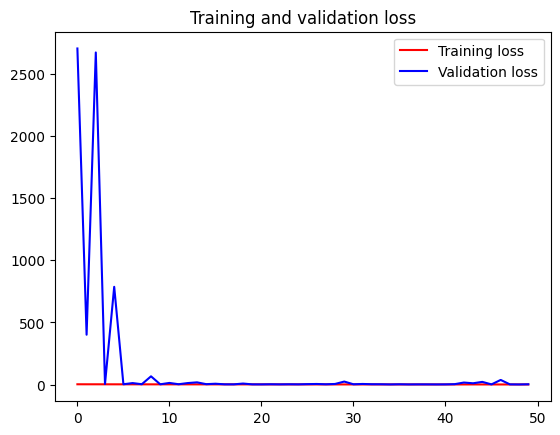

In [6]:
# test run, with cpu

# train_ds, val_ds, class_names, num_classes
# with tensorflow.device("/CPU:0"):
def exec_train_ResNet151V2():
    mod_name = "ResNet151V2"
    resnet_mod = create_model__resnetv2(num_classes)
    resnet_mod, hist = train_model(
        resnet_mod, model_name=mod_name, 
        train_ds=train_ds, val_ds=val_ds
    )
    view_train_chart(hist)
    os.makedirs("./models/img_clsr",exist_ok=True)
    
    test_model(resnet_mod, test_ds)
    resnet_mod.save(f"./models/img_clsr/{mod_name}.keras")

exec_train_ResNet151V2()


       0/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


   49152/87910968 ━━━━━━━━━━━━━━━━━━━━ 4:02 3us/step


   81920/87910968 ━━━━━━━━━━━━━━━━━━━━ 4:51 3us/step


  655360/87910968 ━━━━━━━━━━━━━━━━━━━━ 42s 0us/step 


 1228800/87910968 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


 1818624/87910968 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


 2416640/87910968 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


 3006464/87910968 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


 3596288/87910968 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


 4186112/87910968 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


 4775936/87910968 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


 5382144/87910968 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


 5971968/87910968 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


 6561792/87910968 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


 7151616/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step 


 7741440/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


 8331264/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


 8806400/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


 9379840/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


 9822208/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


10248192/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


10690560/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


11116544/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


11558912/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


11984896/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


12427264/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


12886016/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


13475840/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


14082048/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


14671872/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


15261696/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


15851520/87910968 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


16441344/87910968 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


17031168/87910968 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


17637376/87910968 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


18243584/87910968 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


18833408/87910968 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


19439616/87910968 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


20029440/87910968 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


20619264/87910968 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


21209088/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


21798912/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


22388736/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


22978560/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


23576576/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


24158208/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


24748032/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


25354240/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


25944064/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


26533888/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


27123712/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


27713536/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


28319744/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


28909568/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


29499392/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


30089216/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


30679040/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


31277056/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


31858688/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


32448512/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


33038336/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


33611776/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


34201600/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


34791424/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


35381248/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


35971072/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


36577280/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


37167104/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


37756928/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


38346752/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


38936576/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


39526400/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


40132608/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


40738816/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


41328640/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


41934848/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


42524672/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


43130880/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


43720704/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


44310528/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


44900352/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


45490176/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


46080000/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


46669824/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


47276032/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


47865856/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


48455680/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


49045504/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


49635328/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


50192384/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


50454528/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


50733056/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


51011584/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


51322880/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


51912704/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


52502528/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


53092352/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


53682176/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


54272000/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


54861824/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


55451648/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


56025088/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


56631296/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


57237504/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


57827328/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


58417152/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


59006976/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


59580416/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


60170240/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


60760064/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


61349888/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


61939712/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


62529536/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


63119360/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


63709184/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


64299008/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


64888832/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


65478656/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


66068480/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


66658304/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


67248128/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


67837952/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


68427776/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


69017600/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


69607424/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


70197248/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


70787072/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


71376896/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


71966720/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


72540160/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


73146368/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


73736192/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


74326016/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


74915840/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


75374592/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


75718656/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


76046336/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


76324864/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


76668928/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


77193216/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


77619200/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


77946880/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


78258176/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


78848000/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


79454208/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


80044032/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


80633856/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


81223680/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


81797120/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


82403328/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


82993152/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


83582976/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


84172800/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


84762624/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


85352448/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


85942272/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


86532096/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


87121920/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


87711744/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Epoch 1/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 31:22 19s/step - acc: 0.0000e+00 - loss: 3.0380


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.0000e+00 - loss: 3.8676  


  3/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 1s/step - acc: 0.0000e+00 - loss: 4.3057


  4/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.0050 - loss: 4.4756    


  5/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.0070 - loss: 4.5089


  6/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.0079 - loss: 4.4998


  7/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.0104 - loss: 4.4681


  8/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.0135 - loss: 4.4253


  9/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.0163 - loss: 4.3805


 10/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.0184 - loss: 4.3346


 11/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.0201 - loss: 4.2908


 12/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.0217 - loss: 4.2491


 13/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.0236 - loss: 4.2091


 14/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.0250 - loss: 4.1720


 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.0261 - loss: 4.1374


 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.0269 - loss: 4.1046


 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.0275 - loss: 4.0735


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.0280 - loss: 4.0443


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.0285 - loss: 4.0167


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.0292 - loss: 3.9905


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.0297 - loss: 3.9658


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.0302 - loss: 3.9425


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.0306 - loss: 3.9205


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.0310 - loss: 3.8996


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.0314 - loss: 3.8797


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.0318 - loss: 3.8607


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.0321 - loss: 3.8425


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.0323 - loss: 3.8252


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.0325 - loss: 3.8087


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.0329 - loss: 3.7930


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.0331 - loss: 3.7779


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.0334 - loss: 3.7634


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.0337 - loss: 3.7495


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.0339 - loss: 3.7361


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.0341 - loss: 3.7233


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.0343 - loss: 3.7110


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.0344 - loss: 3.6991


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.0346 - loss: 3.6877


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.0349 - loss: 3.6767


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.0351 - loss: 3.6661


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.0354 - loss: 3.6558


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.0358 - loss: 3.6459


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.0360 - loss: 3.6364


 44/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.0363 - loss: 3.6271


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.0365 - loss: 3.6182


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.0367 - loss: 3.6096


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.0369 - loss: 3.6012


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.0371 - loss: 3.5931


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.0373 - loss: 3.5852


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.0374 - loss: 3.5776


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.0376 - loss: 3.5702


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.0377 - loss: 3.5630


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.0379 - loss: 3.5560


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.0380 - loss: 3.5491


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.0381 - loss: 3.5425


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.0383 - loss: 3.5360


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.0384 - loss: 3.5298


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.0386 - loss: 3.5236


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.0387 - loss: 3.5177


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.0388 - loss: 3.5119


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.0389 - loss: 3.5062


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.0390 - loss: 3.5007


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.0391 - loss: 3.4953


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.0392 - loss: 3.4900


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.0393 - loss: 3.4849


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.0394 - loss: 3.4799


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.0395 - loss: 3.4750


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.0396 - loss: 3.4702


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - acc: 0.0396 - loss: 3.4655


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - acc: 0.0397 - loss: 3.4609


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - acc: 0.0398 - loss: 3.4565


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.0399 - loss: 3.4521


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.0399 - loss: 3.4478 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.0400 - loss: 3.4436


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.0400 - loss: 3.4395


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.0401 - loss: 3.4355


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.0401 - loss: 3.4315


 78/101 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - acc: 0.0402 - loss: 3.4276


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.0403 - loss: 3.4238


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.0403 - loss: 3.4201


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.0404 - loss: 3.4165


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.0404 - loss: 3.4129

2024-05-02 00:26:33.537326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/ghost/anaconda3/envs/uts-dl/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2024-05-02 00:26:44.804337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - acc: 0.0412 - loss: 3.3514 - val_acc: 0.0531 - val_loss: 5.0974


Epoch 2/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - acc: 0.0312 - loss: 2.9893


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.0312 - loss: 2.9927


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.0417 - loss: 2.9908


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.0488 - loss: 2.9888


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.0503 - loss: 2.9881


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.0506 - loss: 2.9876


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.0510 - loss: 2.9872


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.0510 - loss: 2.9873


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.0515 - loss: 2.9875


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.0523 - loss: 2.9876


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.0530 - loss: 2.9874


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.0538 - loss: 2.9874


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.0544 - loss: 2.9873


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.0552 - loss: 2.9872


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.0557 - loss: 2.9872


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.0558 - loss: 2.9874


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.0560 - loss: 2.9876


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.0562 - loss: 2.9877


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.0563 - loss: 2.9877


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.0564 - loss: 2.9878


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.0566 - loss: 2.9878


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.0567 - loss: 2.9879


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.0567 - loss: 2.9879


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.0567 - loss: 2.9879


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.0566 - loss: 2.9879


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.0565 - loss: 2.9879


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.0564 - loss: 2.9879


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.0563 - loss: 2.9879


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.0562 - loss: 2.9879


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.0560 - loss: 2.9881


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.0560 - loss: 2.9882


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.0560 - loss: 2.9884


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.0560 - loss: 2.9884


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.0561 - loss: 2.9885


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.0562 - loss: 2.9886


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.0563 - loss: 2.9887


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.0565 - loss: 2.9888


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.0566 - loss: 2.9889


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.0568 - loss: 2.9890


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.0569 - loss: 2.9890


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.0570 - loss: 2.9891


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.0572 - loss: 2.9891


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.0574 - loss: 2.9892


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.0575 - loss: 2.9893


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.0576 - loss: 2.9893


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.0578 - loss: 2.9894


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.0579 - loss: 2.9894


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.0581 - loss: 2.9894


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.0582 - loss: 2.9894


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.0584 - loss: 2.9894


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.0585 - loss: 2.9894


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.0586 - loss: 2.9894


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.0588 - loss: 2.9894


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.0589 - loss: 2.9894


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.0590 - loss: 2.9894


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.0591 - loss: 2.9893


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.0592 - loss: 2.9893


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.0594 - loss: 2.9893


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.0595 - loss: 2.9893


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.0596 - loss: 2.9893


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.0598 - loss: 2.9893


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.0599 - loss: 2.9893


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.0600 - loss: 2.9893


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.0602 - loss: 2.9892


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.0603 - loss: 2.9892


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.0604 - loss: 2.9892


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.0605 - loss: 2.9892


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.0606 - loss: 2.9892


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.0607 - loss: 2.9893


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.0608 - loss: 2.9893


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.0609 - loss: 2.9893


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.0610 - loss: 2.9893


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.0611 - loss: 2.9893 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.0612 - loss: 2.9893


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.0612 - loss: 2.9893


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.0613 - loss: 2.9893


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.0614 - loss: 2.9893


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.0615 - loss: 2.9893


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.0616 - loss: 2.9893


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.0616 - loss: 2.9893


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.0617 - loss: 2.9893


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.0618 - loss: 2.9893

2024-05-02 00:29:42.216908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-02 00:29:52.210252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.0626 - loss: 2.9826 - val_acc: 0.0609 - val_loss: 2.9372


Epoch 3/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 4s/step - acc: 0.0312 - loss: 3.0049


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.0391 - loss: 2.9961


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.0399 - loss: 2.9923


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.0397 - loss: 2.9927


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.0405 - loss: 2.9926


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.0424 - loss: 2.9918


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.0447 - loss: 2.9914


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.0459 - loss: 2.9908


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.0470 - loss: 2.9901


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.0479 - loss: 2.9896


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.0485 - loss: 2.9893


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.0492 - loss: 2.9888


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.0500 - loss: 2.9882


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.0514 - loss: 2.9875


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.0524 - loss: 2.9870


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.0534 - loss: 2.9866


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.0542 - loss: 2.9861


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.0548 - loss: 2.9858


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.0554 - loss: 2.9856


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.0558 - loss: 2.9853


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.0562 - loss: 2.9850


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.0563 - loss: 2.9846


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.0564 - loss: 2.9843


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.0566 - loss: 2.9838


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.0567 - loss: 2.9833


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.0570 - loss: 2.9827


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.0574 - loss: 2.9820


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.0578 - loss: 2.9813


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.0582 - loss: 2.9808


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.0586 - loss: 2.9803


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.0590 - loss: 2.9798


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.0594 - loss: 2.9795


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.0597 - loss: 2.9792


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.0600 - loss: 2.9789


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.0603 - loss: 2.9787


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.0606 - loss: 2.9783


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.0610 - loss: 2.9780


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.0613 - loss: 2.9777


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.0616 - loss: 2.9774


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.0620 - loss: 2.9770


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.0624 - loss: 2.9766


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.0627 - loss: 2.9761


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.0631 - loss: 2.9757


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.0634 - loss: 2.9753


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.0637 - loss: 2.9749


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.0639 - loss: 2.9747


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.0641 - loss: 2.9744


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.0644 - loss: 2.9742


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.0645 - loss: 2.9740


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.0647 - loss: 2.9738


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.0648 - loss: 2.9736


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.0649 - loss: 2.9734


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.0651 - loss: 2.9733


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.0652 - loss: 2.9731


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.0654 - loss: 2.9729


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.0655 - loss: 2.9728


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.0656 - loss: 2.9727


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.0657 - loss: 2.9726


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.0658 - loss: 2.9725


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.0659 - loss: 2.9724


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.0660 - loss: 2.9723


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.0661 - loss: 2.9722


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.0662 - loss: 2.9721


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.0663 - loss: 2.9720


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.0663 - loss: 2.9719


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.0664 - loss: 2.9718


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.0665 - loss: 2.9718


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.0665 - loss: 2.9717


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.0666 - loss: 2.9716


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.0666 - loss: 2.9716


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.0667 - loss: 2.9715


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.0667 - loss: 2.9714


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.0668 - loss: 2.9713 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.0668 - loss: 2.9712


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.0669 - loss: 2.9711


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.0669 - loss: 2.9710


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.0670 - loss: 2.9708


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.0670 - loss: 2.9707


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.0671 - loss: 2.9706


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.0671 - loss: 2.9705


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.0672 - loss: 2.9704


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.0673 - loss: 2.9702

2024-05-02 00:32:49.727996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.0683 - loss: 2.9615 - val_acc: 0.0547 - val_loss: 1557.5122


Epoch 4/50


2024-05-02 00:32:59.789573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - acc: 0.0625 - loss: 2.8901


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - acc: 0.0625 - loss: 2.8906


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.0625 - loss: 2.9066


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.0664 - loss: 2.9106


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.0706 - loss: 2.9092


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.0762 - loss: 2.9067


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.0806 - loss: 2.9041


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.0837 - loss: 2.9023


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.0860 - loss: 2.9000


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.0883 - loss: 2.8983


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.0894 - loss: 2.8996


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.0902 - loss: 2.9001


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.0908 - loss: 2.9018


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.0912 - loss: 2.9032


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.0919 - loss: 2.9042


 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.0925 - loss: 2.9058


 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.0933 - loss: 2.9071


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.0939 - loss: 2.9080


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.0944 - loss: 2.9088


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.0949 - loss: 2.9095


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.0952 - loss: 2.9102


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.0954 - loss: 2.9108


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.0955 - loss: 2.9111


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.0956 - loss: 2.9115


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.0956 - loss: 2.9119


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.0954 - loss: 2.9123


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.0954 - loss: 2.9125


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.0955 - loss: 2.9126


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.0956 - loss: 2.9126


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.0955 - loss: 2.9126


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.0956 - loss: 2.9125


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.0956 - loss: 2.9125


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.0956 - loss: 2.9125


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.0957 - loss: 2.9124


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.0957 - loss: 2.9123


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.0958 - loss: 2.9124


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.0959 - loss: 2.9124


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.0959 - loss: 2.9124


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.0960 - loss: 2.9123


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.0960 - loss: 2.9123


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.0961 - loss: 2.9122


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.0961 - loss: 2.9120


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.0962 - loss: 2.9118


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.0962 - loss: 2.9115


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.0963 - loss: 2.9113


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.0963 - loss: 2.9110


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.0963 - loss: 2.9108


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.0963 - loss: 2.9104


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.0964 - loss: 2.9100


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.0964 - loss: 2.9097


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.0965 - loss: 2.9094


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.0966 - loss: 2.9091


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.0966 - loss: 2.9090


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.0966 - loss: 2.9088


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.0966 - loss: 2.9087


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.0966 - loss: 2.9085


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.0967 - loss: 2.9084


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.0968 - loss: 2.9082


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.0968 - loss: 2.9081


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.0969 - loss: 2.9080


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.0969 - loss: 2.9080


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.0970 - loss: 2.9079


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.0970 - loss: 2.9079


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.0970 - loss: 2.9078


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.0970 - loss: 2.9078


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.0971 - loss: 2.9077


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.0971 - loss: 2.9076


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.0971 - loss: 2.9076


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.0971 - loss: 2.9075


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.0971 - loss: 2.9074


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.0971 - loss: 2.9072


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.0971 - loss: 2.9071


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.0971 - loss: 2.9069 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.0971 - loss: 2.9067


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.0971 - loss: 2.9065


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.0971 - loss: 2.9063


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.0971 - loss: 2.9061


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.0971 - loss: 2.9060


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.0971 - loss: 2.9059


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.0971 - loss: 2.9058


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.0970 - loss: 2.9056


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.0970 - loss: 2.9055

2024-05-02 00:35:56.713348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-02 00:36:06.676188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.0967 - loss: 2.8966 - val_acc: 0.1141 - val_loss: 2.7596


Epoch 5/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 4s/step - acc: 0.0625 - loss: 2.8979


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.0703 - loss: 2.8886


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.0781 - loss: 2.8673


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.0801 - loss: 2.8575


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.0791 - loss: 2.8536


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.0780 - loss: 2.8501


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.0777 - loss: 2.8471


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.0783 - loss: 2.8422


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.0788 - loss: 2.8374


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.0791 - loss: 2.8331


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.0796 - loss: 2.8299


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.0804 - loss: 2.8277


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.0812 - loss: 2.8260


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.0821 - loss: 2.8242


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.0829 - loss: 2.8226


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.0836 - loss: 2.8204


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.0842 - loss: 2.8183


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.0847 - loss: 2.8167


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.0853 - loss: 2.8150


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.0856 - loss: 2.8133


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.0861 - loss: 2.8117


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.0867 - loss: 2.8102


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.0872 - loss: 2.8088


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.0875 - loss: 2.8082


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.0879 - loss: 2.8077


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.0883 - loss: 2.8074


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.0887 - loss: 2.8071


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.0891 - loss: 2.8069


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.0896 - loss: 2.8069


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.0899 - loss: 2.8069


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.0903 - loss: 2.8070


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.0906 - loss: 2.8072


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.0910 - loss: 2.8073


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.0913 - loss: 2.8074


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.0916 - loss: 2.8074


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.0920 - loss: 2.8074


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.0923 - loss: 2.8073


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.0927 - loss: 2.8072


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.0931 - loss: 2.8070


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.0934 - loss: 2.8067


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.0937 - loss: 2.8065


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.0940 - loss: 2.8063


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.0942 - loss: 2.8061


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.0944 - loss: 2.8059


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.0947 - loss: 2.8057


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.0949 - loss: 2.8054


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.0951 - loss: 2.8052


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.0954 - loss: 2.8048


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.0956 - loss: 2.8045


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.0959 - loss: 2.8041


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.0961 - loss: 2.8038


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.0962 - loss: 2.8035


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.0964 - loss: 2.8032


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.0966 - loss: 2.8028


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.0967 - loss: 2.8025


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.0969 - loss: 2.8022


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.0970 - loss: 2.8019


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.0972 - loss: 2.8015


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.0973 - loss: 2.8011


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.0974 - loss: 2.8008


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.0975 - loss: 2.8004


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.0977 - loss: 2.8001


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.0978 - loss: 2.7997


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.0980 - loss: 2.7994


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.0981 - loss: 2.7990


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.0983 - loss: 2.7987


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.0984 - loss: 2.7984


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.0986 - loss: 2.7980


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.0987 - loss: 2.7977


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.0989 - loss: 2.7975


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - acc: 0.0990 - loss: 2.7972


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.0992 - loss: 2.7969


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.0993 - loss: 2.7967 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.0995 - loss: 2.7964


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.0996 - loss: 2.7962


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.0997 - loss: 2.7959


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.0998 - loss: 2.7957


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.0999 - loss: 2.7955


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.1000 - loss: 2.7953


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.1001 - loss: 2.7950


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.1003 - loss: 2.7948


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.1004 - loss: 2.7946

2024-05-02 00:39:03.430507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - acc: 0.1021 - loss: 2.7846 - val_acc: 0.0875 - val_loss: 2.8518


Epoch 6/50


2024-05-02 00:39:13.344093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 4s/step - acc: 0.2500 - loss: 2.6413


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.2500 - loss: 2.6369


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.2465 - loss: 2.6342


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.2415 - loss: 2.6390


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.2320 - loss: 2.6530


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.2237 - loss: 2.6599


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.2166 - loss: 2.6664


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.2110 - loss: 2.6695


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.2061 - loss: 2.6733


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.2027 - loss: 2.6752


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.1992 - loss: 2.6767


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.1959 - loss: 2.6788


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.1923 - loss: 2.6803


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.1894 - loss: 2.6808


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.1866 - loss: 2.6807


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.1840 - loss: 2.6803


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.1817 - loss: 2.6792


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.1797 - loss: 2.6779


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.1779 - loss: 2.6769


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.1762 - loss: 2.6759


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.1747 - loss: 2.6746


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.1732 - loss: 2.6740


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.1720 - loss: 2.6731


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.1708 - loss: 2.6722


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.1700 - loss: 2.6707


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.1692 - loss: 2.6694


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.1684 - loss: 2.6685


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.1677 - loss: 2.6677


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.1671 - loss: 2.6668


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.1664 - loss: 2.6661


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.1659 - loss: 2.6653


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.1655 - loss: 2.6643


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.1652 - loss: 2.6633


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.1649 - loss: 2.6624


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.1646 - loss: 2.6615


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.1643 - loss: 2.6606


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.1641 - loss: 2.6596


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.1639 - loss: 2.6586


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.1637 - loss: 2.6575


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.1635 - loss: 2.6563


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.1633 - loss: 2.6551


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.1631 - loss: 2.6540


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.1629 - loss: 2.6528


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.1627 - loss: 2.6517


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.1625 - loss: 2.6505


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.1623 - loss: 2.6493


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.1622 - loss: 2.6482


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.1621 - loss: 2.6471


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.1620 - loss: 2.6459


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.1619 - loss: 2.6448


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.1619 - loss: 2.6436


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.1619 - loss: 2.6424


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.1619 - loss: 2.6412


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.1619 - loss: 2.6400


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.1619 - loss: 2.6389


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.1619 - loss: 2.6377


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.1619 - loss: 2.6366


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.1619 - loss: 2.6355


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.1619 - loss: 2.6343


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.1619 - loss: 2.6332


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.1619 - loss: 2.6321


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.1619 - loss: 2.6312


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.1619 - loss: 2.6302


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.1618 - loss: 2.6293


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.1618 - loss: 2.6285


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.1618 - loss: 2.6277


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.1618 - loss: 2.6270


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.1618 - loss: 2.6263


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.1618 - loss: 2.6257


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.1617 - loss: 2.6252


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.1617 - loss: 2.6247


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.1616 - loss: 2.6242


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - acc: 0.1615 - loss: 2.6238


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.1614 - loss: 2.6233 


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.1613 - loss: 2.6229


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.1612 - loss: 2.6225


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.1611 - loss: 2.6221


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.1611 - loss: 2.6217


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.1610 - loss: 2.6213


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.1609 - loss: 2.6210


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.1608 - loss: 2.6206


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.1607 - loss: 2.6202

2024-05-02 00:42:10.661847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - acc: 0.1595 - loss: 2.6086 - val_acc: 0.1156 - val_loss: 4.6799


Epoch 7/50


2024-05-02 00:42:20.903021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - acc: 0.0312 - loss: 2.7849


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.0703 - loss: 2.7123


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.1059 - loss: 2.6681


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.1185 - loss: 2.6456


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.1285 - loss: 2.6352


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.1349 - loss: 2.6240


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.1379 - loss: 2.6189


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.1417 - loss: 2.6133


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.1441 - loss: 2.6076


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.1462 - loss: 2.6019


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.1482 - loss: 2.5973


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.1495 - loss: 2.5948


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.1498 - loss: 2.5918


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.1498 - loss: 2.5889


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.1494 - loss: 2.5874


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.1491 - loss: 2.5851


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.1491 - loss: 2.5818


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.1488 - loss: 2.5794


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.1486 - loss: 2.5770


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.1482 - loss: 2.5750


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.1480 - loss: 2.5726


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.1478 - loss: 2.5702


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.1479 - loss: 2.5678


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.1481 - loss: 2.5653


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.1482 - loss: 2.5627


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.1483 - loss: 2.5601


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.1484 - loss: 2.5573


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.1486 - loss: 2.5544


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.1487 - loss: 2.5516


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.1489 - loss: 2.5488


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.1490 - loss: 2.5462


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.1491 - loss: 2.5436


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.1493 - loss: 2.5409


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.1496 - loss: 2.5382


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.1500 - loss: 2.5355


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.1503 - loss: 2.5328


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.1506 - loss: 2.5303


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.1510 - loss: 2.5278


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.1513 - loss: 2.5255


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.1517 - loss: 2.5234


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.1519 - loss: 2.5215


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.1522 - loss: 2.5196


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.1524 - loss: 2.5178


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.1525 - loss: 2.5161


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.1527 - loss: 2.5146


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.1529 - loss: 2.5133


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.1530 - loss: 2.5120


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.1532 - loss: 2.5108


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.1533 - loss: 2.5096


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.1535 - loss: 2.5084


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.1536 - loss: 2.5072


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.1538 - loss: 2.5060


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.1540 - loss: 2.5048


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.1542 - loss: 2.5037


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.1544 - loss: 2.5027


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.1546 - loss: 2.5017


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.1548 - loss: 2.5006


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.1550 - loss: 2.4995


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.1553 - loss: 2.4984


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.1555 - loss: 2.4975


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.1558 - loss: 2.4965


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.1561 - loss: 2.4955


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.1564 - loss: 2.4945


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.1566 - loss: 2.4935


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.1569 - loss: 2.4926


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.1571 - loss: 2.4916


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.1574 - loss: 2.4908


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.1576 - loss: 2.4899


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.1579 - loss: 2.4891


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.1581 - loss: 2.4882


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.1583 - loss: 2.4874


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.1586 - loss: 2.4866


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.1588 - loss: 2.4859 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.1590 - loss: 2.4852


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.1593 - loss: 2.4845


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.1595 - loss: 2.4837


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.1597 - loss: 2.4830


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.1599 - loss: 2.4824


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.1602 - loss: 2.4817


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.1604 - loss: 2.4810


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.1606 - loss: 2.4803


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.1608 - loss: 2.4797

2024-05-02 00:45:17.751535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.1637 - loss: 2.4638 - val_acc: 0.1094 - val_loss: 3.3144


Epoch 8/50


2024-05-02 00:45:27.980198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 4s/step - acc: 0.2500 - loss: 2.3307


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.2344 - loss: 2.3488


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.2431 - loss: 2.3483


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.2428 - loss: 2.3669


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.2355 - loss: 2.3990


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.2293 - loss: 2.4232


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.2271 - loss: 2.4308


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.2266 - loss: 2.4306


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.2261 - loss: 2.4281


 10/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.2254 - loss: 2.4274


 11/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.2240 - loss: 2.4279


 12/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.2243 - loss: 2.4274


 13/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.2239 - loss: 2.4278


 14/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.2230 - loss: 2.4281


 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.2222 - loss: 2.4276


 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.2212 - loss: 2.4273


 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.2207 - loss: 2.4270


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.2201 - loss: 2.4269


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.2197 - loss: 2.4267


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.2192 - loss: 2.4273


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.2189 - loss: 2.4277


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.2185 - loss: 2.4279


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.2179 - loss: 2.4281


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.2174 - loss: 2.4280


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.2169 - loss: 2.4279


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.2162 - loss: 2.4277


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.2156 - loss: 2.4279


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.2150 - loss: 2.4278


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.2145 - loss: 2.4283


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.2140 - loss: 2.4286


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.2135 - loss: 2.4286


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.2130 - loss: 2.4286


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.2127 - loss: 2.4285


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.2124 - loss: 2.4283


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.2121 - loss: 2.4279


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.2118 - loss: 2.4276


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.2116 - loss: 2.4274


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.2113 - loss: 2.4269


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.2110 - loss: 2.4263


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.2107 - loss: 2.4259


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.2104 - loss: 2.4253


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.2102 - loss: 2.4246


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.2099 - loss: 2.4243


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.2097 - loss: 2.4239


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.2095 - loss: 2.4236


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.2093 - loss: 2.4233


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.2091 - loss: 2.4230


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.2090 - loss: 2.4227


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.2088 - loss: 2.4224


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.2086 - loss: 2.4220


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.2085 - loss: 2.4216


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.2083 - loss: 2.4212


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.2082 - loss: 2.4207


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.2080 - loss: 2.4203


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.2078 - loss: 2.4199


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.2077 - loss: 2.4195


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.2076 - loss: 2.4190


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.2075 - loss: 2.4186


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.2073 - loss: 2.4182


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.2073 - loss: 2.4178


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.2071 - loss: 2.4174


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.2070 - loss: 2.4170


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.2069 - loss: 2.4166


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.2068 - loss: 2.4162


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.2067 - loss: 2.4158


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.2066 - loss: 2.4153


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.2064 - loss: 2.4149


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.2063 - loss: 2.4145


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.2062 - loss: 2.4140


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.2061 - loss: 2.4136


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.2060 - loss: 2.4133


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.2059 - loss: 2.4130


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.2058 - loss: 2.4126 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.2058 - loss: 2.4123


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.2057 - loss: 2.4119


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.2056 - loss: 2.4115


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.2055 - loss: 2.4111


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.2055 - loss: 2.4107


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.2054 - loss: 2.4103


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.2054 - loss: 2.4098


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.2053 - loss: 2.4094


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.2053 - loss: 2.4089

2024-05-02 00:48:24.920842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.2050 - loss: 2.3963 - val_acc: 0.1656 - val_loss: 3.0042


Epoch 9/50


2024-05-02 00:48:34.947218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - acc: 0.2188 - loss: 2.1890


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - acc: 0.2422 - loss: 2.1823


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.2622 - loss: 2.1735


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.2650 - loss: 2.1748


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.2732 - loss: 2.1675


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.2806 - loss: 2.1565


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.2820 - loss: 2.1542


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.2804 - loss: 2.1587


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.2771 - loss: 2.1643


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.2747 - loss: 2.1668


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.2729 - loss: 2.1690


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.2706 - loss: 2.1721


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.2679 - loss: 2.1769


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.2653 - loss: 2.1816


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.2631 - loss: 2.1856


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.2613 - loss: 2.1891


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.2595 - loss: 2.1926


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.2584 - loss: 2.1947


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.2580 - loss: 2.1958


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.2574 - loss: 2.1970


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.2566 - loss: 2.1986


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.2558 - loss: 2.2007


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.2552 - loss: 2.2022


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.2547 - loss: 2.2036


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.2541 - loss: 2.2050


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.2536 - loss: 2.2071


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.2531 - loss: 2.2088


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.2527 - loss: 2.2106


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.2523 - loss: 2.2120


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.2521 - loss: 2.2133


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.2519 - loss: 2.2145


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.2517 - loss: 2.2161


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.2515 - loss: 2.2175


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.2513 - loss: 2.2187


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.2512 - loss: 2.2200


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.2511 - loss: 2.2209


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.2511 - loss: 2.2218


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.2510 - loss: 2.2226


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.2509 - loss: 2.2233


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.2509 - loss: 2.2239


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.2508 - loss: 2.2245


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.2508 - loss: 2.2250


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.2507 - loss: 2.2256


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.2506 - loss: 2.2260


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.2505 - loss: 2.2265


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.2503 - loss: 2.2269


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.2502 - loss: 2.2273


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.2501 - loss: 2.2277


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.2500 - loss: 2.2282


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.2499 - loss: 2.2286


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.2498 - loss: 2.2289


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.2497 - loss: 2.2292


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.2496 - loss: 2.2295


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.2495 - loss: 2.2297


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.2494 - loss: 2.2301


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.2493 - loss: 2.2304


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.2491 - loss: 2.2307


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.2490 - loss: 2.2310


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.2489 - loss: 2.2312


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.2487 - loss: 2.2316


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.2485 - loss: 2.2322


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.2484 - loss: 2.2326


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.2482 - loss: 2.2331


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.2480 - loss: 2.2337


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.2479 - loss: 2.2341


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.2477 - loss: 2.2345


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.2476 - loss: 2.2349


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.2474 - loss: 2.2353


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.2472 - loss: 2.2356


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.2471 - loss: 2.2359


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.2470 - loss: 2.2361


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.2469 - loss: 2.2364


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - acc: 0.2467 - loss: 2.2366


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.2466 - loss: 2.2369 


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.2465 - loss: 2.2371


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.2464 - loss: 2.2373


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.2464 - loss: 2.2374


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.2463 - loss: 2.2375


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.2463 - loss: 2.2376


 80/101 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - acc: 0.2463 - loss: 2.2376


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.2463 - loss: 2.2376


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.2462 - loss: 2.2377

2024-05-02 00:51:32.460983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - acc: 0.2459 - loss: 2.2334 - val_acc: 0.1703 - val_loss: 2.9901


Epoch 10/50


2024-05-02 00:51:42.583229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - acc: 0.2188 - loss: 2.1686


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.2266 - loss: 2.1554


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.2205 - loss: 2.1828


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.2201 - loss: 2.2008


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.2248 - loss: 2.2036


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.2299 - loss: 2.2064


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.2359 - loss: 2.2073


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.2406 - loss: 2.2058


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.2432 - loss: 2.2044


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.2448 - loss: 2.2029


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.2466 - loss: 2.2003


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.2480 - loss: 2.1977


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.2498 - loss: 2.1949


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.2512 - loss: 2.1929


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.2525 - loss: 2.1908


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.2536 - loss: 2.1886


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.2545 - loss: 2.1863


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.2556 - loss: 2.1836


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.2566 - loss: 2.1813


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.2573 - loss: 2.1795


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.2578 - loss: 2.1782


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.2586 - loss: 2.1765


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.2591 - loss: 2.1751


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.2596 - loss: 2.1739


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.2599 - loss: 2.1728


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.2603 - loss: 2.1718


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.2606 - loss: 2.1709


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.2608 - loss: 2.1706


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.2609 - loss: 2.1704


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.2610 - loss: 2.1703


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.2611 - loss: 2.1703


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.2614 - loss: 2.1698


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.2615 - loss: 2.1695


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.2615 - loss: 2.1700


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.2616 - loss: 2.1702


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.2616 - loss: 2.1705


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.2616 - loss: 2.1705


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.2617 - loss: 2.1704


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.2618 - loss: 2.1703


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.2619 - loss: 2.1703


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.2619 - loss: 2.1702


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.2620 - loss: 2.1701


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.2620 - loss: 2.1700


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.2621 - loss: 2.1698


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.2622 - loss: 2.1695


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.2623 - loss: 2.1694


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.2623 - loss: 2.1693


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.2623 - loss: 2.1693


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.2624 - loss: 2.1691


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.2624 - loss: 2.1689


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.2624 - loss: 2.1688


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.2624 - loss: 2.1687


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.2625 - loss: 2.1686


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.2625 - loss: 2.1685


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.2626 - loss: 2.1684


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.2627 - loss: 2.1683


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.2628 - loss: 2.1681


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.2628 - loss: 2.1681


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.2628 - loss: 2.1681


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.2627 - loss: 2.1682


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.2627 - loss: 2.1682


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.2627 - loss: 2.1682


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.2626 - loss: 2.1682


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.2626 - loss: 2.1682


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.2626 - loss: 2.1682


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.2626 - loss: 2.1682


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.2626 - loss: 2.1681


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.2626 - loss: 2.1680


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.2627 - loss: 2.1678


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.2627 - loss: 2.1677


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.2627 - loss: 2.1677


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.2627 - loss: 2.1676


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - acc: 0.2628 - loss: 2.1675


 74/101 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - acc: 0.2629 - loss: 2.1674 


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.2629 - loss: 2.1673


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.2630 - loss: 2.1671


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.2631 - loss: 2.1670


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.2631 - loss: 2.1668


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.2632 - loss: 2.1667


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.2632 - loss: 2.1666


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.2633 - loss: 2.1664


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.2633 - loss: 2.1663

2024-05-02 00:54:39.253004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-02 00:54:49.353850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.2639 - loss: 2.1591 - val_acc: 0.2328 - val_loss: 2.3638


Epoch 11/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - acc: 0.2500 - loss: 2.2361


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.2266 - loss: 2.2422


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.2170 - loss: 2.2861


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.2253 - loss: 2.2863


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.2302 - loss: 2.2862


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.2309 - loss: 2.2913


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.2311 - loss: 2.2963


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.2315 - loss: 2.2973


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.2328 - loss: 2.2959


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.2339 - loss: 2.2924


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.2346 - loss: 2.2894


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.2363 - loss: 2.2863


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.2375 - loss: 2.2846


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.2386 - loss: 2.2855


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.2393 - loss: 2.2861


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.2396 - loss: 2.2859


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.2398 - loss: 2.2854


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.2401 - loss: 2.2850


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.2405 - loss: 2.2834


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.2407 - loss: 2.2817


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.2411 - loss: 2.2795


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.2413 - loss: 2.2778


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.2417 - loss: 2.2756


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.2420 - loss: 2.2734


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.2420 - loss: 2.2717


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.2422 - loss: 2.2698


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.2425 - loss: 2.2675


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.2428 - loss: 2.2649


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.2432 - loss: 2.2624


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.2436 - loss: 2.2597


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.2442 - loss: 2.2571


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.2446 - loss: 2.2546


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.2451 - loss: 2.2521


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.2455 - loss: 2.2499


 35/101 ━━━━━━━━━━━━━━━━━━━━ 4:12 4s/step - acc: 0.2459 - loss: 2.2475


 36/101 ━━━━━━━━━━━━━━━━━━━━ 4:05 4s/step - acc: 0.2464 - loss: 2.2454


 37/101 ━━━━━━━━━━━━━━━━━━━━ 3:58 4s/step - acc: 0.2468 - loss: 2.2433


 38/101 ━━━━━━━━━━━━━━━━━━━━ 3:51 4s/step - acc: 0.2472 - loss: 2.2412


 39/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 4s/step - acc: 0.2475 - loss: 2.2393


 40/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 4s/step - acc: 0.2478 - loss: 2.2375


 41/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 4s/step - acc: 0.2480 - loss: 2.2359


 42/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 4s/step - acc: 0.2483 - loss: 2.2341


 43/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 3s/step - acc: 0.2487 - loss: 2.2323


 44/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 3s/step - acc: 0.2491 - loss: 2.2304


 45/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 3s/step - acc: 0.2494 - loss: 2.2287


 46/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 3s/step - acc: 0.2497 - loss: 2.2268


 47/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 3s/step - acc: 0.2501 - loss: 2.2250


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 3s/step - acc: 0.2504 - loss: 2.2231


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 3s/step - acc: 0.2508 - loss: 2.2213


 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 3s/step - acc: 0.2512 - loss: 2.2194


 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - acc: 0.2516 - loss: 2.2177


 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 3s/step - acc: 0.2519 - loss: 2.2161


 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 3s/step - acc: 0.2523 - loss: 2.2146


 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 3s/step - acc: 0.2527 - loss: 2.2132


 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 3s/step - acc: 0.2530 - loss: 2.2118


 56/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 3s/step - acc: 0.2534 - loss: 2.2104


 57/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 3s/step - acc: 0.2537 - loss: 2.2092


 58/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 3s/step - acc: 0.2540 - loss: 2.2081


 59/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 3s/step - acc: 0.2543 - loss: 2.2070


 60/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 3s/step - acc: 0.2546 - loss: 2.2060


 61/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 3s/step - acc: 0.2548 - loss: 2.2051


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 3s/step - acc: 0.2551 - loss: 2.2043


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 3s/step - acc: 0.2553 - loss: 2.2035


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 3s/step - acc: 0.2555 - loss: 2.2027


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 3s/step - acc: 0.2558 - loss: 2.2020


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 3s/step - acc: 0.2560 - loss: 2.2013


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 3s/step - acc: 0.2563 - loss: 2.2005


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 3s/step - acc: 0.2565 - loss: 2.1998


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 3s/step - acc: 0.2567 - loss: 2.1991


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 3s/step - acc: 0.2570 - loss: 2.1985


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 3s/step - acc: 0.2572 - loss: 2.1980


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 3s/step - acc: 0.2574 - loss: 2.1975


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 3s/step - acc: 0.2576 - loss: 2.1970


 74/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 3s/step - acc: 0.2578 - loss: 2.1965


 75/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 3s/step - acc: 0.2580 - loss: 2.1960


 76/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 3s/step - acc: 0.2582 - loss: 2.1955


 77/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 3s/step - acc: 0.2584 - loss: 2.1950


 78/101 ━━━━━━━━━━━━━━━━━━━━ 1:05 3s/step - acc: 0.2586 - loss: 2.1945


 79/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 3s/step - acc: 0.2589 - loss: 2.1940


 80/101 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - acc: 0.2591 - loss: 2.1936 


 81/101 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - acc: 0.2593 - loss: 2.1931


 82/101 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - acc: 0.2595 - loss: 2.1926

2024-05-02 00:58:41.293392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - acc: 0.2627 - loss: 2.1800 - val_acc: 0.1781 - val_loss: 2.9787


Epoch 12/50


2024-05-02 00:58:51.251450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 4s/step - acc: 0.4062 - loss: 1.8227


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.3906 - loss: 1.8391


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.3819 - loss: 1.8572


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.3802 - loss: 1.8729


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.3792 - loss: 1.8816


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.3776 - loss: 1.8905


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.3753 - loss: 1.9004


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.3723 - loss: 1.9097


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.3688 - loss: 1.9171


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.3660 - loss: 1.9211


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.3632 - loss: 1.9241


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.3598 - loss: 1.9312


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.3565 - loss: 1.9380


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.3540 - loss: 1.9438


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.3518 - loss: 1.9482


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.3495 - loss: 1.9536


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.3474 - loss: 1.9576


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.3461 - loss: 1.9609


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.3449 - loss: 1.9639


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.3437 - loss: 1.9665


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.3428 - loss: 1.9682


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.3422 - loss: 1.9695


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.3413 - loss: 1.9709


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.3407 - loss: 1.9718


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.3402 - loss: 1.9727


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.3396 - loss: 1.9735


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.3391 - loss: 1.9744


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.3385 - loss: 1.9752


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.3380 - loss: 1.9762


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.3374 - loss: 1.9770


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.3368 - loss: 1.9776


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.3364 - loss: 1.9784


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.3360 - loss: 1.9789


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.3356 - loss: 1.9792


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.3354 - loss: 1.9795


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.3352 - loss: 1.9799


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.3350 - loss: 1.9802


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.3347 - loss: 1.9808


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.3344 - loss: 1.9812


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.3341 - loss: 1.9816


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.3339 - loss: 1.9819


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.3338 - loss: 1.9820


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.3336 - loss: 1.9821


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.3334 - loss: 1.9821


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.3333 - loss: 1.9822


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.3332 - loss: 1.9822


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.3332 - loss: 1.9823


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.3331 - loss: 1.9823


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.3331 - loss: 1.9824


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.3330 - loss: 1.9825


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.3329 - loss: 1.9826


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.3328 - loss: 1.9826


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.3327 - loss: 1.9826


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.3327 - loss: 1.9827


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.3327 - loss: 1.9827


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.3327 - loss: 1.9826


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.3326 - loss: 1.9826


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.3326 - loss: 1.9826


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.3325 - loss: 1.9826


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.3325 - loss: 1.9825


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.3324 - loss: 1.9825


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.3324 - loss: 1.9825


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.3324 - loss: 1.9824


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.3324 - loss: 1.9824


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.3324 - loss: 1.9824


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.3325 - loss: 1.9824


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.3325 - loss: 1.9829


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.3325 - loss: 1.9834


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.3324 - loss: 1.9838


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.3324 - loss: 1.9843


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - acc: 0.3323 - loss: 1.9849


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.3322 - loss: 1.9855


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.3322 - loss: 1.9861 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.3321 - loss: 1.9867


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.3319 - loss: 1.9873


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.3318 - loss: 1.9880


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.3317 - loss: 1.9886


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.3316 - loss: 1.9892


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.3315 - loss: 1.9899


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.3314 - loss: 1.9906


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.3313 - loss: 1.9912


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.3312 - loss: 1.9919

2024-05-02 01:01:47.809236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.3298 - loss: 1.9971 - val_acc: 0.0812 - val_loss: 9.2649


Epoch 13/50


2024-05-02 01:01:57.919886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 4s/step - acc: 0.3438 - loss: 2.2162


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:42 2s/step - acc: 0.3516 - loss: 2.0842


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.3559 - loss: 2.0535


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.3529 - loss: 2.0485


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.3460 - loss: 2.0550


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.3431 - loss: 2.0506


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.3400 - loss: 2.0502


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.3370 - loss: 2.0492


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.3343 - loss: 2.0481


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.3334 - loss: 2.0458


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.3341 - loss: 2.0413


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.3346 - loss: 2.0378


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.3355 - loss: 2.0330


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.3366 - loss: 2.0285


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.3373 - loss: 2.0236


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.3381 - loss: 2.0192


 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.3386 - loss: 2.0168


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.3393 - loss: 2.0139


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.3396 - loss: 2.0111


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.3394 - loss: 2.0087


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.3389 - loss: 2.0069


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.3385 - loss: 2.0052


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.3382 - loss: 2.0035


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.3379 - loss: 2.0017


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.3376 - loss: 2.0003


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.3372 - loss: 1.9991


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.3369 - loss: 1.9980


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.3363 - loss: 1.9977


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.3358 - loss: 1.9974


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.3352 - loss: 1.9971


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.3348 - loss: 1.9969


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.3343 - loss: 1.9972


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.3337 - loss: 1.9974


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.3331 - loss: 1.9979


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.3325 - loss: 1.9986


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.3319 - loss: 1.9994


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.3314 - loss: 2.0000


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.3309 - loss: 2.0008


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.3304 - loss: 2.0015


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.3299 - loss: 2.0022


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.3295 - loss: 2.0028


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.3290 - loss: 2.0035


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.3285 - loss: 2.0042


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.3280 - loss: 2.0050


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.3274 - loss: 2.0057


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.3269 - loss: 2.0063


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.3264 - loss: 2.0069


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.3259 - loss: 2.0075


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.3254 - loss: 2.0080


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.3249 - loss: 2.0085


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.3244 - loss: 2.0091


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.3239 - loss: 2.0096


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.3234 - loss: 2.0101


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.3230 - loss: 2.0106


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.3225 - loss: 2.0111


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.3221 - loss: 2.0115


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.3216 - loss: 2.0119


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.3213 - loss: 2.0122


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.3210 - loss: 2.0124


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.3207 - loss: 2.0126


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.3204 - loss: 2.0128


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.3201 - loss: 2.0130


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.3199 - loss: 2.0131


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.3197 - loss: 2.0132


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.3195 - loss: 2.0133


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.3193 - loss: 2.0134


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.3191 - loss: 2.0135


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.3189 - loss: 2.0138


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.3187 - loss: 2.0140


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.3186 - loss: 2.0141


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.3185 - loss: 2.0143


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.3183 - loss: 2.0144


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.3182 - loss: 2.0144 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.3182 - loss: 2.0144


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.3181 - loss: 2.0144


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.3180 - loss: 2.0143


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.3179 - loss: 2.0143


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.3178 - loss: 2.0142


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.3177 - loss: 2.0142


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.3177 - loss: 2.0141


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.3176 - loss: 2.0141


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.3176 - loss: 2.0140

2024-05-02 01:04:54.608357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.3168 - loss: 2.0084 - val_acc: 0.2625 - val_loss: 2.4274


Epoch 14/50


2024-05-02 01:05:04.634969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - acc: 0.5000 - loss: 1.4301


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.4766 - loss: 1.4782


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.4531 - loss: 1.5334


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.4414 - loss: 1.5661


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.4319 - loss: 1.5966


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.4241 - loss: 1.6328


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.4171 - loss: 1.6629


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.4109 - loss: 1.6880


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.4061 - loss: 1.7089


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.4027 - loss: 1.7236


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.3994 - loss: 1.7364


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.3969 - loss: 1.7488


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.3949 - loss: 1.7589


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.3928 - loss: 1.7683


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.3911 - loss: 1.7771


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.3888 - loss: 1.7854


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.3874 - loss: 1.7918


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.3863 - loss: 1.7974


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.3855 - loss: 1.8028


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.3847 - loss: 1.8075


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.3840 - loss: 1.8125


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.3837 - loss: 1.8167


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.3832 - loss: 1.8203


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.3826 - loss: 1.8246


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.3820 - loss: 1.8284


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.3814 - loss: 1.8319


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.3808 - loss: 1.8356


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.3801 - loss: 1.8390


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.3796 - loss: 1.8420


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.3790 - loss: 1.8449


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.3784 - loss: 1.8477


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.3778 - loss: 1.8504


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.3773 - loss: 1.8528


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.3767 - loss: 1.8550


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.3761 - loss: 1.8571


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.3755 - loss: 1.8590


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.3750 - loss: 1.8608


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.3745 - loss: 1.8624


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.3740 - loss: 1.8639


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.3735 - loss: 1.8652


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.3731 - loss: 1.8663


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.3727 - loss: 1.8672


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.3723 - loss: 1.8682


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.3718 - loss: 1.8691


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.3714 - loss: 1.8699


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.3710 - loss: 1.8708


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.3706 - loss: 1.8719


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.3702 - loss: 1.8729


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.3698 - loss: 1.8739


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.3694 - loss: 1.8749


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.3690 - loss: 1.8757


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.3686 - loss: 1.8765


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.3682 - loss: 1.8776


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.3678 - loss: 1.8787


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.3674 - loss: 1.8797


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.3670 - loss: 1.8806


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.3667 - loss: 1.8814


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.3664 - loss: 1.8821


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.3660 - loss: 1.8829


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.3657 - loss: 1.8836


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.3655 - loss: 1.8843


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.3652 - loss: 1.8850


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.3649 - loss: 1.8856


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.3646 - loss: 1.8862


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.3644 - loss: 1.8868


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.3641 - loss: 1.8876


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.3638 - loss: 1.8883


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.3635 - loss: 1.8890


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.3633 - loss: 1.8897


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.3630 - loss: 1.8903


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.3628 - loss: 1.8910


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.3626 - loss: 1.8915


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.3623 - loss: 1.8921 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.3621 - loss: 1.8926


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.3619 - loss: 1.8932


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.3616 - loss: 1.8938


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.3614 - loss: 1.8943


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.3612 - loss: 1.8948


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.3610 - loss: 1.8952


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.3608 - loss: 1.8957


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.3606 - loss: 1.8962


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.3604 - loss: 1.8966

2024-05-02 01:08:01.851526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-02 01:08:11.991810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - acc: 0.3575 - loss: 1.8988 - val_acc: 0.3094 - val_loss: 2.2156


Epoch 15/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:00 4s/step - acc: 0.4375 - loss: 1.7148


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.4219 - loss: 1.6852


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.4375 - loss: 1.6512


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.4395 - loss: 1.6500


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.4403 - loss: 1.6560


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.4433 - loss: 1.6594


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.4425 - loss: 1.6626


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.4409 - loss: 1.6667


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.4386 - loss: 1.6704


 10/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.4362 - loss: 1.6765


 11/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.4344 - loss: 1.6809


 12/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.4328 - loss: 1.6857


 13/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.4309 - loss: 1.6911


 14/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.4281 - loss: 1.6968


 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.4262 - loss: 1.7010


 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.4244 - loss: 1.7053


 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.4228 - loss: 1.7088


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.4219 - loss: 1.7113


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.4205 - loss: 1.7140


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.4191 - loss: 1.7171


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.4179 - loss: 1.7206


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.4163 - loss: 1.7250


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.4146 - loss: 1.7296


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.4129 - loss: 1.7343


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.4111 - loss: 1.7392


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.4095 - loss: 1.7437


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.4079 - loss: 1.7482


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.4063 - loss: 1.7528


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.4048 - loss: 1.7572


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.4036 - loss: 1.7611


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.4025 - loss: 1.7646


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.4015 - loss: 1.7684


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.4005 - loss: 1.7722


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.3998 - loss: 1.7754


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.3992 - loss: 1.7782


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.3987 - loss: 1.7809


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.3983 - loss: 1.7834


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.3980 - loss: 1.7857


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.3977 - loss: 1.7877


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.3974 - loss: 1.7896


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.3971 - loss: 1.7915


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.3968 - loss: 1.7931


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.3965 - loss: 1.7948


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.3962 - loss: 1.7965


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.3959 - loss: 1.7980


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.3956 - loss: 1.7994


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.3954 - loss: 1.8007


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.3951 - loss: 1.8019


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.3948 - loss: 1.8030


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.3945 - loss: 1.8040


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.3943 - loss: 1.8050


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.3940 - loss: 1.8060


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.3937 - loss: 1.8069


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.3934 - loss: 1.8077


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.3931 - loss: 1.8086


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.3927 - loss: 1.8095


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.3924 - loss: 1.8102


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.3921 - loss: 1.8110


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.3918 - loss: 1.8116


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.3915 - loss: 1.8123


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.3912 - loss: 1.8128


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.3910 - loss: 1.8134


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.3907 - loss: 1.8139


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.3905 - loss: 1.8142


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.3903 - loss: 1.8146


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.3901 - loss: 1.8150


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.3900 - loss: 1.8153


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.3898 - loss: 1.8155


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.3897 - loss: 1.8158


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.3895 - loss: 1.8160


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.3894 - loss: 1.8163


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.3893 - loss: 1.8165


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.3892 - loss: 1.8167 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.3891 - loss: 1.8169


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.3890 - loss: 1.8171


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.3890 - loss: 1.8172


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.3889 - loss: 1.8174


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.3888 - loss: 1.8177


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.3887 - loss: 1.8179


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.3886 - loss: 1.8181


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.3884 - loss: 1.8184


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.3883 - loss: 1.8187

2024-05-02 01:11:08.974077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.3862 - loss: 1.8190 - val_acc: 0.2625 - val_loss: 2.7873


Epoch 16/50


2024-05-02 01:11:19.062626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - acc: 0.2812 - loss: 1.8619


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.2891 - loss: 1.8654


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.2865 - loss: 1.9169


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.2871 - loss: 1.9598


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.2859 - loss: 1.9793


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.2869 - loss: 1.9842


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.2867 - loss: 1.9844


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.2890 - loss: 1.9800


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.2924 - loss: 1.9714


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.2959 - loss: 1.9642


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.2998 - loss: 1.9571


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.3026 - loss: 1.9508


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.3050 - loss: 1.9454


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.3060 - loss: 1.9442


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.3071 - loss: 1.9434


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.3083 - loss: 1.9429


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.3098 - loss: 1.9418


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.3115 - loss: 1.9402


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.3132 - loss: 1.9388


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.3145 - loss: 1.9370


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.3155 - loss: 1.9357


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.3165 - loss: 1.9341


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.3173 - loss: 1.9328


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.3180 - loss: 1.9315


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.3188 - loss: 1.9300


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.3198 - loss: 1.9282


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.3206 - loss: 1.9266


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.3217 - loss: 1.9250


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.3227 - loss: 1.9233


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.3238 - loss: 1.9211


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.3249 - loss: 1.9189


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.3258 - loss: 1.9172


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.3267 - loss: 1.9153


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.3275 - loss: 1.9134


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.3284 - loss: 1.9116


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.3292 - loss: 1.9100


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.3300 - loss: 1.9080


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.3308 - loss: 1.9062


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.3314 - loss: 1.9048


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.3322 - loss: 1.9031


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.3329 - loss: 1.9017


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.3336 - loss: 1.9002


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.3342 - loss: 1.8988


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.3348 - loss: 1.8977


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.3353 - loss: 1.8966


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.3358 - loss: 1.8957


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.3363 - loss: 1.8948


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.3368 - loss: 1.8940


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.3372 - loss: 1.8930


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.3376 - loss: 1.8922


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.3380 - loss: 1.8914


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.3383 - loss: 1.8905


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.3386 - loss: 1.8898


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.3389 - loss: 1.8891


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.3392 - loss: 1.8884


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.3395 - loss: 1.8876


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.3398 - loss: 1.8869


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.3401 - loss: 1.8861


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.3403 - loss: 1.8854


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.3406 - loss: 1.8846


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.3409 - loss: 1.8839


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.3411 - loss: 1.8832


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.3414 - loss: 1.8825


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.3417 - loss: 1.8818


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.3420 - loss: 1.8811


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.3423 - loss: 1.8803


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.3427 - loss: 1.8795


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.3430 - loss: 1.8787


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.3433 - loss: 1.8780


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.3436 - loss: 1.8772


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.3439 - loss: 1.8766


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.3442 - loss: 1.8759


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.3445 - loss: 1.8752 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.3447 - loss: 1.8746


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.3450 - loss: 1.8740


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.3453 - loss: 1.8735


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.3455 - loss: 1.8730


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.3458 - loss: 1.8724


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.3460 - loss: 1.8719


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.3463 - loss: 1.8713


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.3466 - loss: 1.8707


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.3469 - loss: 1.8701

2024-05-02 01:14:16.331184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.3518 - loss: 1.8564 - val_acc: 0.2750 - val_loss: 2.6377


Epoch 17/50


2024-05-02 01:14:26.369604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - acc: 0.5312 - loss: 1.3443


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.4688 - loss: 1.4185


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.4410 - loss: 1.4745


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.4206 - loss: 1.5184


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.4215 - loss: 1.5259


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.4181 - loss: 1.5397


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.4183 - loss: 1.5487


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.4178 - loss: 1.5636


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.4192 - loss: 1.5718


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.4201 - loss: 1.5773


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.4188 - loss: 1.5891


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.4171 - loss: 1.6001


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4159 - loss: 1.6092


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.4146 - loss: 1.6180


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.4138 - loss: 1.6250


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.4130 - loss: 1.6315


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.4127 - loss: 1.6371


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.4121 - loss: 1.6434


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.4114 - loss: 1.6486


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.4103 - loss: 1.6548


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.4092 - loss: 1.6606


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.4082 - loss: 1.6657


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.4075 - loss: 1.6702


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.4070 - loss: 1.6742


 25/101 ━━━━━━━━━━━━━━━━━━━━ 3:42 3s/step - acc: 0.4066 - loss: 1.6775


 26/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 3s/step - acc: 0.4061 - loss: 1.6808


 27/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 3s/step - acc: 0.4057 - loss: 1.6838


 28/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 3s/step - acc: 0.4057 - loss: 1.6861


 29/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 3s/step - acc: 0.4056 - loss: 1.6886


 30/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 3s/step - acc: 0.4056 - loss: 1.6908


 31/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 3s/step - acc: 0.4058 - loss: 1.6928


 32/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 3s/step - acc: 0.4060 - loss: 1.6944


 33/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 3s/step - acc: 0.4063 - loss: 1.6960


 34/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 3s/step - acc: 0.4067 - loss: 1.6972


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 3s/step - acc: 0.4069 - loss: 1.6985


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 3s/step - acc: 0.4071 - loss: 1.6998


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 3s/step - acc: 0.4073 - loss: 1.7008


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 3s/step - acc: 0.4075 - loss: 1.7018


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - acc: 0.4077 - loss: 1.7029


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - acc: 0.4077 - loss: 1.7041


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 3s/step - acc: 0.4078 - loss: 1.7053


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 3s/step - acc: 0.4079 - loss: 1.7063


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 3s/step - acc: 0.4081 - loss: 1.7073


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 3s/step - acc: 0.4082 - loss: 1.7082


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 3s/step - acc: 0.4083 - loss: 1.7090


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 3s/step - acc: 0.4083 - loss: 1.7098


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 3s/step - acc: 0.4084 - loss: 1.7104


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 3s/step - acc: 0.4085 - loss: 1.7111


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 3s/step - acc: 0.4084 - loss: 1.7119


 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 3s/step - acc: 0.4084 - loss: 1.7129


 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 3s/step - acc: 0.4082 - loss: 1.7139


 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 3s/step - acc: 0.4082 - loss: 1.7148


 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 3s/step - acc: 0.4081 - loss: 1.7158


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.4079 - loss: 1.7168


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.4078 - loss: 1.7178


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.4076 - loss: 1.7188


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.4075 - loss: 1.7197


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.4074 - loss: 1.7206


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.4072 - loss: 1.7214


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.4070 - loss: 1.7224


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.4069 - loss: 1.7233


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.4067 - loss: 1.7245


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.4065 - loss: 1.7255


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.4064 - loss: 1.7265


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.4063 - loss: 1.7276


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.4061 - loss: 1.7287


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.4059 - loss: 1.7298


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.4058 - loss: 1.7309


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.4056 - loss: 1.7319


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.4054 - loss: 1.7329


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.4052 - loss: 1.7338


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.4050 - loss: 1.7347


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.4049 - loss: 1.7355


 74/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.4048 - loss: 1.7363


 75/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.4046 - loss: 1.7370


 76/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.4045 - loss: 1.7377 


 77/101 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - acc: 0.4043 - loss: 1.7384


 78/101 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - acc: 0.4042 - loss: 1.7391


 79/101 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - acc: 0.4041 - loss: 1.7397


 80/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.4040 - loss: 1.7403


 81/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.4039 - loss: 1.7408


 82/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.4037 - loss: 1.7414

2024-05-02 01:17:41.274434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - acc: 0.4020 - loss: 1.7453 - val_acc: 0.3141 - val_loss: 2.3523


Epoch 18/50


2024-05-02 01:17:51.377476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - acc: 0.4062 - loss: 1.8543


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.3828 - loss: 1.9890


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.4010 - loss: 1.9745


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.4062 - loss: 1.9450


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.4062 - loss: 1.9228


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.4123 - loss: 1.8909


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.4191 - loss: 1.8598


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.4234 - loss: 1.8397


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.4253 - loss: 1.8214


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.4265 - loss: 1.8069


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.4283 - loss: 1.7932


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.4299 - loss: 1.7829


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.4311 - loss: 1.7736


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.4312 - loss: 1.7693


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.4314 - loss: 1.7647


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.4315 - loss: 1.7597


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.4315 - loss: 1.7560


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.4319 - loss: 1.7524


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.4322 - loss: 1.7482


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.4322 - loss: 1.7443


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.4321 - loss: 1.7407


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.4318 - loss: 1.7381


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.4315 - loss: 1.7354


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.4313 - loss: 1.7327


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.4312 - loss: 1.7304


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.4311 - loss: 1.7285


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.4310 - loss: 1.7267


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.4308 - loss: 1.7252


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.4305 - loss: 1.7249


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.4302 - loss: 1.7249


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.4298 - loss: 1.7248


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.4294 - loss: 1.7246


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.4290 - loss: 1.7244


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.4286 - loss: 1.7243


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.4280 - loss: 1.7245


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.4275 - loss: 1.7246


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.4268 - loss: 1.7248


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.4262 - loss: 1.7250


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.4257 - loss: 1.7251


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.4252 - loss: 1.7256


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.4246 - loss: 1.7259


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.4241 - loss: 1.7263


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.4235 - loss: 1.7269


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.4229 - loss: 1.7279


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.4224 - loss: 1.7287


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.4218 - loss: 1.7297


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.4212 - loss: 1.7307


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.4208 - loss: 1.7314


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.4203 - loss: 1.7321


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.4199 - loss: 1.7329


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.4195 - loss: 1.7337


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.4191 - loss: 1.7345


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.4187 - loss: 1.7354


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.4182 - loss: 1.7363


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.4177 - loss: 1.7370


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.4172 - loss: 1.7377


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.4168 - loss: 1.7383


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.4164 - loss: 1.7389


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.4160 - loss: 1.7394


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.4156 - loss: 1.7399


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.4152 - loss: 1.7404


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.4148 - loss: 1.7410


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.4145 - loss: 1.7415


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.4142 - loss: 1.7420


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.4138 - loss: 1.7424


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.4135 - loss: 1.7429


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.4132 - loss: 1.7434


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.4129 - loss: 1.7438


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.4126 - loss: 1.7443


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.4123 - loss: 1.7447


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - acc: 0.4120 - loss: 1.7451


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.4117 - loss: 1.7454


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.4115 - loss: 1.7456 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.4114 - loss: 1.7458


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.4112 - loss: 1.7460


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.4110 - loss: 1.7462


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.4108 - loss: 1.7464


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.4106 - loss: 1.7466


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.4104 - loss: 1.7467


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.4103 - loss: 1.7469


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.4101 - loss: 1.7471


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.4099 - loss: 1.7473

2024-05-02 01:20:48.037318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.4074 - loss: 1.7455 - val_acc: 0.2750 - val_loss: 2.5912


Epoch 19/50


2024-05-02 01:20:58.173623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - acc: 0.5938 - loss: 1.2665


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.5391 - loss: 1.5130


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.5122 - loss: 1.5667


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.4915 - loss: 1.6050


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.4770 - loss: 1.6348


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.4652 - loss: 1.6622


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.4593 - loss: 1.6743


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.4546 - loss: 1.6829


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.4504 - loss: 1.6897


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.4460 - loss: 1.6963


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.4434 - loss: 1.6977


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.4408 - loss: 1.6985


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4388 - loss: 1.7007


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.4373 - loss: 1.7030


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.4361 - loss: 1.7043


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.4352 - loss: 1.7050


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.4347 - loss: 1.7057


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.4341 - loss: 1.7061


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.4332 - loss: 1.7069


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.4321 - loss: 1.7081


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.4309 - loss: 1.7090


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.4298 - loss: 1.7103


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.4291 - loss: 1.7108


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.4282 - loss: 1.7111


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.4273 - loss: 1.7117


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.4265 - loss: 1.7120


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.4258 - loss: 1.7125


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.4251 - loss: 1.7131


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.4243 - loss: 1.7140


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.4236 - loss: 1.7152


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.4227 - loss: 1.7163


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.4219 - loss: 1.7175


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.4212 - loss: 1.7184


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.4204 - loss: 1.7192


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.4196 - loss: 1.7199


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.4190 - loss: 1.7203


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.4184 - loss: 1.7205


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.4178 - loss: 1.7209


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.4172 - loss: 1.7212


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.4167 - loss: 1.7214


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.4162 - loss: 1.7215


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.4156 - loss: 1.7215


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.4151 - loss: 1.7215


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.4147 - loss: 1.7216


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.4143 - loss: 1.7217


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.4140 - loss: 1.7216


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.4137 - loss: 1.7215


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.4134 - loss: 1.7215


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.4132 - loss: 1.7215


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.4130 - loss: 1.7215


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.4128 - loss: 1.7214


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.4127 - loss: 1.7213


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.4126 - loss: 1.7212


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.4125 - loss: 1.7211


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.4124 - loss: 1.7209


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.4124 - loss: 1.7206


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.4123 - loss: 1.7206


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.4122 - loss: 1.7204


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.4121 - loss: 1.7203


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.4121 - loss: 1.7202


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.4121 - loss: 1.7200


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.4121 - loss: 1.7198


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.4120 - loss: 1.7197


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.4120 - loss: 1.7195


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.4120 - loss: 1.7193


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.4120 - loss: 1.7191


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.4120 - loss: 1.7188


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.4121 - loss: 1.7185


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.4121 - loss: 1.7182


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - acc: 0.4121 - loss: 1.7179


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.4122 - loss: 1.7177


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.4122 - loss: 1.7176


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.4122 - loss: 1.7175 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.4122 - loss: 1.7174


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.4122 - loss: 1.7172


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.4122 - loss: 1.7171


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.4122 - loss: 1.7170


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.4122 - loss: 1.7170


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.4122 - loss: 1.7170


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.4122 - loss: 1.7170


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.4122 - loss: 1.7170


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.4122 - loss: 1.7169

2024-05-02 01:23:55.526024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-02 01:24:05.684438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - acc: 0.4123 - loss: 1.7126 - val_acc: 0.3344 - val_loss: 1.8824


Epoch 20/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - acc: 0.3750 - loss: 1.7324


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.4297 - loss: 1.6491


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.4358 - loss: 1.6482


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.4401 - loss: 1.6521


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.4433 - loss: 1.6495


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.4441 - loss: 1.6466


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.4419 - loss: 1.6515


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.4404 - loss: 1.6589


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.4377 - loss: 1.6652


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.4361 - loss: 1.6683


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.4342 - loss: 1.6710


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.4317 - loss: 1.6741


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.4293 - loss: 1.6759


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.4272 - loss: 1.6776


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.4252 - loss: 1.6804


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.4237 - loss: 1.6834


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.4226 - loss: 1.6851


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.4215 - loss: 1.6865


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.4207 - loss: 1.6882


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.4201 - loss: 1.6886


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.4194 - loss: 1.6894


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.4190 - loss: 1.6900


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.4185 - loss: 1.6912


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.4177 - loss: 1.6926


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.4170 - loss: 1.6941


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.4161 - loss: 1.6957


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.4152 - loss: 1.6975


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.4143 - loss: 1.7014


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.4136 - loss: 1.7051


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.4132 - loss: 1.7081


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.4131 - loss: 1.7105


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.4130 - loss: 1.7127


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.4130 - loss: 1.7144


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.4130 - loss: 1.7160


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.4129 - loss: 1.7178


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.4128 - loss: 1.7194


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.4128 - loss: 1.7205


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.4128 - loss: 1.7218


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.4127 - loss: 1.7229


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.4127 - loss: 1.7238


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.4126 - loss: 1.7247


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.4126 - loss: 1.7253


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.4127 - loss: 1.7259


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.4129 - loss: 1.7263


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.4131 - loss: 1.7265


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.4133 - loss: 1.7267


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.4134 - loss: 1.7269


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.4136 - loss: 1.7271


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.4137 - loss: 1.7272


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.4138 - loss: 1.7273


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.4139 - loss: 1.7274


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.4140 - loss: 1.7276


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.4142 - loss: 1.7277


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.4143 - loss: 1.7277


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.4145 - loss: 1.7275


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.4146 - loss: 1.7273


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.4148 - loss: 1.7269


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.4149 - loss: 1.7268


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.4150 - loss: 1.7267


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.4151 - loss: 1.7267


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.4151 - loss: 1.7266


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.4151 - loss: 1.7265


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.4152 - loss: 1.7263


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.4152 - loss: 1.7261


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.4153 - loss: 1.7259


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.4153 - loss: 1.7257


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.4154 - loss: 1.7256


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.4154 - loss: 1.7254


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.4155 - loss: 1.7254


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.4155 - loss: 1.7252


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.4156 - loss: 1.7250


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.4157 - loss: 1.7248


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.4158 - loss: 1.7245 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.4159 - loss: 1.7242


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.4160 - loss: 1.7240


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.4161 - loss: 1.7237


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.4162 - loss: 1.7235


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.4162 - loss: 1.7232


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.4163 - loss: 1.7230


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.4163 - loss: 1.7228


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.4163 - loss: 1.7226


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.4164 - loss: 1.7224

2024-05-02 01:27:03.034548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.4166 - loss: 1.7164 - val_acc: 0.3031 - val_loss: 2.3624


Epoch 21/50


2024-05-02 01:27:13.268102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 4s/step - acc: 0.5000 - loss: 1.6278


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.5000 - loss: 1.5853


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.5139 - loss: 1.5598


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.5124 - loss: 1.5589


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.5136 - loss: 1.5547


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.5114 - loss: 1.5568


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.5091 - loss: 1.5572


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.5046 - loss: 1.5612


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.5013 - loss: 1.5658


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.4978 - loss: 1.5706


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.4933 - loss: 1.5755


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.4885 - loss: 1.5797


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4844 - loss: 1.5828


 14/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.4807 - loss: 1.5867


 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.4774 - loss: 1.5903


 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.4743 - loss: 1.5939


 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.4717 - loss: 1.5965


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.4696 - loss: 1.5983


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.4675 - loss: 1.6005


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.4659 - loss: 1.6017


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.4641 - loss: 1.6031


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.4624 - loss: 1.6044


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.4609 - loss: 1.6059


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.4595 - loss: 1.6072


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.4582 - loss: 1.6083


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.4571 - loss: 1.6093


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.4560 - loss: 1.6101


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.4547 - loss: 1.6112


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.4535 - loss: 1.6125


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.4524 - loss: 1.6135


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.4513 - loss: 1.6143


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.4503 - loss: 1.6149


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.4493 - loss: 1.6155


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.4484 - loss: 1.6160


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.4475 - loss: 1.6164


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.4465 - loss: 1.6168


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.4456 - loss: 1.6172


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.4448 - loss: 1.6178


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.4441 - loss: 1.6183


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.4433 - loss: 1.6189


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.4426 - loss: 1.6196


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.4419 - loss: 1.6202


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.4412 - loss: 1.6207


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.4406 - loss: 1.6212


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.4400 - loss: 1.6217


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.4394 - loss: 1.6220


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.4388 - loss: 1.6223


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.4383 - loss: 1.6227


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.4377 - loss: 1.6230


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.4373 - loss: 1.6232


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.4369 - loss: 1.6233


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.4366 - loss: 1.6234


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.4363 - loss: 1.6235


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.4360 - loss: 1.6236


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.4358 - loss: 1.6237


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.4355 - loss: 1.6239


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.4353 - loss: 1.6240


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.4351 - loss: 1.6241


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.4349 - loss: 1.6241


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.4348 - loss: 1.6241


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.4347 - loss: 1.6241


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.4345 - loss: 1.6241


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.4343 - loss: 1.6240


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.4341 - loss: 1.6240


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.4339 - loss: 1.6241


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.4337 - loss: 1.6242


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.4336 - loss: 1.6243


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.4334 - loss: 1.6244


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.4332 - loss: 1.6245


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.4331 - loss: 1.6245


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.4330 - loss: 1.6245


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.4329 - loss: 1.6245


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.4328 - loss: 1.6245 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.4327 - loss: 1.6245


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.4326 - loss: 1.6244


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.4325 - loss: 1.6243


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.4324 - loss: 1.6242


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.4323 - loss: 1.6241


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.4322 - loss: 1.6240


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.4322 - loss: 1.6239


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.4321 - loss: 1.6238


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.4321 - loss: 1.6237

2024-05-02 01:30:10.453087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.4309 - loss: 1.6186 - val_acc: 0.2531 - val_loss: 2.8429


Epoch 22/50


2024-05-02 01:30:20.525558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - acc: 0.5312 - loss: 1.4669


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.5312 - loss: 1.5300


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.5174 - loss: 1.5571


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.5013 - loss: 1.5607


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.4923 - loss: 1.5577


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.4840 - loss: 1.5652


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.4780 - loss: 1.5722


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.4730 - loss: 1.5768


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.4686 - loss: 1.5826


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.4652 - loss: 1.5866


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.4629 - loss: 1.5903


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4613 - loss: 1.5925


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.4600 - loss: 1.5936


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.4581 - loss: 1.5970


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.4564 - loss: 1.5997


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.4552 - loss: 1.6014


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.4544 - loss: 1.6029


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.4537 - loss: 1.6040


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.4531 - loss: 1.6076


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.4524 - loss: 1.6110


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.4519 - loss: 1.6140


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.4516 - loss: 1.6159


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.4513 - loss: 1.6175


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.4511 - loss: 1.6185


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.4510 - loss: 1.6195


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.4505 - loss: 1.6206


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.4503 - loss: 1.6214


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.4501 - loss: 1.6215


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.4499 - loss: 1.6217


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.4498 - loss: 1.6218


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.4496 - loss: 1.6221


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.4494 - loss: 1.6220


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.4493 - loss: 1.6220


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.4492 - loss: 1.6221


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.4491 - loss: 1.6221


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.4491 - loss: 1.6219


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.4492 - loss: 1.6217


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.4494 - loss: 1.6211


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.4495 - loss: 1.6208


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.4497 - loss: 1.6206


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.4498 - loss: 1.6203


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.4499 - loss: 1.6201


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.4501 - loss: 1.6198


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.4503 - loss: 1.6195


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.4505 - loss: 1.6189


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.4507 - loss: 1.6184


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.4507 - loss: 1.6180


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.4509 - loss: 1.6175


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.4510 - loss: 1.6169


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.4511 - loss: 1.6163


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.4513 - loss: 1.6157


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.4514 - loss: 1.6152


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.4514 - loss: 1.6147


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.4515 - loss: 1.6142


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.4516 - loss: 1.6136


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.4517 - loss: 1.6129


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.4518 - loss: 1.6123


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.4520 - loss: 1.6116


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.4521 - loss: 1.6112


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.4522 - loss: 1.6107


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.4523 - loss: 1.6101


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.4524 - loss: 1.6094


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.4525 - loss: 1.6089


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.4526 - loss: 1.6084


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.4527 - loss: 1.6079


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.4528 - loss: 1.6073


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.4529 - loss: 1.6068


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.4530 - loss: 1.6062


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.4531 - loss: 1.6058


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.4532 - loss: 1.6053


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - acc: 0.4532 - loss: 1.6048


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - acc: 0.4533 - loss: 1.6043


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.4534 - loss: 1.6038


 74/101 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - acc: 0.4535 - loss: 1.6033


 75/101 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - acc: 0.4536 - loss: 1.6028 


 76/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.4537 - loss: 1.6025


 77/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.4538 - loss: 1.6021


 78/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.4539 - loss: 1.6017


 79/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.4539 - loss: 1.6013


 80/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.4540 - loss: 1.6010


 81/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.4541 - loss: 1.6006


 82/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.4541 - loss: 1.6003

2024-05-02 01:33:24.821496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - acc: 0.4549 - loss: 1.5924 - val_acc: 0.2969 - val_loss: 2.1705


Epoch 23/50


2024-05-02 01:33:35.075292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - acc: 0.3438 - loss: 1.3940


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.3438 - loss: 1.5125


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.3507 - loss: 1.5709


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.3509 - loss: 1.6092


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.3545 - loss: 1.6363


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.3588 - loss: 1.6477


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.3630 - loss: 1.6531


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.3679 - loss: 1.6534


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.3737 - loss: 1.6508


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.3785 - loss: 1.6457


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.3823 - loss: 1.6436


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.3863 - loss: 1.6399


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.3899 - loss: 1.6365


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.3931 - loss: 1.6338


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.3961 - loss: 1.6320


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.3989 - loss: 1.6292


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.4008 - loss: 1.6279


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.4027 - loss: 1.6260


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.4045 - loss: 1.6235


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.4063 - loss: 1.6213


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.4077 - loss: 1.6200


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.4091 - loss: 1.6188


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.4100 - loss: 1.6182


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.4107 - loss: 1.6179


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.4115 - loss: 1.6175


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.4120 - loss: 1.6173


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.4124 - loss: 1.6172


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.4129 - loss: 1.6167


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.4134 - loss: 1.6162


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.4140 - loss: 1.6153


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.4146 - loss: 1.6143


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.4151 - loss: 1.6135


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.4155 - loss: 1.6126


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.4160 - loss: 1.6116


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.4165 - loss: 1.6109


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.4170 - loss: 1.6102


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.4174 - loss: 1.6096


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.4179 - loss: 1.6090


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.4184 - loss: 1.6083


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.4188 - loss: 1.6078


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.4192 - loss: 1.6072


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.4196 - loss: 1.6067


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.4199 - loss: 1.6062


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.4203 - loss: 1.6056


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.4208 - loss: 1.6050


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.4212 - loss: 1.6042


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.4217 - loss: 1.6035


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.4221 - loss: 1.6029


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.4225 - loss: 1.6023


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.4229 - loss: 1.6017


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.4231 - loss: 1.6012


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.4234 - loss: 1.6006


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.4238 - loss: 1.6000


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.4240 - loss: 1.5995


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.4243 - loss: 1.5991


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.4246 - loss: 1.5989


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.4248 - loss: 1.5986


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.4250 - loss: 1.5984


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.4253 - loss: 1.5981


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.4255 - loss: 1.5979


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.4257 - loss: 1.5977


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.4258 - loss: 1.5975


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.4260 - loss: 1.5973


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.4262 - loss: 1.5971


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.4264 - loss: 1.5970


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.4266 - loss: 1.5968


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.4268 - loss: 1.5966


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.4269 - loss: 1.5964


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.4271 - loss: 1.5964


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.4272 - loss: 1.5963


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.4273 - loss: 1.5962


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.4275 - loss: 1.5960


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - acc: 0.4276 - loss: 1.5958


 74/101 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - acc: 0.4278 - loss: 1.5957 


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.4280 - loss: 1.5956


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.4281 - loss: 1.5955


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.4282 - loss: 1.5955


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.4283 - loss: 1.5955


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.4284 - loss: 1.5955


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.4284 - loss: 1.5955


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.4285 - loss: 1.5956


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.4286 - loss: 1.5956

2024-05-02 01:36:31.841294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.4296 - loss: 1.5924 - val_acc: 0.2797 - val_loss: 2.2922


Epoch 24/50


2024-05-02 01:36:41.912538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 4s/step - acc: 0.5625 - loss: 1.7444


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.5391 - loss: 1.6841


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.5156 - loss: 1.6520


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.5059 - loss: 1.6243


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.4984 - loss: 1.6078


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.4918 - loss: 1.6028


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.4859 - loss: 1.5985


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.4823 - loss: 1.5904


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.4793 - loss: 1.5910


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.4763 - loss: 1.5917


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.4741 - loss: 1.5914


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4723 - loss: 1.5893


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.4711 - loss: 1.5867


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.4700 - loss: 1.5840


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.4691 - loss: 1.5811


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.4683 - loss: 1.5789


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.4677 - loss: 1.5768


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.4670 - loss: 1.5755


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.4665 - loss: 1.5744


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.4662 - loss: 1.5727


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.4658 - loss: 1.5712


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.4651 - loss: 1.5703


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.4644 - loss: 1.5690


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.4638 - loss: 1.5678


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.4633 - loss: 1.5665


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.4630 - loss: 1.5652


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.4628 - loss: 1.5639


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.4624 - loss: 1.5629


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.4623 - loss: 1.5619


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.4622 - loss: 1.5608


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.4621 - loss: 1.5600


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.4620 - loss: 1.5591


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.4620 - loss: 1.5581


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.4621 - loss: 1.5571


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.4622 - loss: 1.5564


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.4623 - loss: 1.5562


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.4624 - loss: 1.5559


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.4626 - loss: 1.5556


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.4628 - loss: 1.5554


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.4629 - loss: 1.5552


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.4630 - loss: 1.5552


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.4630 - loss: 1.5550


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.4631 - loss: 1.5548


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.4632 - loss: 1.5546


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.4634 - loss: 1.5542


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.4635 - loss: 1.5538


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.4637 - loss: 1.5534


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.4639 - loss: 1.5530


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.4640 - loss: 1.5527


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.4642 - loss: 1.5524


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.4643 - loss: 1.5519


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.4644 - loss: 1.5517


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.4645 - loss: 1.5515


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.4645 - loss: 1.5514


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.4645 - loss: 1.5513


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.4645 - loss: 1.5513


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.4646 - loss: 1.5512


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.4646 - loss: 1.5510


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.4647 - loss: 1.5508


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.4647 - loss: 1.5508


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.4646 - loss: 1.5508


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.4647 - loss: 1.5507


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.4647 - loss: 1.5507


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.4647 - loss: 1.5506


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.4647 - loss: 1.5506


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.4647 - loss: 1.5505


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.4647 - loss: 1.5504


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.4647 - loss: 1.5503


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.4647 - loss: 1.5503


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - acc: 0.4647 - loss: 1.5502


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.4647 - loss: 1.5501


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.4647 - loss: 1.5499


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.4648 - loss: 1.5500 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.4648 - loss: 1.5500


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.4648 - loss: 1.5501


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.4649 - loss: 1.5500


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.4649 - loss: 1.5500


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.4649 - loss: 1.5500


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.4650 - loss: 1.5500


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.4650 - loss: 1.5501


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.4650 - loss: 1.5500


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.4651 - loss: 1.5500

2024-05-02 01:39:39.041834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-02 01:39:49.196759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - acc: 0.4657 - loss: 1.5463 - val_acc: 0.3938 - val_loss: 1.8033


Epoch 25/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 5:55 4s/step - acc: 0.2812 - loss: 1.5284


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.2891 - loss: 1.6143


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.3316 - loss: 1.5963


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.3620 - loss: 1.5776


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.3871 - loss: 1.5500


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.4024 - loss: 1.5363


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.4125 - loss: 1.5287


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.4230 - loss: 1.5169


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.4319 - loss: 1.5104


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.4400 - loss: 1.5031


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.4460 - loss: 1.4970


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.4505 - loss: 1.4933


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.4537 - loss: 1.4930


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.4573 - loss: 1.4905


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.4605 - loss: 1.4880


 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.4632 - loss: 1.4937


 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.4652 - loss: 1.4999


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.4669 - loss: 1.5063


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.4678 - loss: 1.5124


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.4684 - loss: 1.5176


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.4689 - loss: 1.5227


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.4691 - loss: 1.5271


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.4690 - loss: 1.5324


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.4687 - loss: 1.5374


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.4686 - loss: 1.5413


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.4686 - loss: 1.5446


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.4685 - loss: 1.5473


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.4684 - loss: 1.5499


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.4683 - loss: 1.5524


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.4682 - loss: 1.5546


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.4679 - loss: 1.5572


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.4678 - loss: 1.5594


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.4676 - loss: 1.5613


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.4676 - loss: 1.5629


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.4675 - loss: 1.5644


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.4675 - loss: 1.5656


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.4675 - loss: 1.5666


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.4675 - loss: 1.5675


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.4675 - loss: 1.5686


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.4674 - loss: 1.5695


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.4675 - loss: 1.5701


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.4676 - loss: 1.5706


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.4676 - loss: 1.5709


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.4676 - loss: 1.5713


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.4677 - loss: 1.5718


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.4677 - loss: 1.5722


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.4679 - loss: 1.5725


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.4679 - loss: 1.5727


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.4679 - loss: 1.5730


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.4678 - loss: 1.5733


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.4678 - loss: 1.5736


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.4678 - loss: 1.5737


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.4677 - loss: 1.5738


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.4677 - loss: 1.5740


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.4676 - loss: 1.5742


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.4676 - loss: 1.5743


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.4675 - loss: 1.5744


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.4676 - loss: 1.5744


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.4676 - loss: 1.5743


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.4677 - loss: 1.5742


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.4677 - loss: 1.5741


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.4678 - loss: 1.5740


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.4678 - loss: 1.5740


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.4678 - loss: 1.5738


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.4679 - loss: 1.5736


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.4680 - loss: 1.5733


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.4681 - loss: 1.5730


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.4682 - loss: 1.5727


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.4683 - loss: 1.5724


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.4684 - loss: 1.5721


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.4685 - loss: 1.5718


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.4687 - loss: 1.5714


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.4688 - loss: 1.5711 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.4689 - loss: 1.5708


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.4689 - loss: 1.5707


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.4690 - loss: 1.5705


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.4690 - loss: 1.5703


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.4691 - loss: 1.5701


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.4691 - loss: 1.5699


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.4692 - loss: 1.5696


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.4693 - loss: 1.5693


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.4694 - loss: 1.5690

2024-05-02 01:42:46.364831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.4709 - loss: 1.5608 - val_acc: 0.3219 - val_loss: 2.4877


Epoch 26/50


2024-05-02 01:42:56.308756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 4s/step - acc: 0.3438 - loss: 1.6540


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.3984 - loss: 1.5456


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.4392 - loss: 1.4649


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.4642 - loss: 1.4243


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.4776 - loss: 1.4100


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.4831 - loss: 1.4267


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.4849 - loss: 1.4406


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.4867 - loss: 1.4522


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.4871 - loss: 1.4606


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.4877 - loss: 1.4664


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.4883 - loss: 1.4692


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4897 - loss: 1.4696


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.4916 - loss: 1.4688


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.4935 - loss: 1.4680


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.4946 - loss: 1.4686


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.4956 - loss: 1.4692


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.4963 - loss: 1.4691


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.4965 - loss: 1.4691


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.4962 - loss: 1.4697


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.4963 - loss: 1.4701


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.4964 - loss: 1.4704


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.4963 - loss: 1.4714


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.4961 - loss: 1.4724


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.4959 - loss: 1.4733


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.4958 - loss: 1.4738


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.4954 - loss: 1.4748


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.4951 - loss: 1.4756


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.4948 - loss: 1.4764


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.4946 - loss: 1.4768


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.4945 - loss: 1.4773


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.4944 - loss: 1.4777


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.4940 - loss: 1.4787


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.4935 - loss: 1.4797


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.4931 - loss: 1.4809


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.4926 - loss: 1.4824


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.4922 - loss: 1.4834


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.4919 - loss: 1.4845


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.4915 - loss: 1.4854


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.4912 - loss: 1.4862


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.4909 - loss: 1.4868


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.4906 - loss: 1.4874


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.4903 - loss: 1.4881


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.4901 - loss: 1.4886


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.4899 - loss: 1.4891


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.4896 - loss: 1.4895


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.4895 - loss: 1.4898


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.4894 - loss: 1.4899


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.4893 - loss: 1.4900


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.4892 - loss: 1.4900


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.4892 - loss: 1.4900


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.4891 - loss: 1.4899


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.4890 - loss: 1.4899


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.4890 - loss: 1.4897


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.4890 - loss: 1.4895


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.4889 - loss: 1.4893


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.4888 - loss: 1.4902


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.4888 - loss: 1.4909


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.4887 - loss: 1.4916


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.4886 - loss: 1.4924


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.4884 - loss: 1.4933


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.4883 - loss: 1.4943


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.4882 - loss: 1.4952


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.4881 - loss: 1.4961


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.4880 - loss: 1.4972


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.4878 - loss: 1.4983


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.4877 - loss: 1.4994


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.4876 - loss: 1.5004


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.4875 - loss: 1.5012


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.4874 - loss: 1.5021


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.4873 - loss: 1.5030


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - acc: 0.4872 - loss: 1.5039


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.4870 - loss: 1.5048


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.4869 - loss: 1.5057 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.4868 - loss: 1.5066


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.4867 - loss: 1.5074


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.4866 - loss: 1.5081


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.4865 - loss: 1.5089


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.4864 - loss: 1.5096


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.4863 - loss: 1.5103


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.4862 - loss: 1.5110


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.4861 - loss: 1.5116


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.4860 - loss: 1.5122

2024-05-02 01:45:52.782425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.4842 - loss: 1.5180 - val_acc: 0.3422 - val_loss: 2.9532


Epoch 27/50


2024-05-02 01:46:02.934882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - acc: 0.5000 - loss: 1.6576


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.5156 - loss: 1.5990


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.5174 - loss: 1.5410


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.5072 - loss: 1.5291


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.5020 - loss: 1.5147


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.4956 - loss: 1.5051


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.4917 - loss: 1.4982


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.4864 - loss: 1.5011


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.4845 - loss: 1.4983


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.4826 - loss: 1.4974


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.4824 - loss: 1.4945


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.4827 - loss: 1.4905


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4828 - loss: 1.4882


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.4826 - loss: 1.4860


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.4825 - loss: 1.4846


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.4820 - loss: 1.4840


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.4816 - loss: 1.4837


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.4815 - loss: 1.4823


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.4813 - loss: 1.4819


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.4814 - loss: 1.4807


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.4814 - loss: 1.4823


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.4811 - loss: 1.4842


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.4808 - loss: 1.4854


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.4806 - loss: 1.4863


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.4804 - loss: 1.4875


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.4801 - loss: 1.4887


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.4799 - loss: 1.4896


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.4799 - loss: 1.4906


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.4796 - loss: 1.4920


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.4793 - loss: 1.4934


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.4790 - loss: 1.4947


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.4787 - loss: 1.4958


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.4786 - loss: 1.4966


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.4785 - loss: 1.4972


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.4785 - loss: 1.4977


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.4786 - loss: 1.4981


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.4787 - loss: 1.4983


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.4787 - loss: 1.4986


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.4788 - loss: 1.4987


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.4789 - loss: 1.4991


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.4790 - loss: 1.4994


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.4791 - loss: 1.4995


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.4793 - loss: 1.4996


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.4794 - loss: 1.4997


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.4795 - loss: 1.4999


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.4797 - loss: 1.4999


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.4799 - loss: 1.4999


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.4800 - loss: 1.5000


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.4802 - loss: 1.5001


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.4803 - loss: 1.5002


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.4804 - loss: 1.5003


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.4804 - loss: 1.5005


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.4804 - loss: 1.5007


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.4805 - loss: 1.5010


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.4805 - loss: 1.5012


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.4805 - loss: 1.5013


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.4806 - loss: 1.5014


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.4806 - loss: 1.5014


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.4807 - loss: 1.5014


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.4808 - loss: 1.5013


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.4809 - loss: 1.5012


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.4810 - loss: 1.5012


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.4811 - loss: 1.5010


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.4812 - loss: 1.5008


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.4813 - loss: 1.5007


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.4814 - loss: 1.5006


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.4815 - loss: 1.5004


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.4816 - loss: 1.5002


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.4817 - loss: 1.5001


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.4818 - loss: 1.5001


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.4819 - loss: 1.5001


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.4819 - loss: 1.5000


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.4820 - loss: 1.5001 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.4821 - loss: 1.5001


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.4822 - loss: 1.5001


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.4823 - loss: 1.5000


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.4823 - loss: 1.4999


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.4824 - loss: 1.4998


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.4825 - loss: 1.4997


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.4826 - loss: 1.4996


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.4827 - loss: 1.4994


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.4828 - loss: 1.4993

2024-05-02 01:48:59.806336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-02 01:49:09.736245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.4840 - loss: 1.4940 - val_acc: 0.4062 - val_loss: 1.7390


Epoch 28/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - acc: 0.5000 - loss: 1.6148


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.5078 - loss: 1.5272


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.4948 - loss: 1.4987


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.4980 - loss: 1.4776


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.5047 - loss: 1.4508


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.5109 - loss: 1.4325


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.5157 - loss: 1.4190


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.5210 - loss: 1.4065


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.5249 - loss: 1.3987


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.5265 - loss: 1.3965


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.5271 - loss: 1.3962


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.5279 - loss: 1.3957


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.5276 - loss: 1.3960


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.5274 - loss: 1.3972


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.5277 - loss: 1.3973


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.5279 - loss: 1.3970


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.5279 - loss: 1.3979


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.5279 - loss: 1.3986


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5279 - loss: 1.3987


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.5280 - loss: 1.3985


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5283 - loss: 1.3977


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5285 - loss: 1.3969


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5288 - loss: 1.3964


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.5290 - loss: 1.3977


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.5290 - loss: 1.3989


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.5287 - loss: 1.4007


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.5283 - loss: 1.4030


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.5280 - loss: 1.4052


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.5276 - loss: 1.4073


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.5271 - loss: 1.4097


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.5265 - loss: 1.4120


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.5258 - loss: 1.4144


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.5251 - loss: 1.4170


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.5244 - loss: 1.4196


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.5237 - loss: 1.4222


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.5230 - loss: 1.4248


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5224 - loss: 1.4272


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.5218 - loss: 1.4298


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5211 - loss: 1.4321


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5205 - loss: 1.4343


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5198 - loss: 1.4366


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5192 - loss: 1.4387


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.5187 - loss: 1.4407


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.5181 - loss: 1.4425


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.5176 - loss: 1.4443


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5171 - loss: 1.4462


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5166 - loss: 1.4480


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5161 - loss: 1.4497


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5157 - loss: 1.4513


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5152 - loss: 1.4531


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5148 - loss: 1.4547


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5144 - loss: 1.4562


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.5141 - loss: 1.4575


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.5137 - loss: 1.4589


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5133 - loss: 1.4602


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5130 - loss: 1.4614


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.5126 - loss: 1.4625


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5123 - loss: 1.4635


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5121 - loss: 1.4643


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5118 - loss: 1.4652


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5115 - loss: 1.4660


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5112 - loss: 1.4667


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.5109 - loss: 1.4676


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.5106 - loss: 1.4683


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5103 - loss: 1.4691


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.5100 - loss: 1.4700


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.5097 - loss: 1.4709


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.5094 - loss: 1.4717


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.5091 - loss: 1.4725


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.5089 - loss: 1.4733


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.5086 - loss: 1.4740


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.5084 - loss: 1.4747


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5081 - loss: 1.4755 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.5078 - loss: 1.4763


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.5075 - loss: 1.4771


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.5073 - loss: 1.4778


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.5071 - loss: 1.4786


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.5069 - loss: 1.4792


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.5067 - loss: 1.4799


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.5064 - loss: 1.4805


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.5063 - loss: 1.4811


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.5061 - loss: 1.4817

2024-05-02 01:52:07.214455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.5032 - loss: 1.4876 - val_acc: 0.3797 - val_loss: 1.9614


Epoch 29/50


2024-05-02 01:52:17.224543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 4s/step - acc: 0.6562 - loss: 1.3261


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.6094 - loss: 1.4169


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.5868 - loss: 1.4469


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.5710 - loss: 1.4612


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.5618 - loss: 1.4613


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.5549 - loss: 1.4664


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.5509 - loss: 1.4655


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.5499 - loss: 1.4586


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.5490 - loss: 1.4542


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.5482 - loss: 1.4517


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.5469 - loss: 1.4529


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.5460 - loss: 1.4540


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.5447 - loss: 1.4550


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.5437 - loss: 1.4559


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.5422 - loss: 1.4575


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.5410 - loss: 1.4593


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.5396 - loss: 1.4608


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.5379 - loss: 1.4634


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5364 - loss: 1.4654


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.5352 - loss: 1.4667


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5340 - loss: 1.4678


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5330 - loss: 1.4685


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.5322 - loss: 1.4688


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.5315 - loss: 1.4688


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.5310 - loss: 1.4686


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.5306 - loss: 1.4680


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.5303 - loss: 1.4673


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.5301 - loss: 1.4665


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.5299 - loss: 1.4658


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.5298 - loss: 1.4652


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.5296 - loss: 1.4647


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5295 - loss: 1.4641


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5295 - loss: 1.4633


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5296 - loss: 1.4625


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5297 - loss: 1.4615


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.5298 - loss: 1.4606


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.5298 - loss: 1.4597


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5299 - loss: 1.4589


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.5300 - loss: 1.4580


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5302 - loss: 1.4571


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5303 - loss: 1.4561


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5304 - loss: 1.4551


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.5305 - loss: 1.4542


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.5307 - loss: 1.4532


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.5310 - loss: 1.4522


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.5311 - loss: 1.4512


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5314 - loss: 1.4501


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5317 - loss: 1.4489


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5319 - loss: 1.4478


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.5321 - loss: 1.4468


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.5323 - loss: 1.4459


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.5324 - loss: 1.4451


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.5325 - loss: 1.4443


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.5325 - loss: 1.4436


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.5325 - loss: 1.4430


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5326 - loss: 1.4422


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.5327 - loss: 1.4416


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.5327 - loss: 1.4411


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.5327 - loss: 1.4405


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.5327 - loss: 1.4400


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.5327 - loss: 1.4396


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.5327 - loss: 1.4390


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.5326 - loss: 1.4385


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.5326 - loss: 1.4381


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.5326 - loss: 1.4377


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.5325 - loss: 1.4374


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.5324 - loss: 1.4370


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.5323 - loss: 1.4367


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.5323 - loss: 1.4364


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.5322 - loss: 1.4361


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.5321 - loss: 1.4359


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.5321 - loss: 1.4356


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5320 - loss: 1.4354 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.5318 - loss: 1.4352


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.5318 - loss: 1.4350


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.5317 - loss: 1.4348


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.5316 - loss: 1.4345


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.5315 - loss: 1.4343


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.5314 - loss: 1.4341


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.5313 - loss: 1.4338


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.5313 - loss: 1.4336


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.5312 - loss: 1.4333

2024-05-02 01:55:13.768903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - acc: 0.5305 - loss: 1.4256 - val_acc: 0.3812 - val_loss: 1.9565


Epoch 30/50


2024-05-02 01:55:23.665463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 4s/step - acc: 0.4375 - loss: 1.5453


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.4609 - loss: 1.5100


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.4497 - loss: 1.5412


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.4525 - loss: 1.5428


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.4545 - loss: 1.5540


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.4569 - loss: 1.5535


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.4579 - loss: 1.5527


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.4593 - loss: 1.5493


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.4611 - loss: 1.5445


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.4625 - loss: 1.5396


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.4631 - loss: 1.5351


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.4648 - loss: 1.5296


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4670 - loss: 1.5242


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.4695 - loss: 1.5192


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.4718 - loss: 1.5136


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.4741 - loss: 1.5083


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.4763 - loss: 1.5027


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.4785 - loss: 1.4972


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.4805 - loss: 1.4918


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.4824 - loss: 1.4869


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.4840 - loss: 1.4825


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.4852 - loss: 1.4792


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.4862 - loss: 1.4764


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.4871 - loss: 1.4736


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.4882 - loss: 1.4706


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.4892 - loss: 1.4678


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.4905 - loss: 1.4646


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.4917 - loss: 1.4617


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.4927 - loss: 1.4590


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.4937 - loss: 1.4563


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.4947 - loss: 1.4536


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.4957 - loss: 1.4515


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.4967 - loss: 1.4496


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.4976 - loss: 1.4475


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.4985 - loss: 1.4454


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.4994 - loss: 1.4432


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5002 - loss: 1.4416


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.5009 - loss: 1.4400


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5018 - loss: 1.4382


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5026 - loss: 1.4364


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5034 - loss: 1.4347


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5040 - loss: 1.4335


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5047 - loss: 1.4325


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.5052 - loss: 1.4315


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.5057 - loss: 1.4306


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.5062 - loss: 1.4297


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5067 - loss: 1.4288


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5072 - loss: 1.4279


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5076 - loss: 1.4270


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5081 - loss: 1.4263


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5085 - loss: 1.4255


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5089 - loss: 1.4247


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.5093 - loss: 1.4240


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.5098 - loss: 1.4231


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.5103 - loss: 1.4222


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5107 - loss: 1.4212


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.5112 - loss: 1.4203


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5116 - loss: 1.4193


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5120 - loss: 1.4184


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5124 - loss: 1.4176


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5128 - loss: 1.4168


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5132 - loss: 1.4160


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.5135 - loss: 1.4152


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.5139 - loss: 1.4144


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5142 - loss: 1.4136


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.5146 - loss: 1.4128


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.5149 - loss: 1.4120


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.5152 - loss: 1.4112


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.5155 - loss: 1.4104


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.5158 - loss: 1.4097


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.5161 - loss: 1.4089


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.5164 - loss: 1.4083


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5167 - loss: 1.4076 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.5169 - loss: 1.4071


 75/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 3s/step - acc: 0.5172 - loss: 1.4066


 76/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 3s/step - acc: 0.5175 - loss: 1.4060


 77/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - acc: 0.5177 - loss: 1.4054


 78/101 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - acc: 0.5180 - loss: 1.4048 


 79/101 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - acc: 0.5183 - loss: 1.4042


 80/101 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - acc: 0.5186 - loss: 1.4036


 81/101 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - acc: 0.5189 - loss: 1.4030


 82/101 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - acc: 0.5192 - loss: 1.4024

2024-05-02 01:58:52.507216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - acc: 0.5235 - loss: 1.3904 - val_acc: 0.3734 - val_loss: 1.9129


Epoch 31/50


2024-05-02 01:59:02.216646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 4s/step - acc: 0.6250 - loss: 1.2213


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.5938 - loss: 1.2715


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.5799 - loss: 1.2912


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.5677 - loss: 1.3085


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.5592 - loss: 1.3178


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.5502 - loss: 1.3308


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.5443 - loss: 1.3360


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.5378 - loss: 1.3463


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.5347 - loss: 1.3508


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.5328 - loss: 1.3516


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.5314 - loss: 1.3520


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.5299 - loss: 1.3548


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.5281 - loss: 1.3570


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.5267 - loss: 1.3597


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.5257 - loss: 1.3619


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.5252 - loss: 1.3636


 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.5243 - loss: 1.3668


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5235 - loss: 1.3698


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.5228 - loss: 1.3714


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5225 - loss: 1.3728


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5225 - loss: 1.3736


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5225 - loss: 1.3745


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5227 - loss: 1.3750


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.5228 - loss: 1.3758


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.5228 - loss: 1.3768


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.5228 - loss: 1.3778


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.5226 - loss: 1.3786


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.5225 - loss: 1.3796


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.5224 - loss: 1.3803


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.5222 - loss: 1.3811


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.5222 - loss: 1.3815


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.5222 - loss: 1.3817


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.5222 - loss: 1.3853


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.5223 - loss: 1.3885


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.5223 - loss: 1.3916


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5222 - loss: 1.3945


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.5221 - loss: 1.3977


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5219 - loss: 1.4008


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5216 - loss: 1.4039


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5212 - loss: 1.4075


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5209 - loss: 1.4109


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5205 - loss: 1.4144


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.5201 - loss: 1.4179


 44/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.5197 - loss: 1.4213


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.5193 - loss: 1.4245


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.5188 - loss: 1.4275


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.5184 - loss: 1.4305


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.5179 - loss: 1.4334


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.5175 - loss: 1.4361


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.5170 - loss: 1.4387


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.5166 - loss: 1.4413


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.5162 - loss: 1.4437


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.5158 - loss: 1.4461


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.5155 - loss: 1.4484


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5151 - loss: 1.4506


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5147 - loss: 1.4527


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.5144 - loss: 1.4547


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.5140 - loss: 1.4565


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.5137 - loss: 1.4583


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.5134 - loss: 1.4600


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.5131 - loss: 1.4617


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.5128 - loss: 1.4632


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.5126 - loss: 1.4647


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.5122 - loss: 1.4664


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5119 - loss: 1.4679


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.5116 - loss: 1.4694


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.5114 - loss: 1.4708


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.5111 - loss: 1.4721


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - acc: 0.5108 - loss: 1.4733


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - acc: 0.5106 - loss: 1.4746


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - acc: 0.5103 - loss: 1.4758


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.5100 - loss: 1.4770


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5097 - loss: 1.4782 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.5095 - loss: 1.4794


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.5092 - loss: 1.4805


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.5089 - loss: 1.4816


 77/101 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - acc: 0.5087 - loss: 1.4826


 78/101 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - acc: 0.5085 - loss: 1.4836


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.5083 - loss: 1.4845


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.5081 - loss: 1.4854


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.5079 - loss: 1.4862


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.5077 - loss: 1.4870

2024-05-02 02:01:57.878891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - acc: 0.5047 - loss: 1.4956 - val_acc: 0.2188 - val_loss: 26.7486


Epoch 32/50


2024-05-02 02:02:08.035622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - acc: 0.5312 - loss: 1.5936


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.5469 - loss: 1.4859


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.5451 - loss: 1.4903


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.5475 - loss: 1.4852


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.5493 - loss: 1.4841


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.5515 - loss: 1.4740


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.5499 - loss: 1.4734


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.5470 - loss: 1.4756


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.5445 - loss: 1.4773


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.5441 - loss: 1.4749


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.5443 - loss: 1.4726


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.5440 - loss: 1.4721


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.5436 - loss: 1.4718


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.5424 - loss: 1.4724


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.5411 - loss: 1.4730


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.5401 - loss: 1.4733


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.5395 - loss: 1.4727


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.5387 - loss: 1.4733


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5380 - loss: 1.4731


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.5379 - loss: 1.4720


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5377 - loss: 1.4714


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5376 - loss: 1.4710


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.5375 - loss: 1.4705


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.5375 - loss: 1.4696


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.5373 - loss: 1.4687


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.5370 - loss: 1.4678


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.5366 - loss: 1.4670


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.5363 - loss: 1.4663


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.5362 - loss: 1.4651


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.5361 - loss: 1.4639


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.5359 - loss: 1.4628


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5357 - loss: 1.4616


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5355 - loss: 1.4605


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5352 - loss: 1.4595


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5350 - loss: 1.4584


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.5347 - loss: 1.4575


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.5344 - loss: 1.4567


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5342 - loss: 1.4558


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.5339 - loss: 1.4548


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5335 - loss: 1.4542


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5333 - loss: 1.4535


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5329 - loss: 1.4531


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5326 - loss: 1.4525


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5323 - loss: 1.4520


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.5320 - loss: 1.4518


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5316 - loss: 1.4519


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5313 - loss: 1.4518


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5311 - loss: 1.4518


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5309 - loss: 1.4516


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5308 - loss: 1.4512


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5307 - loss: 1.4508


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5306 - loss: 1.4506


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.5305 - loss: 1.4503


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.5304 - loss: 1.4500


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5303 - loss: 1.4498


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5302 - loss: 1.4494


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.5301 - loss: 1.4492


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5299 - loss: 1.4490


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5298 - loss: 1.4488


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5297 - loss: 1.4485


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5295 - loss: 1.4483


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5294 - loss: 1.4481


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.5292 - loss: 1.4479


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.5291 - loss: 1.4476


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5290 - loss: 1.4473


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.5290 - loss: 1.4469


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.5289 - loss: 1.4465


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.5288 - loss: 1.4462


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.5288 - loss: 1.4458


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.5287 - loss: 1.4455


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.5286 - loss: 1.4452


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.5285 - loss: 1.4449


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5284 - loss: 1.4447 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.5284 - loss: 1.4445


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.5283 - loss: 1.4443


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.5282 - loss: 1.4441


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.5281 - loss: 1.4439


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.5280 - loss: 1.4438


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.5279 - loss: 1.4436


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.5279 - loss: 1.4434


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.5278 - loss: 1.4432


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.5277 - loss: 1.4431

2024-05-02 02:05:05.105778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.5266 - loss: 1.4375 - val_acc: 0.2797 - val_loss: 3.5515


Epoch 33/50


2024-05-02 02:05:15.064696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 4s/step - acc: 0.5312 - loss: 1.1704


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.5547 - loss: 1.1852


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.5608 - loss: 1.1817


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.5671 - loss: 1.1842


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.5686 - loss: 1.1907


  6/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.5674 - loss: 1.2462


  7/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.5672 - loss: 1.2780


  8/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5687 - loss: 1.2977


  9/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.5687 - loss: 1.3123


 10/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.5687 - loss: 1.3235


 11/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.5675 - loss: 1.3353


 12/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5661 - loss: 1.3454


 13/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.5638 - loss: 1.3539


 14/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.5613 - loss: 1.3621


 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.5590 - loss: 1.3694


 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5571 - loss: 1.3749


 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.5561 - loss: 1.3788


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.5548 - loss: 1.3825


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5538 - loss: 1.3853


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5530 - loss: 1.3873


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.5523 - loss: 1.3894


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.5519 - loss: 1.3907


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.5516 - loss: 1.3913


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.5514 - loss: 1.3916


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.5512 - loss: 1.3922


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.5507 - loss: 1.3936


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.5504 - loss: 1.3943


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.5504 - loss: 1.3945


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.5505 - loss: 1.3943


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5507 - loss: 1.3940


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5508 - loss: 1.3936


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5509 - loss: 1.3935


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5508 - loss: 1.3934


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.5508 - loss: 1.3931


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.5507 - loss: 1.3932


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.5506 - loss: 1.3934


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.5505 - loss: 1.3933


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.5504 - loss: 1.3933


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.5503 - loss: 1.3933


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.5502 - loss: 1.3932


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.5503 - loss: 1.3929


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.5503 - loss: 1.3927


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.5504 - loss: 1.3922


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.5505 - loss: 1.3917


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.5505 - loss: 1.3912


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5505 - loss: 1.3906


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5505 - loss: 1.3901


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5506 - loss: 1.3895


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5506 - loss: 1.3888


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5508 - loss: 1.3879


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5509 - loss: 1.3870


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5509 - loss: 1.3863


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.5509 - loss: 1.3855


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.5510 - loss: 1.3846


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5511 - loss: 1.3837


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5512 - loss: 1.3829


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.5513 - loss: 1.3822


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5514 - loss: 1.3815


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5514 - loss: 1.3808


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5515 - loss: 1.3801


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5516 - loss: 1.3795


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5516 - loss: 1.3788


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.5516 - loss: 1.3783


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.5516 - loss: 1.3780


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5516 - loss: 1.3777


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.5516 - loss: 1.3773


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.5515 - loss: 1.3769


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.5515 - loss: 1.3766


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.5514 - loss: 1.3764


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.5513 - loss: 1.3761


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.5512 - loss: 1.3759


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.5511 - loss: 1.3757


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5509 - loss: 1.3755 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.5508 - loss: 1.3753


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.5507 - loss: 1.3751


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.5506 - loss: 1.3749


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.5505 - loss: 1.3748


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.5504 - loss: 1.3746


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.5503 - loss: 1.3745


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.5503 - loss: 1.3743


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.5502 - loss: 1.3742


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.5501 - loss: 1.3741

2024-05-02 02:08:11.814920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-02 02:08:21.874567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.5486 - loss: 1.3693 - val_acc: 0.4250 - val_loss: 1.6726


Epoch 34/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - acc: 0.5625 - loss: 1.3392


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.4844 - loss: 1.5068


  3/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 4s/step - acc: 0.4722 - loss: 1.5179


  4/101 ━━━━━━━━━━━━━━━━━━━━ 5:48 4s/step - acc: 0.4792 - loss: 1.4935


  5/101 ━━━━━━━━━━━━━━━━━━━━ 5:08 3s/step - acc: 0.4846 - loss: 1.4736


  6/101 ━━━━━━━━━━━━━━━━━━━━ 4:44 3s/step - acc: 0.4889 - loss: 1.4650


  7/101 ━━━━━━━━━━━━━━━━━━━━ 4:28 3s/step - acc: 0.4924 - loss: 1.4539


  8/101 ━━━━━━━━━━━━━━━━━━━━ 4:15 3s/step - acc: 0.4943 - loss: 1.4472


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - acc: 0.4954 - loss: 1.4475


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - acc: 0.4965 - loss: 1.4454


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.4988 - loss: 1.4442


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.5003 - loss: 1.4433


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.5011 - loss: 1.4443


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.5029 - loss: 1.4427


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.5036 - loss: 1.4420


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.5045 - loss: 1.4402


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.5054 - loss: 1.4382


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.5062 - loss: 1.4371


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.5070 - loss: 1.4354


 20/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.5074 - loss: 1.4343


 21/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.5080 - loss: 1.4323


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.5085 - loss: 1.4305


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5089 - loss: 1.4286


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.5093 - loss: 1.4270


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5095 - loss: 1.4257


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5098 - loss: 1.4245


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.5100 - loss: 1.4232


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.5104 - loss: 1.4217


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.5110 - loss: 1.4202


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.5116 - loss: 1.4185


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.5122 - loss: 1.4166


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.5127 - loss: 1.4152


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.5134 - loss: 1.4138


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5140 - loss: 1.4127


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5145 - loss: 1.4118


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5150 - loss: 1.4108


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5157 - loss: 1.4096


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.5163 - loss: 1.4085


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.5169 - loss: 1.4072


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5175 - loss: 1.4060


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.5181 - loss: 1.4049


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.5187 - loss: 1.4036


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.5194 - loss: 1.4023


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.5200 - loss: 1.4010


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5205 - loss: 1.4000


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.5211 - loss: 1.3990


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.5217 - loss: 1.3979


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5222 - loss: 1.3969


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5227 - loss: 1.3959


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5232 - loss: 1.3948


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5238 - loss: 1.3936


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.5243 - loss: 1.3926


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.5248 - loss: 1.3914


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.5253 - loss: 1.3905


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.5258 - loss: 1.3897


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.5263 - loss: 1.3890


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.5267 - loss: 1.3884


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.5272 - loss: 1.3876


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.5277 - loss: 1.3869


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.5282 - loss: 1.3862


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5286 - loss: 1.3855


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5290 - loss: 1.3849


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5294 - loss: 1.3843


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.5298 - loss: 1.3837


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.5302 - loss: 1.3830


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5305 - loss: 1.3823


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.5308 - loss: 1.3818


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.5311 - loss: 1.3813


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.5313 - loss: 1.3807


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - acc: 0.5316 - loss: 1.3802


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - acc: 0.5319 - loss: 1.3796


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - acc: 0.5322 - loss: 1.3791


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.5324 - loss: 1.3785


 74/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5327 - loss: 1.3780 


 75/101 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - acc: 0.5329 - loss: 1.3776


 76/101 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - acc: 0.5331 - loss: 1.3771


 77/101 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - acc: 0.5333 - loss: 1.3766


 78/101 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - acc: 0.5335 - loss: 1.3761


 79/101 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - acc: 0.5337 - loss: 1.3756


 80/101 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - acc: 0.5339 - loss: 1.3751


 81/101 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - acc: 0.5341 - loss: 1.3746


 82/101 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - acc: 0.5343 - loss: 1.3742

2024-05-02 02:11:22.969667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - acc: 0.5372 - loss: 1.3643 - val_acc: 0.3141 - val_loss: 2.1738


Epoch 35/50


2024-05-02 02:11:33.072699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - acc: 0.5938 - loss: 1.0642


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.5781 - loss: 1.1579


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.5799 - loss: 1.1586


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.5775 - loss: 1.1633


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.5795 - loss: 1.1576


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.5827 - loss: 1.1469


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.5837 - loss: 1.1487


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.5844 - loss: 1.1499


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.5839 - loss: 1.1537


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.5849 - loss: 1.1549


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.5862 - loss: 1.1554


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.5869 - loss: 1.1560


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.5870 - loss: 1.1570


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.5865 - loss: 1.1597


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.5865 - loss: 1.1612


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.5868 - loss: 1.1620


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.5872 - loss: 1.1632


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.5872 - loss: 1.1648


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.5868 - loss: 1.1666


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.5867 - loss: 1.1681


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5866 - loss: 1.1694


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5864 - loss: 1.1706


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5865 - loss: 1.1712


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5867 - loss: 1.1719


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.5870 - loss: 1.1723


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.5870 - loss: 1.1729


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.5870 - loss: 1.1738


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.5871 - loss: 1.1744


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.5872 - loss: 1.1750


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.5875 - loss: 1.1753


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.5876 - loss: 1.1762


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5878 - loss: 1.1769


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5881 - loss: 1.1775


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5884 - loss: 1.1780


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5886 - loss: 1.1788


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.5888 - loss: 1.1798


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.5890 - loss: 1.1805


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5892 - loss: 1.1812


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.5893 - loss: 1.1818


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5895 - loss: 1.1824


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5896 - loss: 1.1831


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5898 - loss: 1.1837


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5900 - loss: 1.1843


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5901 - loss: 1.1849


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.5903 - loss: 1.1853


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.5903 - loss: 1.1860


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5903 - loss: 1.1867


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5903 - loss: 1.1873


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5902 - loss: 1.1880


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5902 - loss: 1.1887


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5901 - loss: 1.1895


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.5899 - loss: 1.1902


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.5897 - loss: 1.1910


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.5896 - loss: 1.1918


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.5894 - loss: 1.1925


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5892 - loss: 1.1932


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5890 - loss: 1.1939


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.5888 - loss: 1.1946


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.5886 - loss: 1.1953


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.5885 - loss: 1.1959


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.5883 - loss: 1.1966


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.5881 - loss: 1.1973


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.5880 - loss: 1.1980


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.5878 - loss: 1.1989


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.5876 - loss: 1.1997


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.5875 - loss: 1.2005


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.5873 - loss: 1.2013


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.5872 - loss: 1.2022


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.5870 - loss: 1.2030


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.5869 - loss: 1.2038


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.5868 - loss: 1.2046


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.5867 - loss: 1.2055


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5865 - loss: 1.2063 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.5864 - loss: 1.2070


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.5863 - loss: 1.2078


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.5862 - loss: 1.2085


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.5861 - loss: 1.2093


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.5859 - loss: 1.2101


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.5858 - loss: 1.2108


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.5856 - loss: 1.2115


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.5855 - loss: 1.2122


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.5854 - loss: 1.2129

2024-05-02 02:14:29.897667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.5835 - loss: 1.2204 - val_acc: 0.3578 - val_loss: 2.4811


Epoch 36/50


2024-05-02 02:14:40.032779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - acc: 0.3438 - loss: 1.5068


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.3906 - loss: 1.4810


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.4132 - loss: 1.4382


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.4271 - loss: 1.4093


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.4367 - loss: 1.3921


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.4464 - loss: 1.3758


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.4559 - loss: 1.3648


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.4629 - loss: 1.3586


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.4690 - loss: 1.3523


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.4739 - loss: 1.3489


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.4786 - loss: 1.3464


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4839 - loss: 1.3413


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.4883 - loss: 1.3378


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.4925 - loss: 1.3337


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.4953 - loss: 1.3311


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.4974 - loss: 1.3300


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.4995 - loss: 1.3287


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.5014 - loss: 1.3273


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5032 - loss: 1.3264


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.5045 - loss: 1.3274


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5059 - loss: 1.3284


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5072 - loss: 1.3290


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.5084 - loss: 1.3295


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.5095 - loss: 1.3300


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.5106 - loss: 1.3302


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.5117 - loss: 1.3300


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.5128 - loss: 1.3301


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.5137 - loss: 1.3302


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.5148 - loss: 1.3297


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.5160 - loss: 1.3290


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.5171 - loss: 1.3284


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5181 - loss: 1.3279


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5191 - loss: 1.3273


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5201 - loss: 1.3265


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5211 - loss: 1.3256


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.5220 - loss: 1.3250


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.5228 - loss: 1.3243


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5237 - loss: 1.3236


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.5246 - loss: 1.3228


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5255 - loss: 1.3220


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5265 - loss: 1.3210


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5273 - loss: 1.3201


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5282 - loss: 1.3195


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.5290 - loss: 1.3191


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.5297 - loss: 1.3187


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5304 - loss: 1.3183


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5311 - loss: 1.3179


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5317 - loss: 1.3177


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5321 - loss: 1.3177


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5326 - loss: 1.3177


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5331 - loss: 1.3177


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5336 - loss: 1.3177


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.5341 - loss: 1.3176


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.5345 - loss: 1.3175


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5350 - loss: 1.3175


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5353 - loss: 1.3175


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.5357 - loss: 1.3174


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5360 - loss: 1.3175


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5363 - loss: 1.3175


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5366 - loss: 1.3175


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5368 - loss: 1.3175


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5372 - loss: 1.3174


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.5374 - loss: 1.3173


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.5377 - loss: 1.3172


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5380 - loss: 1.3171


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.5383 - loss: 1.3171


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.5386 - loss: 1.3171


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.5388 - loss: 1.3170


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.5391 - loss: 1.3170


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.5393 - loss: 1.3169


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - acc: 0.5395 - loss: 1.3169


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.5397 - loss: 1.3168


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5400 - loss: 1.3168 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.5402 - loss: 1.3167


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.5404 - loss: 1.3166


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.5406 - loss: 1.3166


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.5408 - loss: 1.3165


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.5410 - loss: 1.3164


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.5412 - loss: 1.3162


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.5414 - loss: 1.3160


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.5417 - loss: 1.3158


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.5419 - loss: 1.3156

2024-05-02 02:17:36.553353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-02 02:17:46.591376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.5449 - loss: 1.3095 - val_acc: 0.5562 - val_loss: 1.2958


Epoch 37/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - acc: 0.6250 - loss: 1.1289


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.5547 - loss: 1.3805


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.5365 - loss: 1.4166


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.5293 - loss: 1.4230


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.5322 - loss: 1.4196


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.5381 - loss: 1.4108


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.5410 - loss: 1.3998


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.5436 - loss: 1.3888


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.5438 - loss: 1.3835


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.5441 - loss: 1.3801


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.5445 - loss: 1.3780


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.5449 - loss: 1.3762


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.5452 - loss: 1.3739


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.5458 - loss: 1.3715


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.5458 - loss: 1.3689


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.5456 - loss: 1.3671


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.5455 - loss: 1.3650


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.5456 - loss: 1.3627


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5459 - loss: 1.3599


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.5460 - loss: 1.3576


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5462 - loss: 1.3552


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5461 - loss: 1.3535


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5461 - loss: 1.3519


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5463 - loss: 1.3497


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.5465 - loss: 1.3480


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.5463 - loss: 1.3468


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.5464 - loss: 1.3454


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.5466 - loss: 1.3436


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.5470 - loss: 1.3414


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.5476 - loss: 1.3390


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.5483 - loss: 1.3366


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5490 - loss: 1.3342


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5498 - loss: 1.3316


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5504 - loss: 1.3295


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5510 - loss: 1.3276


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.5515 - loss: 1.3258


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.5520 - loss: 1.3242


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.5525 - loss: 1.3226


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.5529 - loss: 1.3210


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5534 - loss: 1.3195


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5538 - loss: 1.3181


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5541 - loss: 1.3167


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5545 - loss: 1.3154


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5549 - loss: 1.3140


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.5552 - loss: 1.3128


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.5556 - loss: 1.3114


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5560 - loss: 1.3102


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5564 - loss: 1.3088


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5568 - loss: 1.3074


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5572 - loss: 1.3066


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5575 - loss: 1.3058


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5579 - loss: 1.3049


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.5583 - loss: 1.3040


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.5587 - loss: 1.3031


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5590 - loss: 1.3024


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5594 - loss: 1.3016


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.5597 - loss: 1.3010


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5601 - loss: 1.3004


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5604 - loss: 1.2999


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5607 - loss: 1.2993


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5610 - loss: 1.2987


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.5612 - loss: 1.2981


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.5615 - loss: 1.2976


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.5618 - loss: 1.2971


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5620 - loss: 1.2967


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.5623 - loss: 1.2962


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.5625 - loss: 1.2958


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.5628 - loss: 1.2953


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.5630 - loss: 1.2949


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.5632 - loss: 1.2944


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - acc: 0.5634 - loss: 1.2940


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.5636 - loss: 1.2937


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5638 - loss: 1.2933 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.5640 - loss: 1.2929


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.5643 - loss: 1.2926


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.5644 - loss: 1.2922


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.5646 - loss: 1.2918


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.5648 - loss: 1.2914


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.5650 - loss: 1.2909


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.5652 - loss: 1.2905


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.5654 - loss: 1.2902


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.5656 - loss: 1.2898

2024-05-02 02:20:43.733687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.5681 - loss: 1.2816 - val_acc: 0.3078 - val_loss: 2.8285


Epoch 38/50


2024-05-02 02:20:53.769139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - acc: 0.6875 - loss: 1.0195


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.6250 - loss: 1.1608


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.6146 - loss: 1.1832


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.6035 - loss: 1.1919


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.6053 - loss: 1.1842


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.6086 - loss: 1.1732


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.6122 - loss: 1.1631


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.6128 - loss: 1.1582


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.6119 - loss: 1.1534


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.6101 - loss: 1.1514


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.6088 - loss: 1.1497


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6078 - loss: 1.1474


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6071 - loss: 1.1454


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.6061 - loss: 1.1444


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.6059 - loss: 1.1426


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.6052 - loss: 1.1415


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.6051 - loss: 1.1399


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.6051 - loss: 1.1383


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.6053 - loss: 1.1367


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.6054 - loss: 1.1361


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.6055 - loss: 1.1351


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.6060 - loss: 1.1338


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.6063 - loss: 1.1328


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.6063 - loss: 1.1325


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6063 - loss: 1.1322


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.6064 - loss: 1.1317


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6064 - loss: 1.1313


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.6061 - loss: 1.1315


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.6057 - loss: 1.1320


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.6052 - loss: 1.1327


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6048 - loss: 1.1332


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.6043 - loss: 1.1336


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.6039 - loss: 1.1342


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6035 - loss: 1.1346


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6033 - loss: 1.1347


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6030 - loss: 1.1348


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6027 - loss: 1.1349


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6024 - loss: 1.1352


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.6020 - loss: 1.1355


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6018 - loss: 1.1358


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6015 - loss: 1.1361


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6013 - loss: 1.1366


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6010 - loss: 1.1370


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6008 - loss: 1.1374


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.6006 - loss: 1.1378


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.6005 - loss: 1.1381


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.6003 - loss: 1.1384


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.6002 - loss: 1.1387


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.6002 - loss: 1.1389


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.6001 - loss: 1.1391


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.6001 - loss: 1.1392


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.6001 - loss: 1.1393


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.6001 - loss: 1.1394


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.6000 - loss: 1.1395


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6000 - loss: 1.1395


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.6000 - loss: 1.1397


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5999 - loss: 1.1399


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.5998 - loss: 1.1401


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.5998 - loss: 1.1403


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.5998 - loss: 1.1404


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.5998 - loss: 1.1405


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.5997 - loss: 1.1407


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.5997 - loss: 1.1410


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.5996 - loss: 1.1413


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.5996 - loss: 1.1417


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.5995 - loss: 1.1421


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.5994 - loss: 1.1424


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.5994 - loss: 1.1426


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.5993 - loss: 1.1430


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.5992 - loss: 1.1435


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.5991 - loss: 1.1439


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.5990 - loss: 1.1444


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5989 - loss: 1.1448 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.5988 - loss: 1.1453


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.5987 - loss: 1.1458


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.5986 - loss: 1.1462


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.5985 - loss: 1.1467


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.5984 - loss: 1.1472


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.5983 - loss: 1.1476


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.5982 - loss: 1.1480


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.5981 - loss: 1.1485


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.5980 - loss: 1.1489

2024-05-02 02:23:50.741824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.5962 - loss: 1.1532 - val_acc: 0.4703 - val_loss: 1.4869


Epoch 39/50


2024-05-02 02:24:00.835066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 4s/step - acc: 0.8125 - loss: 0.9320


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.7656 - loss: 0.9484


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.7431 - loss: 0.9618


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.7233 - loss: 0.9655


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.7124 - loss: 0.9701


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7022 - loss: 0.9841


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.6943 - loss: 0.9944


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.6881 - loss: 1.0033


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.6826 - loss: 1.0093


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.6791 - loss: 1.0119


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.6757 - loss: 1.0147


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.6726 - loss: 1.0178


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.6696 - loss: 1.0216


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.6672 - loss: 1.0248


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.6658 - loss: 1.0263


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.6640 - loss: 1.0282


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.6627 - loss: 1.0288


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.6617 - loss: 1.0285


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.6608 - loss: 1.0280


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.6604 - loss: 1.0268


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.6604 - loss: 1.0250


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.6603 - loss: 1.0232


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.6600 - loss: 1.0221


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.6597 - loss: 1.0210


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6595 - loss: 1.0196


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.6593 - loss: 1.0181


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6591 - loss: 1.0166


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.6586 - loss: 1.0160


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.6583 - loss: 1.0152


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.6581 - loss: 1.0143


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6579 - loss: 1.0133


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.6576 - loss: 1.0124


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6573 - loss: 1.0123


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6568 - loss: 1.0127


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6564 - loss: 1.0131


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6559 - loss: 1.0135


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6555 - loss: 1.0137


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6551 - loss: 1.0138


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.6549 - loss: 1.0137


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6546 - loss: 1.0138


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6543 - loss: 1.0142


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6539 - loss: 1.0150


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6534 - loss: 1.0157


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6530 - loss: 1.0165


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.6526 - loss: 1.0173


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.6521 - loss: 1.0182


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.6517 - loss: 1.0190


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.6512 - loss: 1.0202


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.6507 - loss: 1.0216


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.6503 - loss: 1.0229


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.6498 - loss: 1.0242


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.6493 - loss: 1.0256


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.6488 - loss: 1.0270


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.6483 - loss: 1.0285


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6478 - loss: 1.0298


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.6473 - loss: 1.0312


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.6469 - loss: 1.0325


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.6464 - loss: 1.0337


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.6460 - loss: 1.0350


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.6456 - loss: 1.0363


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.6451 - loss: 1.0376


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.6447 - loss: 1.0388


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.6442 - loss: 1.0402


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.6438 - loss: 1.0415


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.6434 - loss: 1.0427


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.6430 - loss: 1.0440


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.6426 - loss: 1.0451


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.6422 - loss: 1.0463


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.6419 - loss: 1.0474


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - acc: 0.6415 - loss: 1.0485


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.6412 - loss: 1.0497


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.6408 - loss: 1.0508


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - acc: 0.6404 - loss: 1.0519


 74/101 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - acc: 0.6401 - loss: 1.0530 


 75/101 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - acc: 0.6398 - loss: 1.0540


 76/101 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - acc: 0.6394 - loss: 1.0550


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.6391 - loss: 1.0561


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.6388 - loss: 1.0571


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.6385 - loss: 1.0582


 80/101 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - acc: 0.6382 - loss: 1.0592


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.6379 - loss: 1.0603


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.6375 - loss: 1.0615

2024-05-02 02:26:57.698345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.6328 - loss: 1.0763 - val_acc: 0.4828 - val_loss: 1.6532


Epoch 40/50


2024-05-02 02:27:07.669648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - acc: 0.7188 - loss: 0.7567


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.6562 - loss: 0.9318


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.6458 - loss: 0.9620


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.6328 - loss: 1.0045


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.6237 - loss: 1.0402


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.6144 - loss: 1.0689


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.6102 - loss: 1.0915


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.6067 - loss: 1.1093


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.6029 - loss: 1.1353


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.6007 - loss: 1.1557


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.5986 - loss: 1.1723


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.5973 - loss: 1.1836


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.5957 - loss: 1.1933


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.5943 - loss: 1.2021


 15/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.5930 - loss: 1.2099


 16/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.5917 - loss: 1.2166


 17/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5903 - loss: 1.2221


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.5888 - loss: 1.2274


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.5872 - loss: 1.2316


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5857 - loss: 1.2356


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5837 - loss: 1.2414


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.5817 - loss: 1.2477


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.5795 - loss: 1.2545


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.5775 - loss: 1.2607


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.5754 - loss: 1.2671


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.5736 - loss: 1.2724


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.5716 - loss: 1.2780


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.5698 - loss: 1.2833


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.5681 - loss: 1.2881


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.5664 - loss: 1.2930


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.5649 - loss: 1.2978


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.5635 - loss: 1.3019


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.5622 - loss: 1.3059


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.5612 - loss: 1.3093


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.5601 - loss: 1.3126


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.5591 - loss: 1.3157


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5582 - loss: 1.3186


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.5572 - loss: 1.3214


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.5563 - loss: 1.3242


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5555 - loss: 1.3267


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5548 - loss: 1.3290


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.5542 - loss: 1.3312


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.5535 - loss: 1.3334


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.5528 - loss: 1.3354


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.5522 - loss: 1.3373


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5516 - loss: 1.3390


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5510 - loss: 1.3407


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5504 - loss: 1.3424


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5499 - loss: 1.3439


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5494 - loss: 1.3454


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5490 - loss: 1.3467


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5486 - loss: 1.3480


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.5482 - loss: 1.3490


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.5478 - loss: 1.3501


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5474 - loss: 1.3512


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5470 - loss: 1.3523


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.5467 - loss: 1.3533


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5463 - loss: 1.3541


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5460 - loss: 1.3549


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5457 - loss: 1.3556


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5454 - loss: 1.3563


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5451 - loss: 1.3569


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.5449 - loss: 1.3575


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.5446 - loss: 1.3581


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5444 - loss: 1.3587


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.5442 - loss: 1.3593


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.5441 - loss: 1.3598


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.5439 - loss: 1.3603


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.5437 - loss: 1.3608


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.5435 - loss: 1.3612


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.5433 - loss: 1.3616


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.5432 - loss: 1.3620


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5431 - loss: 1.3623 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.5430 - loss: 1.3626


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.5429 - loss: 1.3628


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.5428 - loss: 1.3630


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.5427 - loss: 1.3633


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.5426 - loss: 1.3634


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.5426 - loss: 1.3636


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.5425 - loss: 1.3637


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.5425 - loss: 1.3637


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.5424 - loss: 1.3638

2024-05-02 02:30:04.406810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.5419 - loss: 1.3618 - val_acc: 0.3203 - val_loss: 5.3344


Epoch 41/50


2024-05-02 02:30:14.488053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 4s/step - acc: 0.5625 - loss: 1.2397


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - acc: 0.5625 - loss: 1.1983


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.5556 - loss: 1.1794


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.5534 - loss: 1.1756


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.5565 - loss: 1.1675


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.5627 - loss: 1.1558


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.5665 - loss: 1.1502


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.5694 - loss: 1.1458


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.5721 - loss: 1.1396


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.5733 - loss: 1.1373


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.5760 - loss: 1.1332


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.5790 - loss: 1.1285


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.5807 - loss: 1.1272


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.5829 - loss: 1.1252


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.5853 - loss: 1.1225


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.5879 - loss: 1.1194


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.5897 - loss: 1.1186


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.5916 - loss: 1.1175


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.5934 - loss: 1.1166


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.5949 - loss: 1.1161


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.5960 - loss: 1.1163


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.5973 - loss: 1.1161


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.5986 - loss: 1.1161


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5999 - loss: 1.1158


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6011 - loss: 1.1157


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.6019 - loss: 1.1156


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.6027 - loss: 1.1156


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.6034 - loss: 1.1158


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.6040 - loss: 1.1166


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.6043 - loss: 1.1185


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6046 - loss: 1.1203


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.6048 - loss: 1.1221


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.6050 - loss: 1.1237


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.6053 - loss: 1.1250


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6054 - loss: 1.1267


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6057 - loss: 1.1281


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6059 - loss: 1.1295


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6059 - loss: 1.1313


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.6059 - loss: 1.1331


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.6059 - loss: 1.1349


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6059 - loss: 1.1366


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6059 - loss: 1.1381


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6060 - loss: 1.1395


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6060 - loss: 1.1409


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.6059 - loss: 1.1423


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.6058 - loss: 1.1436


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.6056 - loss: 1.1451


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.6055 - loss: 1.1463


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.6053 - loss: 1.1475


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.6052 - loss: 1.1486


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.6050 - loss: 1.1498


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.6048 - loss: 1.1510


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.6046 - loss: 1.1521


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.6044 - loss: 1.1533


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6042 - loss: 1.1544


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.6039 - loss: 1.1555


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.6037 - loss: 1.1566


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.6035 - loss: 1.1576


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.6033 - loss: 1.1586


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.6030 - loss: 1.1596


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.6029 - loss: 1.1606


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.6027 - loss: 1.1615


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.6025 - loss: 1.1622


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.6023 - loss: 1.1631


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.6022 - loss: 1.1639


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.6020 - loss: 1.1646


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.6018 - loss: 1.1653


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.6017 - loss: 1.1659


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.6016 - loss: 1.1664


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - acc: 0.6014 - loss: 1.1670


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.6013 - loss: 1.1675


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.6012 - loss: 1.1680


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - acc: 0.6011 - loss: 1.1685


 74/101 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - acc: 0.6010 - loss: 1.1689 


 75/101 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - acc: 0.6009 - loss: 1.1693


 76/101 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - acc: 0.6008 - loss: 1.1697


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.6007 - loss: 1.1700


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.6007 - loss: 1.1703


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.6006 - loss: 1.1706


 80/101 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - acc: 0.6005 - loss: 1.1710


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.6004 - loss: 1.1716


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.6003 - loss: 1.1723

2024-05-02 02:33:11.415107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.5983 - loss: 1.1800 - val_acc: 0.4422 - val_loss: 1.8246


Epoch 42/50


2024-05-02 02:33:21.555469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 4s/step - acc: 0.6562 - loss: 1.2889


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.6094 - loss: 1.3926


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.6076 - loss: 1.3858


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.6100 - loss: 1.3751


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.6143 - loss: 1.3598


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.6143 - loss: 1.3569


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.6146 - loss: 1.3526


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.6129 - loss: 1.3541


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.6116 - loss: 1.3544


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.6086 - loss: 1.3578


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.6057 - loss: 1.3606


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6031 - loss: 1.3633


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.6002 - loss: 1.3672


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.5985 - loss: 1.3695


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.5972 - loss: 1.3712


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.5962 - loss: 1.3719


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.5952 - loss: 1.3725


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.5942 - loss: 1.3726


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.5933 - loss: 1.3727


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.5926 - loss: 1.3721


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.5920 - loss: 1.3717


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.5915 - loss: 1.3710


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5910 - loss: 1.3704


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5904 - loss: 1.3697


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.5899 - loss: 1.3690


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.5895 - loss: 1.3680


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.5890 - loss: 1.3673


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.5885 - loss: 1.3664


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.5881 - loss: 1.3655


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.5876 - loss: 1.3647


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.5872 - loss: 1.3641


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.5869 - loss: 1.3635


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.5865 - loss: 1.3628


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.5863 - loss: 1.3618


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5861 - loss: 1.3607


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.5858 - loss: 1.3598


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.5856 - loss: 1.3587


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.5854 - loss: 1.3576


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.5852 - loss: 1.3565


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.5849 - loss: 1.3554


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5846 - loss: 1.3544


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5843 - loss: 1.3535


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5840 - loss: 1.3525


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5836 - loss: 1.3514


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.5833 - loss: 1.3505


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.5831 - loss: 1.3495


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5830 - loss: 1.3484


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5829 - loss: 1.3471


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5829 - loss: 1.3458


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5829 - loss: 1.3444


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5829 - loss: 1.3431


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5828 - loss: 1.3419


 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 3s/step - acc: 0.5828 - loss: 1.3406


 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 3s/step - acc: 0.5829 - loss: 1.3393


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 3s/step - acc: 0.5829 - loss: 1.3379


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 3s/step - acc: 0.5830 - loss: 1.3364


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 3s/step - acc: 0.5831 - loss: 1.3350


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 3s/step - acc: 0.5832 - loss: 1.3338


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 3s/step - acc: 0.5832 - loss: 1.3326


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 3s/step - acc: 0.5832 - loss: 1.3314


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 3s/step - acc: 0.5833 - loss: 1.3302


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5833 - loss: 1.3289


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.5834 - loss: 1.3278


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5834 - loss: 1.3265


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5835 - loss: 1.3254


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.5835 - loss: 1.3243


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5835 - loss: 1.3232


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.5836 - loss: 1.3222


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.5836 - loss: 1.3212


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5836 - loss: 1.3201


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.5837 - loss: 1.3192


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.5837 - loss: 1.3182


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - acc: 0.5838 - loss: 1.3172


 74/101 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - acc: 0.5838 - loss: 1.3163


 75/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.5838 - loss: 1.3153


 76/101 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - acc: 0.5839 - loss: 1.3144


 77/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.5839 - loss: 1.3135 


 78/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.5839 - loss: 1.3125


 79/101 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - acc: 0.5840 - loss: 1.3116


 80/101 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - acc: 0.5840 - loss: 1.3108


 81/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.5840 - loss: 1.3100


 82/101 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - acc: 0.5841 - loss: 1.3092

2024-05-02 02:36:38.755165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - acc: 0.5847 - loss: 1.2941 - val_acc: 0.4578 - val_loss: 1.5821


Epoch 43/50


2024-05-02 02:36:48.641576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 4s/step - acc: 0.3750 - loss: 1.9057


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.3984 - loss: 1.7773


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.4392 - loss: 1.6640


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.4603 - loss: 1.6019


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.4745 - loss: 1.5531


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.4848 - loss: 1.5192


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.4953 - loss: 1.4896


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.5027 - loss: 1.4651


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.5086 - loss: 1.4467


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.5130 - loss: 1.4320


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.5175 - loss: 1.4174


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.5217 - loss: 1.4038


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.5243 - loss: 1.3960


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.5272 - loss: 1.3878


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.5301 - loss: 1.3800


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.5328 - loss: 1.3720


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.5353 - loss: 1.3657


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.5377 - loss: 1.3593


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5402 - loss: 1.3531


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.5420 - loss: 1.3482


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5437 - loss: 1.3435


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5452 - loss: 1.3396


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.5466 - loss: 1.3385


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.5477 - loss: 1.3373


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.5487 - loss: 1.3361


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.5497 - loss: 1.3355


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.5508 - loss: 1.3344


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.5519 - loss: 1.3332


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.5529 - loss: 1.3322


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.5539 - loss: 1.3312


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.5548 - loss: 1.3301


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5555 - loss: 1.3290


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.5562 - loss: 1.3280


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.5569 - loss: 1.3269


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.5575 - loss: 1.3259


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.5583 - loss: 1.3245


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.5590 - loss: 1.3233


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.5597 - loss: 1.3220


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.5604 - loss: 1.3207


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.5609 - loss: 1.3193


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.5616 - loss: 1.3178


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.5623 - loss: 1.3163


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.5630 - loss: 1.3148


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.5637 - loss: 1.3132


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.5644 - loss: 1.3117


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5650 - loss: 1.3105


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5656 - loss: 1.3091


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5662 - loss: 1.3077


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5669 - loss: 1.3064


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5675 - loss: 1.3050


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.5681 - loss: 1.3037


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.5687 - loss: 1.3023


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.5694 - loss: 1.3008


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.5700 - loss: 1.2994


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5705 - loss: 1.2981


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.5710 - loss: 1.2969


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.5715 - loss: 1.2956


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5719 - loss: 1.2944


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5724 - loss: 1.2932


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.5729 - loss: 1.2919


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.5733 - loss: 1.2907


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5737 - loss: 1.2895


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.5741 - loss: 1.2884


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.5746 - loss: 1.2872


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.5750 - loss: 1.2861


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.5754 - loss: 1.2850


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.5758 - loss: 1.2839


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.5763 - loss: 1.2827


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.5767 - loss: 1.2816


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.5770 - loss: 1.2806


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.5774 - loss: 1.2797


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.5778 - loss: 1.2787


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5781 - loss: 1.2778 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.5784 - loss: 1.2769


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.5787 - loss: 1.2760


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.5791 - loss: 1.2751


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.5794 - loss: 1.2742


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.5797 - loss: 1.2732


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.5800 - loss: 1.2723


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.5803 - loss: 1.2714


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.5807 - loss: 1.2705


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.5810 - loss: 1.2696

2024-05-02 02:39:45.407662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.5857 - loss: 1.2537 - val_acc: 0.4328 - val_loss: 1.9692


Epoch 44/50


2024-05-02 02:39:55.767615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - acc: 0.5000 - loss: 1.5175


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.5469 - loss: 1.3724


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.5521 - loss: 1.3542


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.5664 - loss: 1.3200


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.5769 - loss: 1.2930


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.5832 - loss: 1.2718


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.5866 - loss: 1.2572


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.5909 - loss: 1.2404


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.5943 - loss: 1.2265


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.5999 - loss: 1.2099


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.6047 - loss: 1.1936


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6092 - loss: 1.1784


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6119 - loss: 1.1688


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6138 - loss: 1.1622


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.6157 - loss: 1.1558


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.6171 - loss: 1.1504


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.6187 - loss: 1.1447


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.6198 - loss: 1.1401


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.6207 - loss: 1.1361


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.6214 - loss: 1.1340


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.6218 - loss: 1.1320


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.6220 - loss: 1.1308


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.6222 - loss: 1.1295


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.6223 - loss: 1.1289


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6225 - loss: 1.1280


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.6228 - loss: 1.1267


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.6231 - loss: 1.1258


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.6232 - loss: 1.1251


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.6233 - loss: 1.1245


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.6236 - loss: 1.1237


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6239 - loss: 1.1230


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.6242 - loss: 1.1224


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.6245 - loss: 1.1216


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6248 - loss: 1.1210


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6251 - loss: 1.1204


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6251 - loss: 1.1203


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6251 - loss: 1.1202


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6250 - loss: 1.1203


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.6250 - loss: 1.1205


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6250 - loss: 1.1205


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6249 - loss: 1.1205


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6248 - loss: 1.1205


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6247 - loss: 1.1204


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6246 - loss: 1.1205


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.6244 - loss: 1.1207


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.6243 - loss: 1.1209


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.6241 - loss: 1.1212


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.6240 - loss: 1.1214


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.6238 - loss: 1.1216


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.6237 - loss: 1.1218


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.6236 - loss: 1.1219


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.6235 - loss: 1.1219


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.6235 - loss: 1.1220


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.6234 - loss: 1.1222


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6233 - loss: 1.1222


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.6233 - loss: 1.1221


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.6233 - loss: 1.1220


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.6233 - loss: 1.1219


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.6234 - loss: 1.1216


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.6234 - loss: 1.1214


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.6234 - loss: 1.1212


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.6234 - loss: 1.1211


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.6234 - loss: 1.1210


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.6234 - loss: 1.1209


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.6234 - loss: 1.1209


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.6233 - loss: 1.1209


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.6232 - loss: 1.1211


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.6232 - loss: 1.1213


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.6231 - loss: 1.1215


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - acc: 0.6230 - loss: 1.1217


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.6228 - loss: 1.1219


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.6227 - loss: 1.1222


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - acc: 0.6226 - loss: 1.1225


 74/101 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - acc: 0.6225 - loss: 1.1226 


 75/101 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - acc: 0.6224 - loss: 1.1228


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.6224 - loss: 1.1231


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.6223 - loss: 1.1235


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.6222 - loss: 1.1239


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.6221 - loss: 1.1243


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.6219 - loss: 1.1247


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.6218 - loss: 1.1251


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.6217 - loss: 1.1255

2024-05-02 02:42:52.629306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.6202 - loss: 1.1282 - val_acc: 0.5109 - val_loss: 1.4355


Epoch 45/50


2024-05-02 02:43:02.697655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - acc: 0.6250 - loss: 1.0871


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.6562 - loss: 1.0558


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.6597 - loss: 1.0561


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.6628 - loss: 1.0535


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.6627 - loss: 1.0618


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.6608 - loss: 1.0645


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.6601 - loss: 1.0647


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.6567 - loss: 1.0736


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.6555 - loss: 1.0782


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.6559 - loss: 1.0781


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.6562 - loss: 1.0777


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.6575 - loss: 1.0754


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.6585 - loss: 1.0724


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.6591 - loss: 1.0698


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.6595 - loss: 1.0676


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.6604 - loss: 1.0649


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.6611 - loss: 1.0623


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.6613 - loss: 1.0607


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.6616 - loss: 1.0591


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.6616 - loss: 1.0577


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.6614 - loss: 1.0575


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.6611 - loss: 1.0582


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.6606 - loss: 1.0593


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.6602 - loss: 1.0600


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6598 - loss: 1.0607


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.6593 - loss: 1.0611


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6589 - loss: 1.0613


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.6587 - loss: 1.0613


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.6585 - loss: 1.0613


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.6582 - loss: 1.0614


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6580 - loss: 1.0614


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.6577 - loss: 1.0615


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6573 - loss: 1.0617


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6570 - loss: 1.0618


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6566 - loss: 1.0620


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6563 - loss: 1.0620


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6559 - loss: 1.0622


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6556 - loss: 1.0620


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.6554 - loss: 1.0617


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6552 - loss: 1.0612


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6551 - loss: 1.0606


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6549 - loss: 1.0603


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6546 - loss: 1.0603


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6544 - loss: 1.0604


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.6541 - loss: 1.0606


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.6539 - loss: 1.0609


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.6536 - loss: 1.0612


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.6533 - loss: 1.0616


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.6531 - loss: 1.0619


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.6528 - loss: 1.0623


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.6526 - loss: 1.0627


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.6523 - loss: 1.0631


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.6521 - loss: 1.0634


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.6519 - loss: 1.0636


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6516 - loss: 1.0639


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.6514 - loss: 1.0643


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.6511 - loss: 1.0647


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.6509 - loss: 1.0650


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.6508 - loss: 1.0652


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.6506 - loss: 1.0654


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.6505 - loss: 1.0655


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.6504 - loss: 1.0656


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.6503 - loss: 1.0657


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.6503 - loss: 1.0658


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.6501 - loss: 1.0659


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.6500 - loss: 1.0660


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.6499 - loss: 1.0661


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.6498 - loss: 1.0662


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.6497 - loss: 1.0663


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.6497 - loss: 1.0664


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.6496 - loss: 1.0666


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.6495 - loss: 1.0667


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - acc: 0.6494 - loss: 1.0668


 74/101 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - acc: 0.6494 - loss: 1.0669 


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.6493 - loss: 1.0673


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.6492 - loss: 1.0677


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.6491 - loss: 1.0681


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.6490 - loss: 1.0686


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.6490 - loss: 1.0691


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.6489 - loss: 1.0696


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.6488 - loss: 1.0702


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.6486 - loss: 1.0708

2024-05-02 02:45:59.465317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.6467 - loss: 1.0782 - val_acc: 0.3625 - val_loss: 1.9483


Epoch 46/50


2024-05-02 02:46:09.406655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 4s/step - acc: 0.5625 - loss: 1.3575


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.6172 - loss: 1.2250


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.6476 - loss: 1.1562


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.6693 - loss: 1.1043


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.6742 - loss: 1.0858


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.6773 - loss: 1.0723


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.6781 - loss: 1.0670


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.6783 - loss: 1.0625


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.6789 - loss: 1.0607


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.6770 - loss: 1.0646


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.6761 - loss: 1.0653


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6753 - loss: 1.0654


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6750 - loss: 1.0645


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.6752 - loss: 1.0623


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.6754 - loss: 1.0602


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.6748 - loss: 1.0605


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.6739 - loss: 1.0614


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.6733 - loss: 1.0615


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.6728 - loss: 1.0610


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.6723 - loss: 1.0602


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.6718 - loss: 1.0600


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.6712 - loss: 1.0599


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.6707 - loss: 1.0602


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.6699 - loss: 1.0612


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6688 - loss: 1.0629


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.6677 - loss: 1.0642


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6665 - loss: 1.0661


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.6653 - loss: 1.0677


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.6641 - loss: 1.0696


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.6633 - loss: 1.0708


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6624 - loss: 1.0720


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.6616 - loss: 1.0729


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6609 - loss: 1.0736


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6604 - loss: 1.0741


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6598 - loss: 1.0746


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6593 - loss: 1.0752


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6588 - loss: 1.0756


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6583 - loss: 1.0759


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.6578 - loss: 1.0764


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6573 - loss: 1.0766


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6570 - loss: 1.0766


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6567 - loss: 1.0764


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6564 - loss: 1.0761


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6561 - loss: 1.0759


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.6558 - loss: 1.0757


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.6556 - loss: 1.0756


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.6552 - loss: 1.0759


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.6549 - loss: 1.0762


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.6546 - loss: 1.0763


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.6543 - loss: 1.0765


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.6540 - loss: 1.0768


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.6537 - loss: 1.0770


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.6535 - loss: 1.0771


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.6533 - loss: 1.0771


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6531 - loss: 1.0771


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.6529 - loss: 1.0771


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.6527 - loss: 1.0770


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.6526 - loss: 1.0769


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.6524 - loss: 1.0769


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.6523 - loss: 1.0769


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.6521 - loss: 1.0768


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.6520 - loss: 1.0768


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.6519 - loss: 1.0767


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.6518 - loss: 1.0767


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.6516 - loss: 1.0767


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.6515 - loss: 1.0768


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.6513 - loss: 1.0768


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.6512 - loss: 1.0770


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.6510 - loss: 1.0771


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - acc: 0.6509 - loss: 1.0772


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.6507 - loss: 1.0773


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.6506 - loss: 1.0773


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - acc: 0.6505 - loss: 1.0773


 74/101 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - acc: 0.6504 - loss: 1.0773 


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.6503 - loss: 1.0776


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.6502 - loss: 1.0778


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.6502 - loss: 1.0780


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.6501 - loss: 1.0782


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.6501 - loss: 1.0785


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.6500 - loss: 1.0788


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.6500 - loss: 1.0791


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.6499 - loss: 1.0794

2024-05-02 02:49:06.527550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.6490 - loss: 1.0822 - val_acc: 0.4266 - val_loss: 2.3215


Epoch 47/50


2024-05-02 02:49:16.584956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - acc: 0.4688 - loss: 1.4861


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.5156 - loss: 1.3712


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.5278 - loss: 1.3605


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.5384 - loss: 1.3565


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.5495 - loss: 1.3373


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.5612 - loss: 1.3116


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.5658 - loss: 1.2988


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.5693 - loss: 1.2883


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.5724 - loss: 1.2830


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.5736 - loss: 1.2798


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.5752 - loss: 1.2765


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.5765 - loss: 1.2733


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.5782 - loss: 1.2698


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.5804 - loss: 1.2654


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.5824 - loss: 1.2617


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.5841 - loss: 1.2585


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.5858 - loss: 1.2546


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.5875 - loss: 1.2503


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.5895 - loss: 1.2457


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.5915 - loss: 1.2411


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5930 - loss: 1.2371


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.5944 - loss: 1.2334


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5957 - loss: 1.2307


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.5970 - loss: 1.2276


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.5983 - loss: 1.2247


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.5994 - loss: 1.2221


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.6004 - loss: 1.2194


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.6013 - loss: 1.2171


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.6021 - loss: 1.2149


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.6030 - loss: 1.2125


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6039 - loss: 1.2100


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.6048 - loss: 1.2076


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6055 - loss: 1.2052


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6063 - loss: 1.2030


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6069 - loss: 1.2010


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6075 - loss: 1.1989


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6081 - loss: 1.1970


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6087 - loss: 1.1952


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.6092 - loss: 1.1935


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6096 - loss: 1.1920


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6101 - loss: 1.1903


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6106 - loss: 1.1887


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6110 - loss: 1.1869


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6115 - loss: 1.1852


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.6119 - loss: 1.1835


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.6122 - loss: 1.1820


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.6126 - loss: 1.1804


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.6129 - loss: 1.1790


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.6132 - loss: 1.1776


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.6135 - loss: 1.1761


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.6139 - loss: 1.1746


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.6142 - loss: 1.1732


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.6146 - loss: 1.1718


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.6149 - loss: 1.1704


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6152 - loss: 1.1692


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.6155 - loss: 1.1680


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.6158 - loss: 1.1668


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.6161 - loss: 1.1656


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.6164 - loss: 1.1645


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.6167 - loss: 1.1634


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.6170 - loss: 1.1624


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.6172 - loss: 1.1615


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.6175 - loss: 1.1606


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.6178 - loss: 1.1596


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.6181 - loss: 1.1586


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.6184 - loss: 1.1577


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.6186 - loss: 1.1568


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.6189 - loss: 1.1559


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - acc: 0.6192 - loss: 1.1551


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.6195 - loss: 1.1542


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.6197 - loss: 1.1535


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.6199 - loss: 1.1527


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.6201 - loss: 1.1521 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.6204 - loss: 1.1514


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.6206 - loss: 1.1508


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.6208 - loss: 1.1502


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.6210 - loss: 1.1496


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.6212 - loss: 1.1491


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.6214 - loss: 1.1485


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.6216 - loss: 1.1479


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.6219 - loss: 1.1473


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.6221 - loss: 1.1467

2024-05-02 02:52:13.488776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.6255 - loss: 1.1351 - val_acc: 0.5203 - val_loss: 1.5256


Epoch 48/50


2024-05-02 02:52:23.512327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - acc: 0.8125 - loss: 0.8723


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.7344 - loss: 1.0396


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.7049 - loss: 1.0791


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.6947 - loss: 1.0938


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.6945 - loss: 1.0816


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.6959 - loss: 1.0652


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.6985 - loss: 1.0516


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.7016 - loss: 1.0387


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.7035 - loss: 1.0291


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.7047 - loss: 1.0207


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.7052 - loss: 1.0151


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.7054 - loss: 1.0099


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.7057 - loss: 1.0047


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7054 - loss: 1.0017


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7049 - loss: 0.9999


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.7036 - loss: 1.0003


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.7023 - loss: 1.0000


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7009 - loss: 1.0007


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.6992 - loss: 1.0024


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.6979 - loss: 1.0031


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.6965 - loss: 1.0044


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.6949 - loss: 1.0061


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.6934 - loss: 1.0075


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.6922 - loss: 1.0090


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6909 - loss: 1.0109


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.6897 - loss: 1.0125


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.6888 - loss: 1.0136


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.6880 - loss: 1.0145


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.6874 - loss: 1.0150


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.6869 - loss: 1.0152


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6863 - loss: 1.0155


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.6857 - loss: 1.0158


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6853 - loss: 1.0156


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6849 - loss: 1.0153


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6847 - loss: 1.0150


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6845 - loss: 1.0144


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6841 - loss: 1.0142


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6839 - loss: 1.0139


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.6835 - loss: 1.0136


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6831 - loss: 1.0136


 41/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 3s/step - acc: 0.6827 - loss: 1.0136


 42/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 3s/step - acc: 0.6822 - loss: 1.0136


 43/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 3s/step - acc: 0.6817 - loss: 1.0137


 44/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 3s/step - acc: 0.6813 - loss: 1.0138


 45/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 3s/step - acc: 0.6809 - loss: 1.0139


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 3s/step - acc: 0.6804 - loss: 1.0144


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 3s/step - acc: 0.6800 - loss: 1.0147


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 3s/step - acc: 0.6796 - loss: 1.0150


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - acc: 0.6792 - loss: 1.0152


 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 3s/step - acc: 0.6789 - loss: 1.0155


 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 3s/step - acc: 0.6786 - loss: 1.0156


 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 3s/step - acc: 0.6784 - loss: 1.0156


 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 3s/step - acc: 0.6782 - loss: 1.0156


 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 3s/step - acc: 0.6780 - loss: 1.0155


 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 3s/step - acc: 0.6778 - loss: 1.0155


 56/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 3s/step - acc: 0.6777 - loss: 1.0154


 57/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 3s/step - acc: 0.6776 - loss: 1.0153


 58/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 3s/step - acc: 0.6774 - loss: 1.0155


 59/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 3s/step - acc: 0.6773 - loss: 1.0157


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 3s/step - acc: 0.6771 - loss: 1.0160


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 3s/step - acc: 0.6769 - loss: 1.0164


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 3s/step - acc: 0.6767 - loss: 1.0170


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 3s/step - acc: 0.6764 - loss: 1.0177


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 3s/step - acc: 0.6762 - loss: 1.0182


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 3s/step - acc: 0.6759 - loss: 1.0189


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 3s/step - acc: 0.6756 - loss: 1.0195


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 3s/step - acc: 0.6754 - loss: 1.0200


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 3s/step - acc: 0.6751 - loss: 1.0204


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 3s/step - acc: 0.6749 - loss: 1.0209


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 3s/step - acc: 0.6746 - loss: 1.0213


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 3s/step - acc: 0.6744 - loss: 1.0218


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 3s/step - acc: 0.6742 - loss: 1.0222


 73/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 3s/step - acc: 0.6740 - loss: 1.0226


 74/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 3s/step - acc: 0.6738 - loss: 1.0230


 75/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 3s/step - acc: 0.6736 - loss: 1.0234


 76/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 3s/step - acc: 0.6733 - loss: 1.0238


 77/101 ━━━━━━━━━━━━━━━━━━━━ 1:05 3s/step - acc: 0.6731 - loss: 1.0243


 78/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 3s/step - acc: 0.6729 - loss: 1.0247


 79/101 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - acc: 0.6727 - loss: 1.0251 


 80/101 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - acc: 0.6725 - loss: 1.0255


 81/101 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - acc: 0.6723 - loss: 1.0259


 82/101 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - acc: 0.6721 - loss: 1.0263

2024-05-02 02:56:05.674190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-02 02:56:15.741569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - acc: 0.6690 - loss: 1.0299 - val_acc: 0.5766 - val_loss: 1.2242


Epoch 49/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - acc: 0.6875 - loss: 1.0595


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.6953 - loss: 1.0022


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.6858 - loss: 0.9988


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.6725 - loss: 1.0064


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.6618 - loss: 1.0155


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.6556 - loss: 1.0241


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.6538 - loss: 1.0214


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.6541 - loss: 1.0203


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.6547 - loss: 1.0199


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.6561 - loss: 1.0176


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.6572 - loss: 1.0152


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6575 - loss: 1.0143


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6582 - loss: 1.0133


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6585 - loss: 1.0140


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.6588 - loss: 1.0147


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.6586 - loss: 1.0160


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.6586 - loss: 1.0169


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.6589 - loss: 1.0173


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.6585 - loss: 1.0187


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.6580 - loss: 1.0202


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.6575 - loss: 1.0213


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.6569 - loss: 1.0225


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.6566 - loss: 1.0230


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.6566 - loss: 1.0229


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.6565 - loss: 1.0230


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.6566 - loss: 1.0230


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6567 - loss: 1.0228


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.6567 - loss: 1.0227


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.6568 - loss: 1.0224


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.6568 - loss: 1.0225


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6570 - loss: 1.0220


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.6573 - loss: 1.0213


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6576 - loss: 1.0207


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6580 - loss: 1.0198


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6584 - loss: 1.0188


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6588 - loss: 1.0178


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6592 - loss: 1.0168


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.6595 - loss: 1.0159


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.6598 - loss: 1.0150


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6601 - loss: 1.0142


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6604 - loss: 1.0135


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6607 - loss: 1.0126


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6610 - loss: 1.0117


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.6613 - loss: 1.0107


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.6616 - loss: 1.0099


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.6619 - loss: 1.0091


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.6620 - loss: 1.0085


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.6621 - loss: 1.0079


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.6622 - loss: 1.0076


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.6622 - loss: 1.0073


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.6622 - loss: 1.0070


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.6623 - loss: 1.0067


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.6623 - loss: 1.0065


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.6623 - loss: 1.0063


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6624 - loss: 1.0061


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.6624 - loss: 1.0060


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.6624 - loss: 1.0060


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.6624 - loss: 1.0063


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.6623 - loss: 1.0065


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.6622 - loss: 1.0067


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.6622 - loss: 1.0069


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.6622 - loss: 1.0071


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.6621 - loss: 1.0072


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.6621 - loss: 1.0074


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - acc: 0.6621 - loss: 1.0076


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.6621 - loss: 1.0078


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - acc: 0.6620 - loss: 1.0080


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - acc: 0.6620 - loss: 1.0081


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.6620 - loss: 1.0083


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.6621 - loss: 1.0084


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.6621 - loss: 1.0085


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - acc: 0.6621 - loss: 1.0085


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.6621 - loss: 1.0086 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.6622 - loss: 1.0086


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.6622 - loss: 1.0086


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.6623 - loss: 1.0087


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.6623 - loss: 1.0087


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.6623 - loss: 1.0087


 79/101 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.6623 - loss: 1.0087


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.6623 - loss: 1.0088


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.6622 - loss: 1.0089


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.6622 - loss: 1.0089

2024-05-02 02:59:12.649178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.6616 - loss: 1.0076 - val_acc: 0.5422 - val_loss: 1.4935


Epoch 50/50


2024-05-02 02:59:22.858895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 4s/step - acc: 0.6562 - loss: 0.8580


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.6719 - loss: 0.8544


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.6597 - loss: 0.8866


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.6549 - loss: 0.8941


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.6515 - loss: 0.8962


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.6514 - loss: 0.8959


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.6534 - loss: 0.8943


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.6532 - loss: 0.8960


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.6536 - loss: 0.8987


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.6520 - loss: 0.9038


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.6505 - loss: 0.9085


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.6502 - loss: 0.9123


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.6508 - loss: 0.9140


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6507 - loss: 0.9190


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.6515 - loss: 0.9216


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.6520 - loss: 0.9236


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.6526 - loss: 0.9254


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.6531 - loss: 0.9274


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.6537 - loss: 0.9288


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.6543 - loss: 0.9297


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.6552 - loss: 0.9295


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.6563 - loss: 0.9290


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.6573 - loss: 0.9293


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.6581 - loss: 0.9295


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6589 - loss: 0.9301


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.6599 - loss: 0.9303


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6608 - loss: 0.9303


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.6616 - loss: 0.9316


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6624 - loss: 0.9328


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.6631 - loss: 0.9337


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.6637 - loss: 0.9347


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.6643 - loss: 0.9355


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.6648 - loss: 0.9365


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.6653 - loss: 0.9375


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.6657 - loss: 0.9384


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.6661 - loss: 0.9394


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.6665 - loss: 0.9405


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.6668 - loss: 0.9420


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6670 - loss: 0.9434


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6672 - loss: 0.9447


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.6674 - loss: 0.9461


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.6675 - loss: 0.9476


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.6676 - loss: 0.9490


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.6678 - loss: 0.9503


 45/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.6679 - loss: 0.9515


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.6680 - loss: 0.9525


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.6681 - loss: 0.9536


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.6682 - loss: 0.9544


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.6682 - loss: 0.9554


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.6682 - loss: 0.9565


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.6682 - loss: 0.9577


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.6681 - loss: 0.9589


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.6680 - loss: 0.9601


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6679 - loss: 0.9612


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.6678 - loss: 0.9622


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.6678 - loss: 0.9631


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.6677 - loss: 0.9639


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.6678 - loss: 0.9646


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.6678 - loss: 0.9653


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.6678 - loss: 0.9660


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.6679 - loss: 0.9665


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.6680 - loss: 0.9669


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.6681 - loss: 0.9673


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.6682 - loss: 0.9676


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - acc: 0.6684 - loss: 0.9678


 66/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - acc: 0.6685 - loss: 0.9680


 67/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - acc: 0.6686 - loss: 0.9683


 68/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - acc: 0.6687 - loss: 0.9686


 69/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - acc: 0.6689 - loss: 0.9688


 70/101 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - acc: 0.6690 - loss: 0.9690


 71/101 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - acc: 0.6690 - loss: 0.9692


 72/101 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - acc: 0.6691 - loss: 0.9694


 73/101 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.6692 - loss: 0.9696 


 74/101 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.6692 - loss: 0.9698


 75/101 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.6693 - loss: 0.9699


 76/101 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.6694 - loss: 0.9701


 77/101 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - acc: 0.6694 - loss: 0.9702


 78/101 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.6695 - loss: 0.9704


 79/101 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.6695 - loss: 0.9705


 80/101 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.6696 - loss: 0.9708


 81/101 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.6696 - loss: 0.9710


 82/101 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.6696 - loss: 0.9711

2024-05-02 03:02:19.816132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - acc: 0.6699 - loss: 0.9718 - val_acc: 0.5406 - val_loss: 1.3526


2024-05-02 03:02:29.910678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


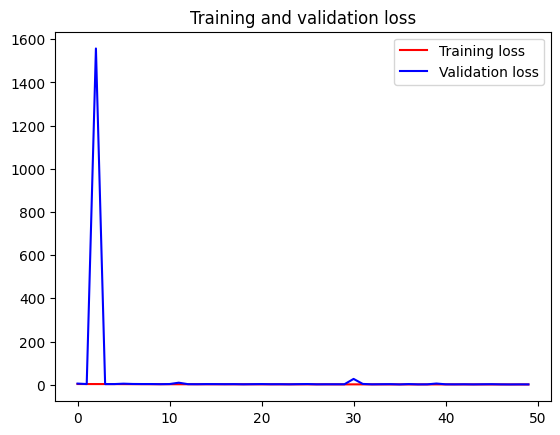

In [7]:
# train_ds, val_ds, class_names, num_classes
# with tensorflow.device("/CPU:0"):
def exec_train_InceptionV3():
    mod_name = "InceptionV3"
    inception_mod = create_model__inception_v3(num_classes)
    inception_mod, hist = train_model(
        inception_mod, model_name=mod_name, train_ds=train_ds, val_ds=val_ds
    )
    view_train_chart(hist)
    os.makedirs("./models/img_clsr", exist_ok=True)
    inception_mod.save(f"./models/img_clsr/{mod_name}.keras")

exec_train_InceptionV3()

In [25]:
def show_model_train_log(file_list):
    import pandas as pd
    import glob
    import os
    import regex as re
    if not file_list:
        model_name = ["resnet151_v2", "inception_v3"]
        model_data = pd.DataFrame()
        for mod in model_name:
            list_of_files = glob.glob(f"./logs/training__{mod}*.csv") # * means all if need specific format then *.csv
            latest_file = max(list_of_files, key=os.path.getctime)

            df = pd.read_csv(latest_file)
            df['model_name']=mod

            model_data = pd.concat([model_data, df], ignore_index=True, sort=False)

        return model_data
    else:
        model_data = pd.DataFrame()

        for log_file in file_list:
            print(log_file)
            regex = re.compile(r"training__(\w+).csv")
            df = pd.read_csv(log_file)
            df["model_name"] = regex.search(log_file).group(1)
            # df['timestamp'] = time.strptime(os.path.getctime(log_file)).strftime("%Y-%m-%d %H:%M:%S")
            # df["timestamp"] = regex.search(log_file).group(2)
            model_data = pd.concat([model_data, df], ignore_index=True, sort=False)

        return model_data

def plot_loss_graph(df):
    import pandas as pd
    import matplotlib.pyplot as plt
    
    plt.plot(df["epoch"],df["loss"],label="loss")
    plt.plot(df["epoch"],df["val_loss"],label="val_loss")
    plt.legend()
    plt.show()
    
    
def plot_acc_graph(df):
    import pandas as pd
    import matplotlib.pyplot as plt
    
    plt.plot(df["epoch"],df["acc"],label="acc")
    plt.plot(df["epoch"],df["val_acc"],label="val_acc")
    plt.legend()
    plt.show()
    
    


In [29]:
# local
df =  show_model_train_log(["training__inception_v3.csv", "training__resnet151_v2.csv"])




training__inception_v3.csv
training__resnet151_v2.csv


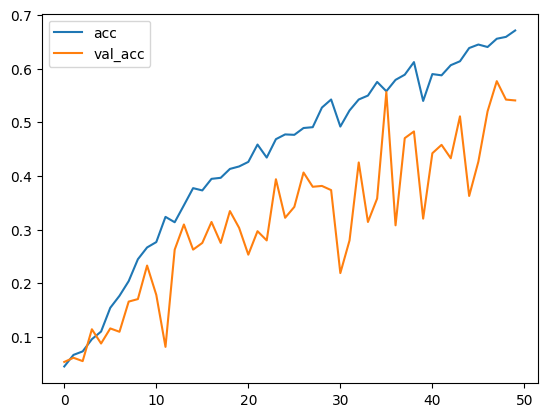

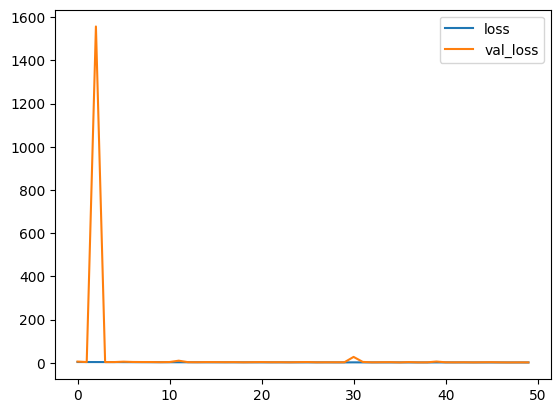

In [33]:
inception_data = df[df["model_name"] == "inception_v3"]

plot_acc_graph(inception_data)
plot_loss_graph(inception_data)


In [42]:
df.iloc[inception_data['epoch'].idxmax()]

epoch                   49
acc               0.671032
loss              0.974486
val_acc           0.540625
val_loss          1.352597
model_name    inception_v3
Name: 49, dtype: object

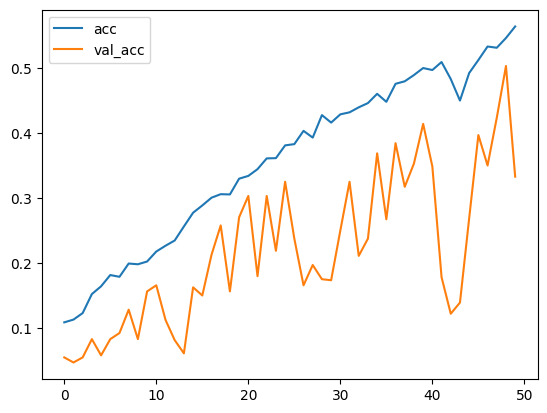

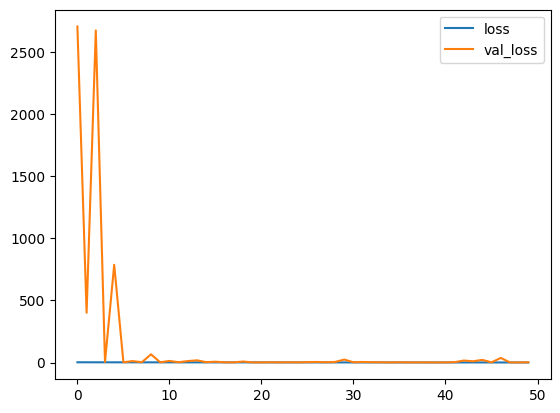

In [40]:
resnet_data = df[df["model_name"] == "resnet151_v2"]
plot_acc_graph(resnet_data)
plot_loss_graph(resnet_data)

In [41]:
df.iloc[resnet_data["epoch"].idxmax()]

epoch                   49
acc               0.563945
loss               1.31044
val_acc           0.332812
val_loss          2.935981
model_name    resnet151_v2
Name: 99, dtype: object

In [ ]:
# test run, evaluate the model